# Importing some packages

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import calendar
from scipy.signal import periodogram
from scipy.stats import iqr
from statsmodels.tsa.deterministic import CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from tqdm import tqdm
import pytz

plt.rcParams.update({'figure.figsize': (20, 10)})

# Loading the data

In [ ]:
data = pd.read_csv('hydro_data.csv')
data.head()

Agency_Code (5s)  Site_Number (15s)    DateTime (20d) Time_Zone (6s)  \
0             USGS            2300700  2018-06-30 23:00            EDT   
1             USGS            2300700  2018-06-30 23:15            EDT   
2             USGS            2300700  2018-06-30 23:30            EDT   
3             USGS            2300700  2018-06-30 23:45            EDT   
4             USGS            2300700  2018-07-01 00:00            EDT   

   Discharge (14n) Quality_Code  Gage_Height (14n)  
0            125.0            A              22.17  
1            125.0            A              22.17  
2            125.0            A              22.16  
3            125.0            A              22.16  
4            125.0            A              22.16

# Data exploration

Let's show general info related to the data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97507 entries, 0 to 97506
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agency_Code (5s)   97507 non-null  object 
 1   Site_Number (15s)  97507 non-null  int64  
 2   DateTime (20d)     97507 non-null  object 
 3   Time_Zone (6s)     97507 non-null  object 
 4   Discharge (14n)    97507 non-null  float64
 5   Quality_Code       97507 non-null  object 
 6   Gage_Height (14n)  97507 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.2+ MB


There is no missing data which is great. But the datetime column's type should be changed. Let's also convert the datetime into UTC format (it is not necessary).

In [ ]:
# data['DateTime (20d)'] = pd.to_datetime(data['DateTime (20d)'], utc=True)
data['DateTime (20d)'] = pd.to_datetime(data['DateTime (20d)'])
data.loc[data['Time_Zone (6s)']=='EDT', 'DateTime (20d)'] += timedelta(hours=4)
data.loc[data['Time_Zone (6s)']=='EST', 'DateTime (20d)'] += timedelta(hours=5)
# data['DateTime (20d)'] = data['DateTime (20d)'].apply(lambda x: x.tz_convert('EST'))

# data['DateTime (20d)'] = pd.to_datetime(data['DateTime (20d)'])
# data.loc[data['Time_Zone (6s)']=='EST', 'DateTime (20d)'] -= timedelta(hours=1)
data.head()

Agency_Code (5s)  Site_Number (15s)      DateTime (20d) Time_Zone (6s)  \
0             USGS            2300700 2018-07-01 03:00:00            EDT   
1             USGS            2300700 2018-07-01 03:15:00            EDT   
2             USGS            2300700 2018-07-01 03:30:00            EDT   
3             USGS            2300700 2018-07-01 03:45:00            EDT   
4             USGS            2300700 2018-07-01 04:00:00            EDT   

   Discharge (14n) Quality_Code  Gage_Height (14n)  
0            125.0            A              22.17  
1            125.0            A              22.17  
2            125.0            A              22.16  
3            125.0            A              22.16  
4            125.0            A              22.16

Checking the general info once again.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97507 entries, 0 to 97506
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Agency_Code (5s)   97507 non-null  object        
 1   Site_Number (15s)  97507 non-null  int64         
 2   DateTime (20d)     97507 non-null  datetime64[ns]
 3   Time_Zone (6s)     97507 non-null  object        
 4   Discharge (14n)    97507 non-null  float64       
 5   Quality_Code       97507 non-null  object        
 6   Gage_Height (14n)  97507 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.2+ MB


Let's explore the unique values for some columns.

In [ ]:
for col in ['Agency_Code (5s)', 'Site_Number (15s)', 'Time_Zone (6s)', 'Quality_Code']:

    print(f"{col}: {data[col].unique()}")

Agency_Code (5s): ['USGS']
Site_Number (15s): [2300700]
Time_Zone (6s): ['EDT' 'EST']
Quality_Code: ['A']


Let's also sort the data in ascending order using the datetime column.

In [ ]:
data = data[~data.drop(columns=['Time_Zone (6s)']).duplicated()]
data.sort_values('DateTime (20d)', ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)

Checking minute difference between subsequent datetimes

In [ ]:
(data['DateTime (20d)'].diff().dt.total_seconds()/60).value_counts()

15.0       97498
30.0           3
45.0           1
2910.0         1
1710.0         1
7230.0         1
12600.0        1
Name: DateTime (20d), dtype: int64

The table above shows that there some datapoints that has been recorded not after 15 minutes, but after 30 minutes, 45 minutes, etc. Though the overall number of such datapoints is 8, let's fill in the missing datapoints using the previous available values. In nutshell, we will add the missing datetimes and apply fill forward methodology for discharge and gage height.

In [ ]:
data['second_diff'] = data['DateTime (20d)'].diff().dt.total_seconds()/60
data['second_diff'].fillna(15.0, inplace=True)

diff_values = list(data['second_diff'])
date_values = list(data['DateTime (20d)'])
discharge_values = list(data['Discharge (14n)'])
cage_height_values = list(data['Gage_Height (14n)'])

date_list = []
discharge_list = []
cage_height_list = []

for i in range(len(diff_values)):
    if diff_values[i] != 15:
        n_iters = int(diff_values[i] / 15) - 1
        for j in range(1, n_iters+1):
            date_list.append(date_values[i]-timedelta(minutes=15*j))
            discharge_list.append(discharge_values[i-1])
            cage_height_list.append(cage_height_values[i-1])

temp_df = pd.DataFrame(
    {
        'DateTime (20d)': date_list,
        'Discharge (14n)': discharge_list,
        'Gage_Height (14n)': cage_height_list
    }
)


cols_4drop_list = [
    'Agency_Code (5s)',
    'Time_Zone (6s)',
    'Quality_Code',
    'Site_Number (15s)',
    'second_diff'
]

data.drop(columns=cols_4drop_list, inplace=True)

data = pd.concat([data, temp_df], axis=0)
data.sort_values('DateTime (20d)', ascending=True, inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(99138, 3)

Let's check the minute difference again.

In [ ]:
(data['DateTime (20d)'].diff().dt.total_seconds()/60).value_counts()

15.0    99137
Name: DateTime (20d), dtype: int64

Now we can plot the charts for the series.

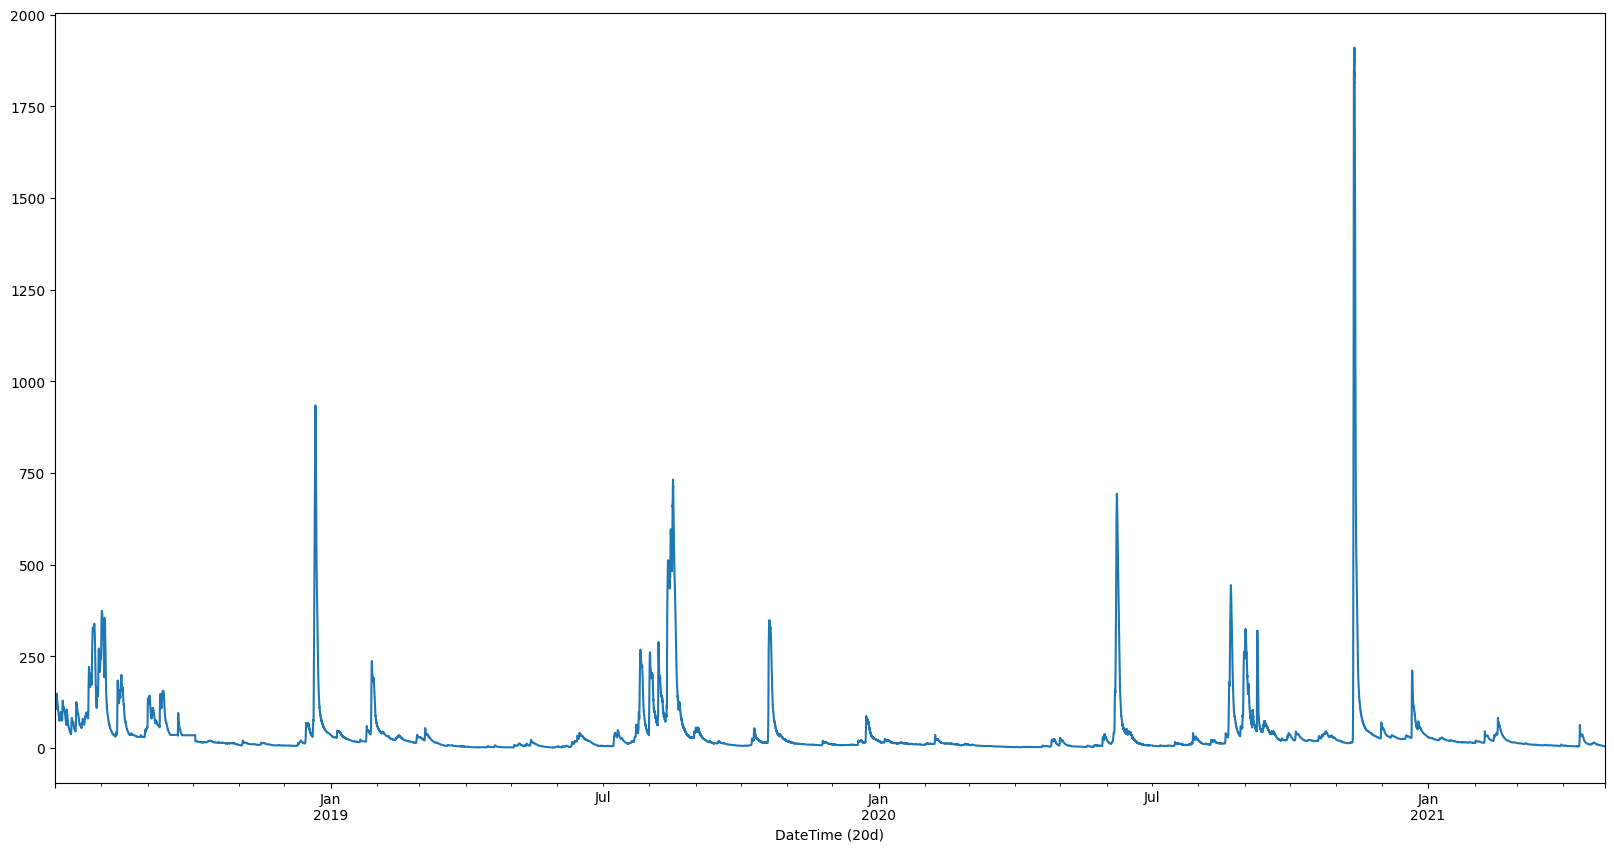

In [ ]:
data.set_index('DateTime (20d)')['Discharge (14n)'].plot();

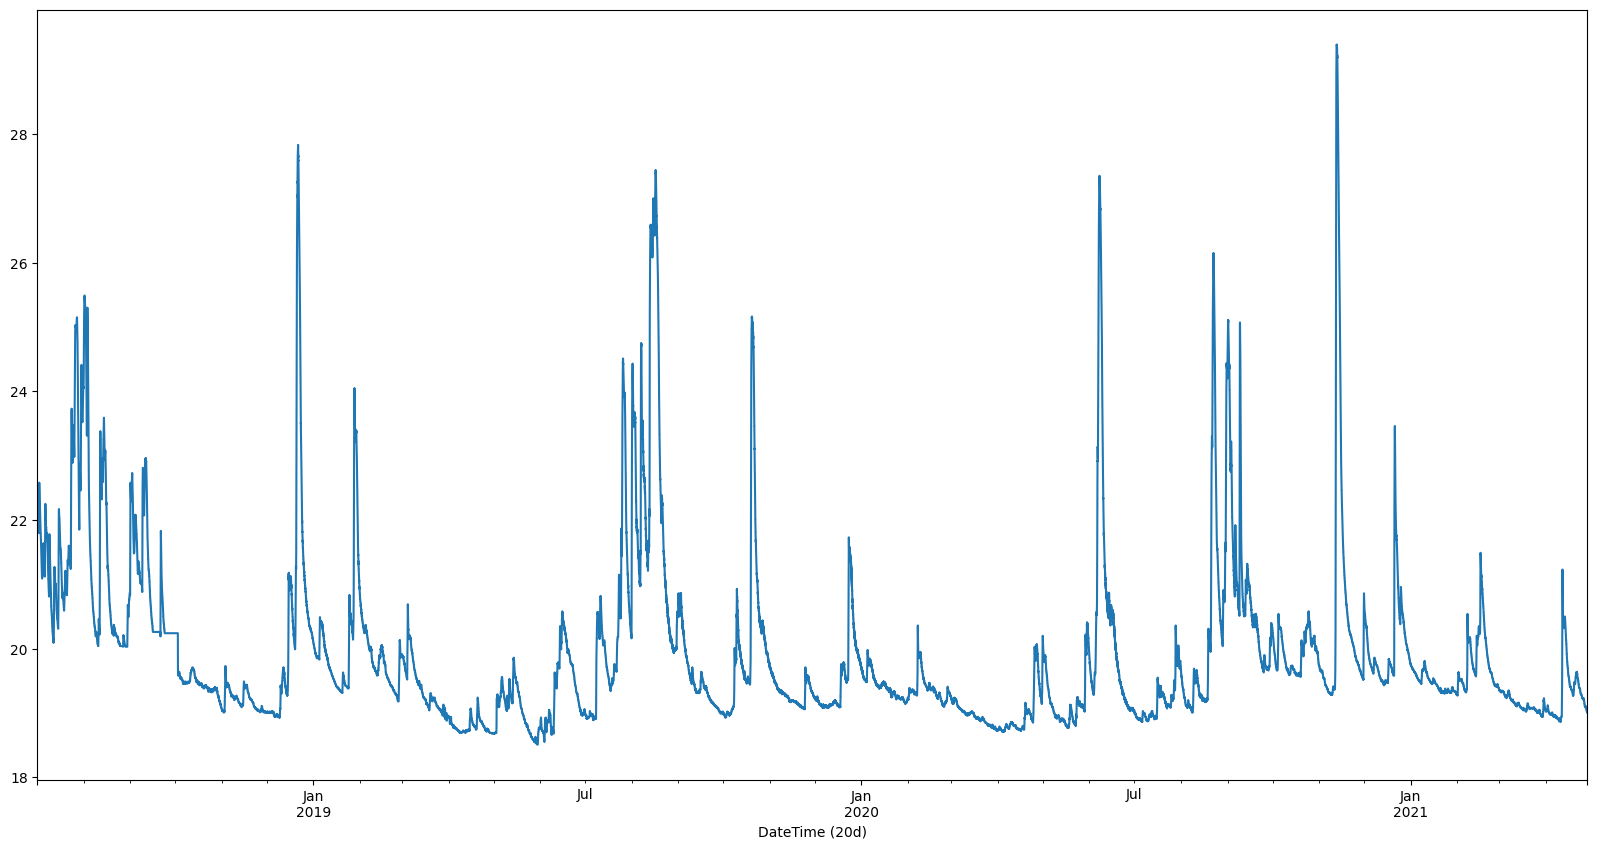

In [ ]:
data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot();

Let's also show the last 5 rows of the data.

In [ ]:
data.tail()

DateTime (20d)  Discharge (14n)  Gage_Height (14n)
99133 2021-04-28 18:15:00             4.43               19.0
99134 2021-04-28 18:30:00             4.42               19.0
99135 2021-04-28 18:45:00             4.42               19.0
99136 2021-04-28 19:00:00             4.42               19.0
99137 2021-04-28 19:15:00             4.42               19.0

So the last datetime available is 2021-04-28 19:15:00, hence the forecast will be done up to 2026-04-28 19:15:00.

# Feature engineering

As there are 35040 15 minutes in 365 days (365 * 24 * 4), let's calculate the 35040 minute moving average of the series to approximate the general trend in the data.

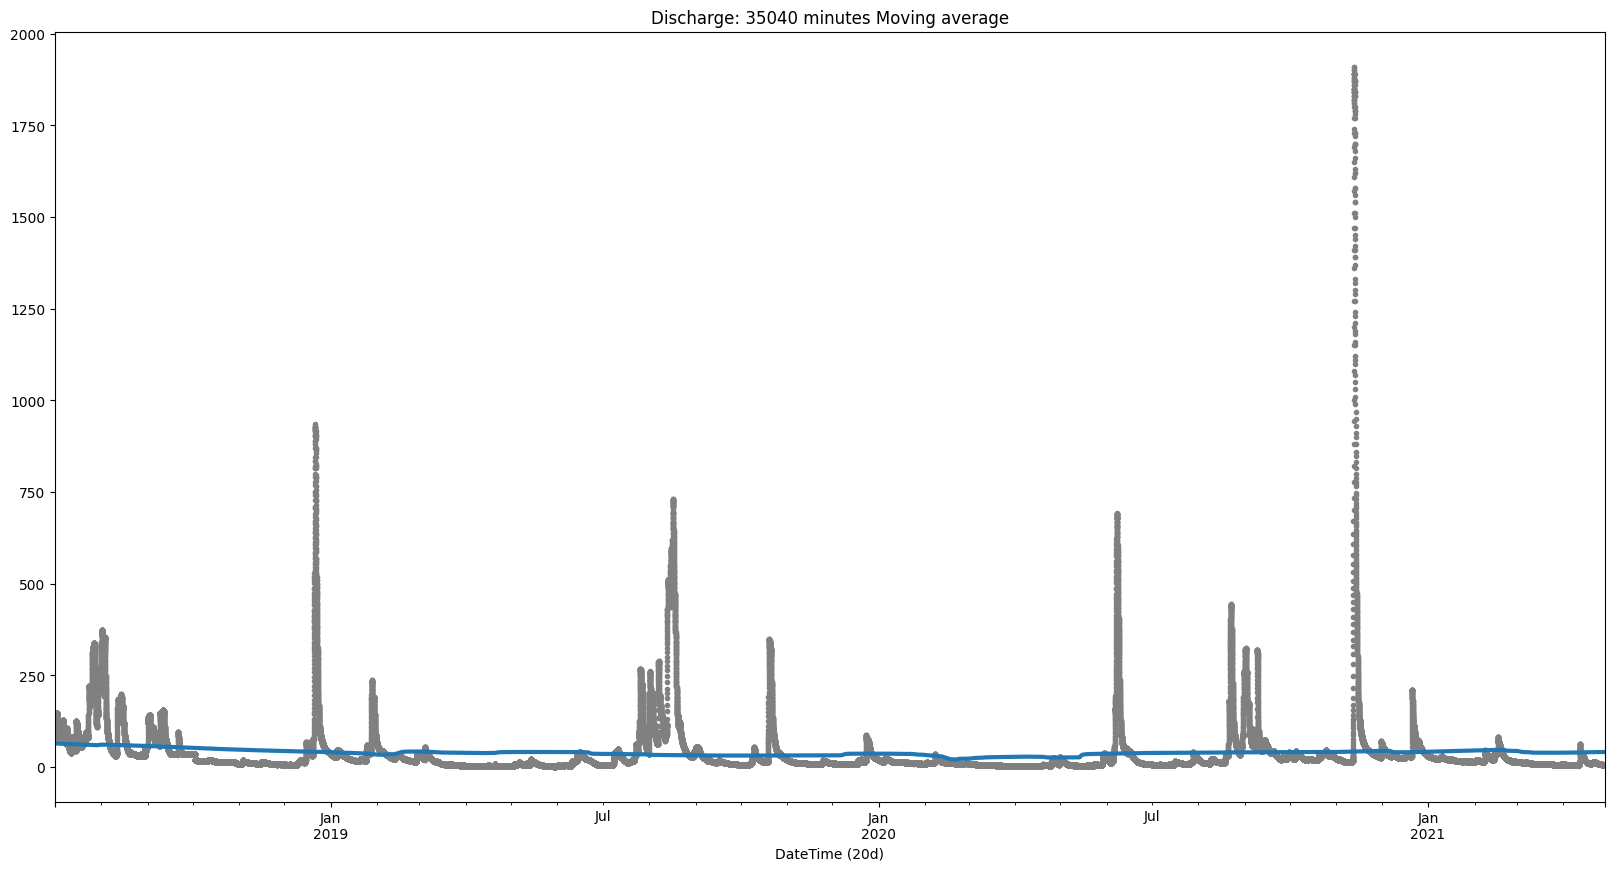

In [ ]:
discharge_ma = data.set_index('DateTime (20d)')['Discharge (14n)'].rolling(
    window=35040,
    center=True,
    min_periods=17520
).mean()

ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(style='.', color='0.5')
discharge_ma.plot(
    ax=ax,
    linewidth=3,
    title='Discharge: 35040 minutes Moving average',
    legend=False
);

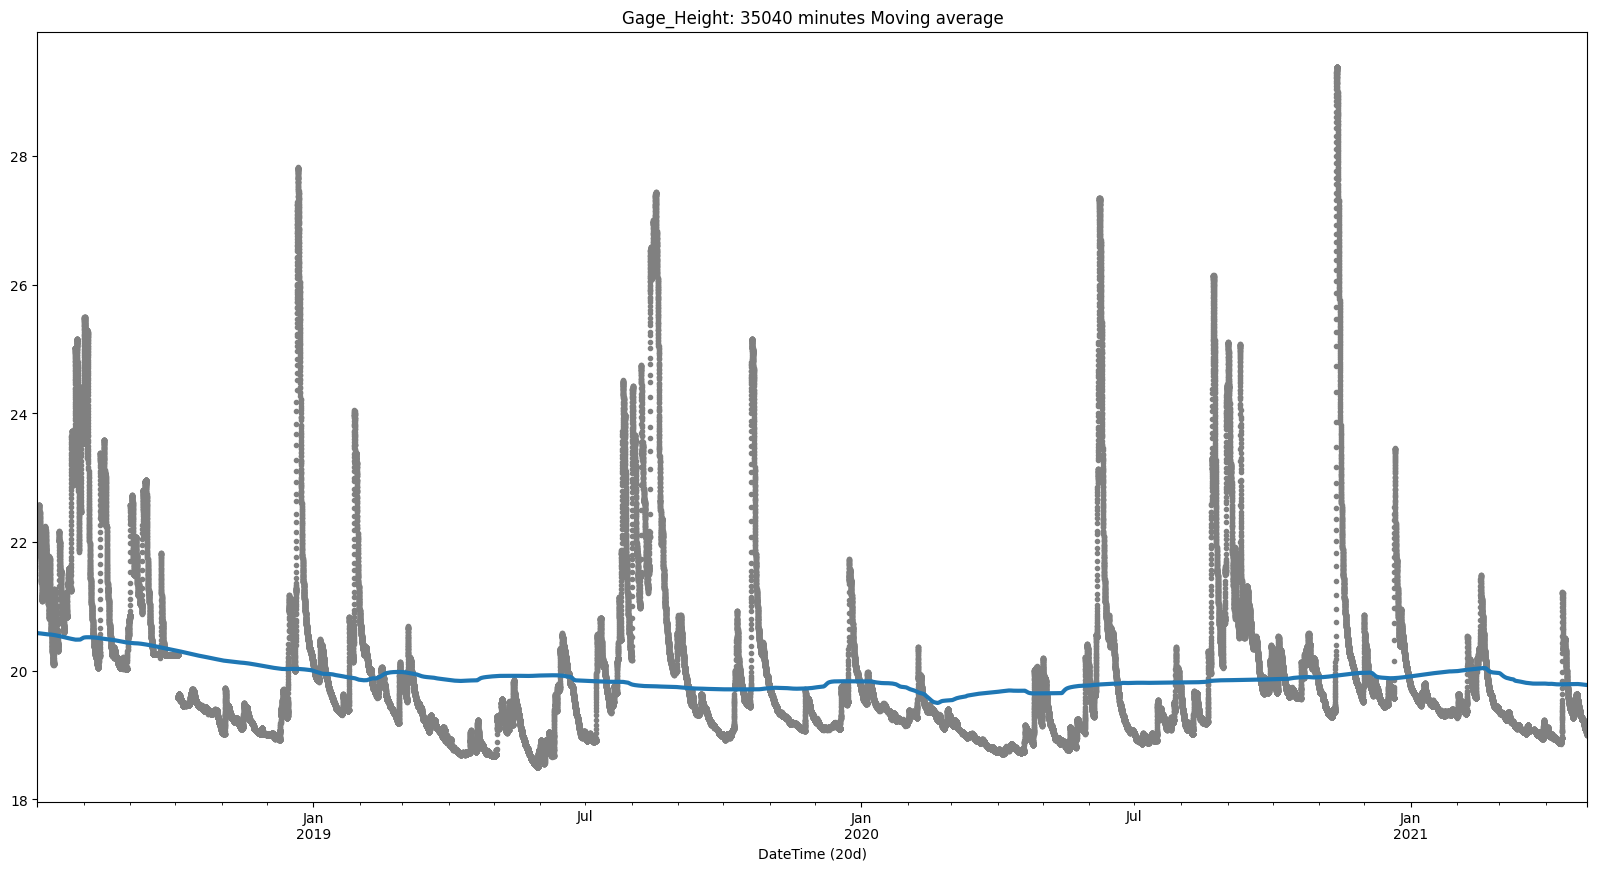

In [ ]:
discharge_ma = data.set_index('DateTime (20d)')['Gage_Height (14n)'].rolling(
    window=35040,
    center=True,
    min_periods=17520
).mean()

ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(style='.', color='0.5')
discharge_ma.plot(
    ax=ax,
    linewidth=3,
    title='Gage_Height: 35040 minutes Moving average',
    legend=False
);

Now let's create a time step feature and estimate the trend using linear regression.

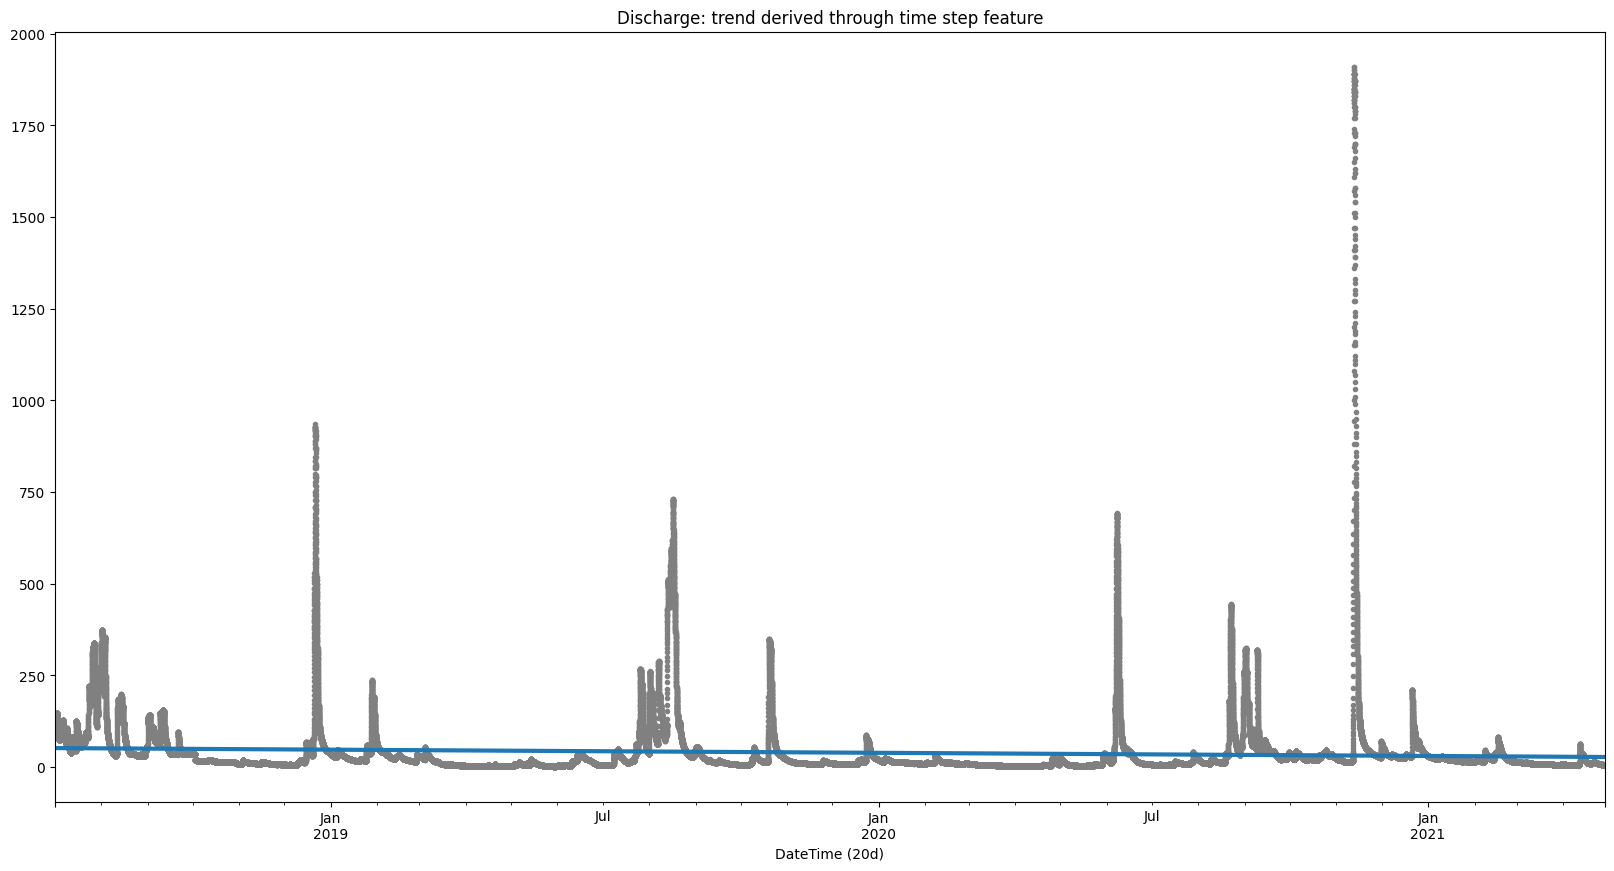

In [ ]:
data['time_step'] = np.arange(1, data.shape[0]+1)

lr_discharge = LinearRegression()
lr_discharge.fit(data['time_step'].to_frame(), data['Discharge (14n)'])

discharge_trend = pd.Series(
    lr_discharge.predict(data['time_step'].to_frame()),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(style='.', color='0.5')
discharge_trend.plot(
    ax=ax,
    linewidth=3,
    title='Discharge: trend derived through time step feature',
    legend=False
);

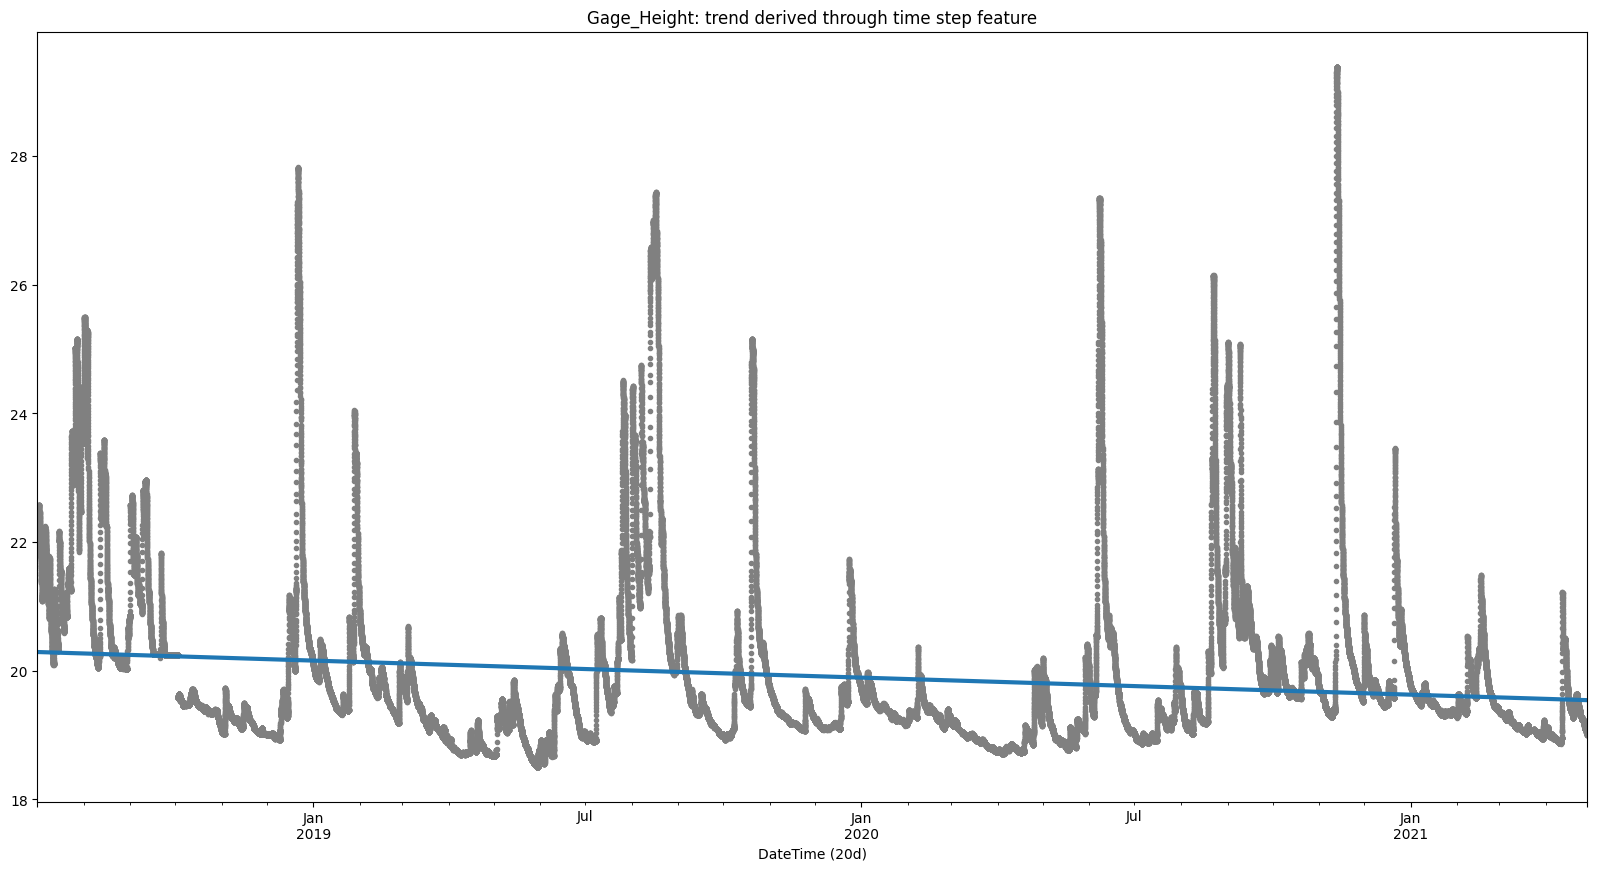

In [ ]:
lr_gage_height = LinearRegression()
lr_gage_height.fit(data['time_step'].to_frame(), data['Gage_Height (14n)'])

gage_height_trend = pd.Series(
    lr_gage_height.predict(data['time_step'].to_frame()),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(style='.', color='0.5')
gage_height_trend.plot(
    ax=ax,
    linewidth=3,
    title='Gage_Height: trend derived through time step feature',
    legend=False
);

Checking the trend created using the second order polynomial of the time step feature

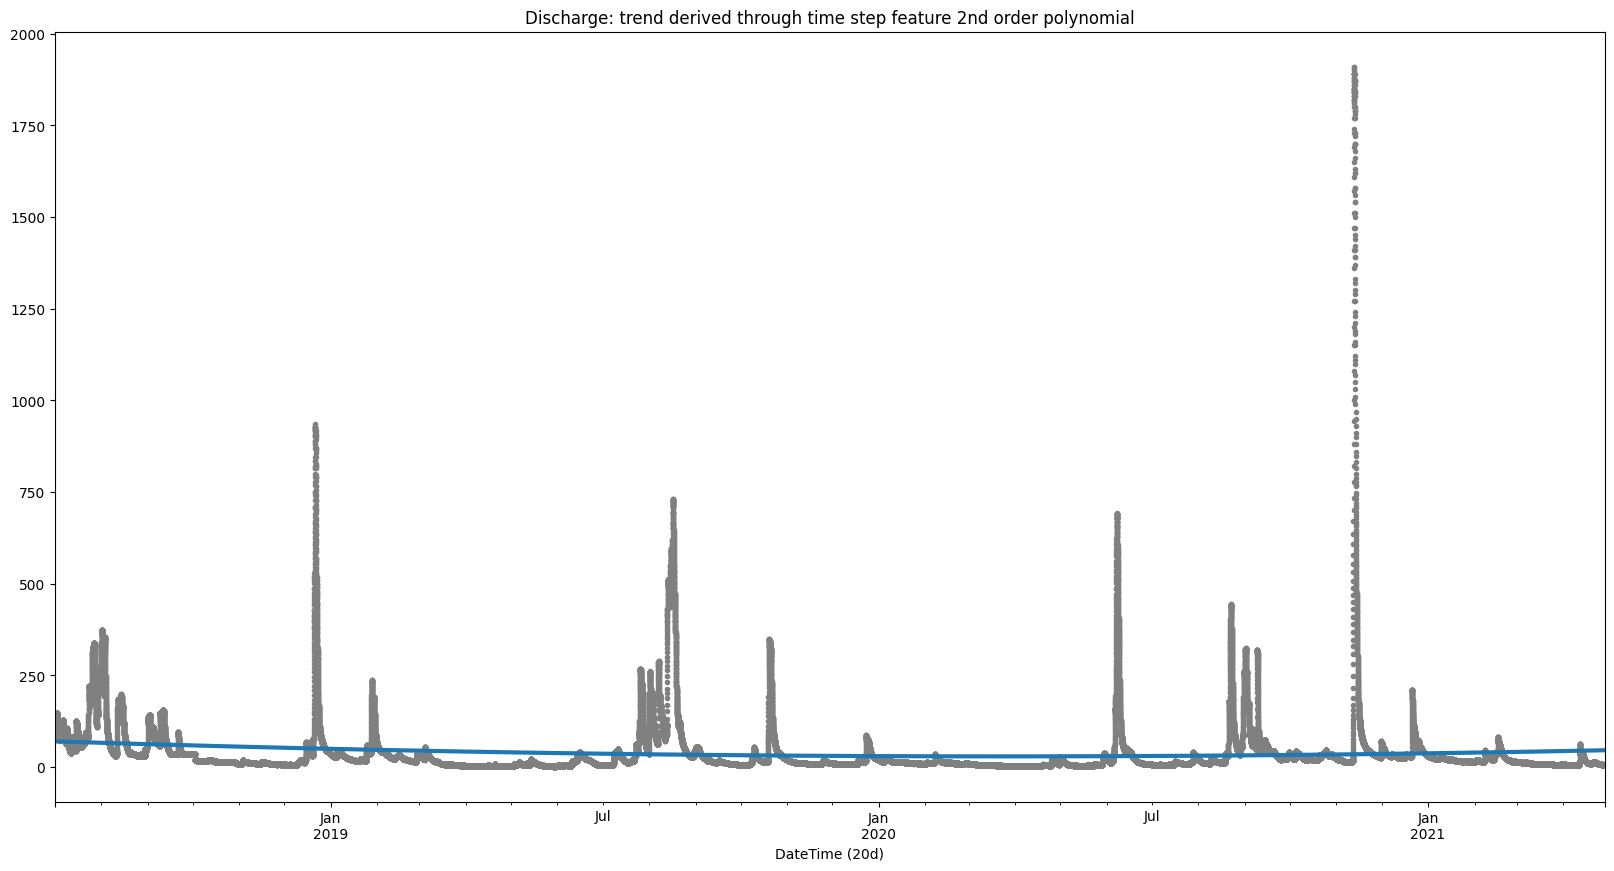

In [ ]:
data['time_step2'] = data['time_step'] ** 2

lr_discharge = LinearRegression()
lr_discharge.fit(data[['time_step', 'time_step2']], data['Discharge (14n)'])

discharge_trend2 = pd.Series(
    lr_discharge.predict(data[['time_step', 'time_step2']]),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(style='.', color='0.5')
discharge_trend2.plot(
    ax=ax,
    linewidth=3,
    title='Discharge: trend derived through time step feature 2nd order polynomial',
    legend=False
);

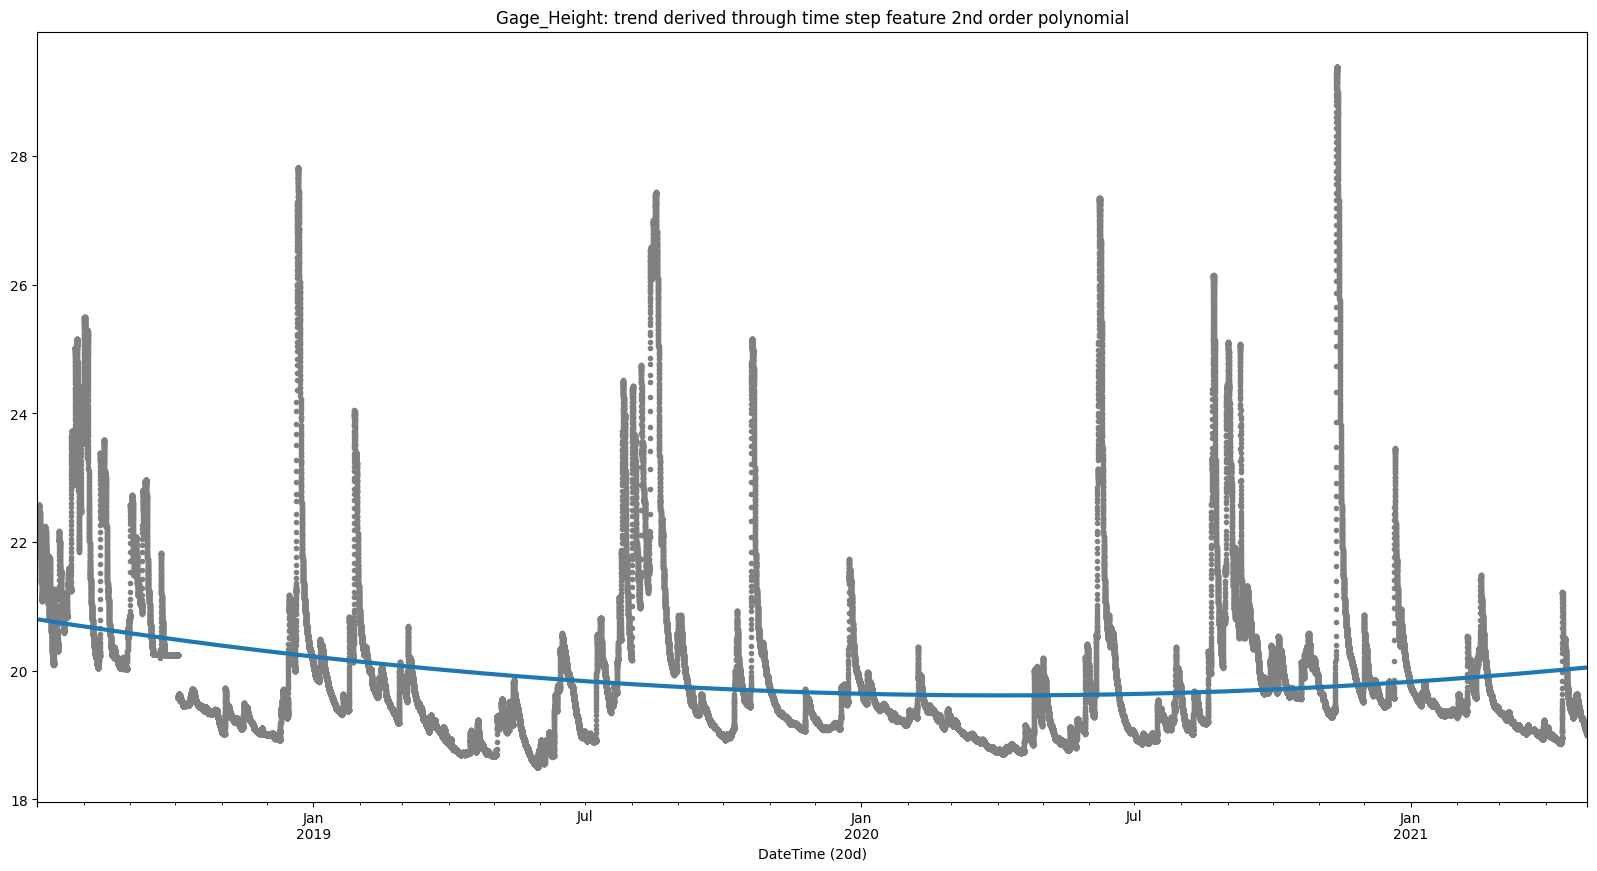

In [ ]:
lr_gage_height = LinearRegression()
lr_gage_height.fit(data[['time_step', 'time_step2']], data['Gage_Height (14n)'])

gage_height_trend2 = pd.Series(
    lr_gage_height.predict(data[['time_step', 'time_step2']]),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(style='.', color='0.5')
gage_height_trend2.plot(
    ax=ax,
    linewidth=3,
    title='Gage_Height: trend derived through time step feature 2nd order polynomial',
    legend=False
);

Let's also check the trend created using the third order polynomial of the time step feature.

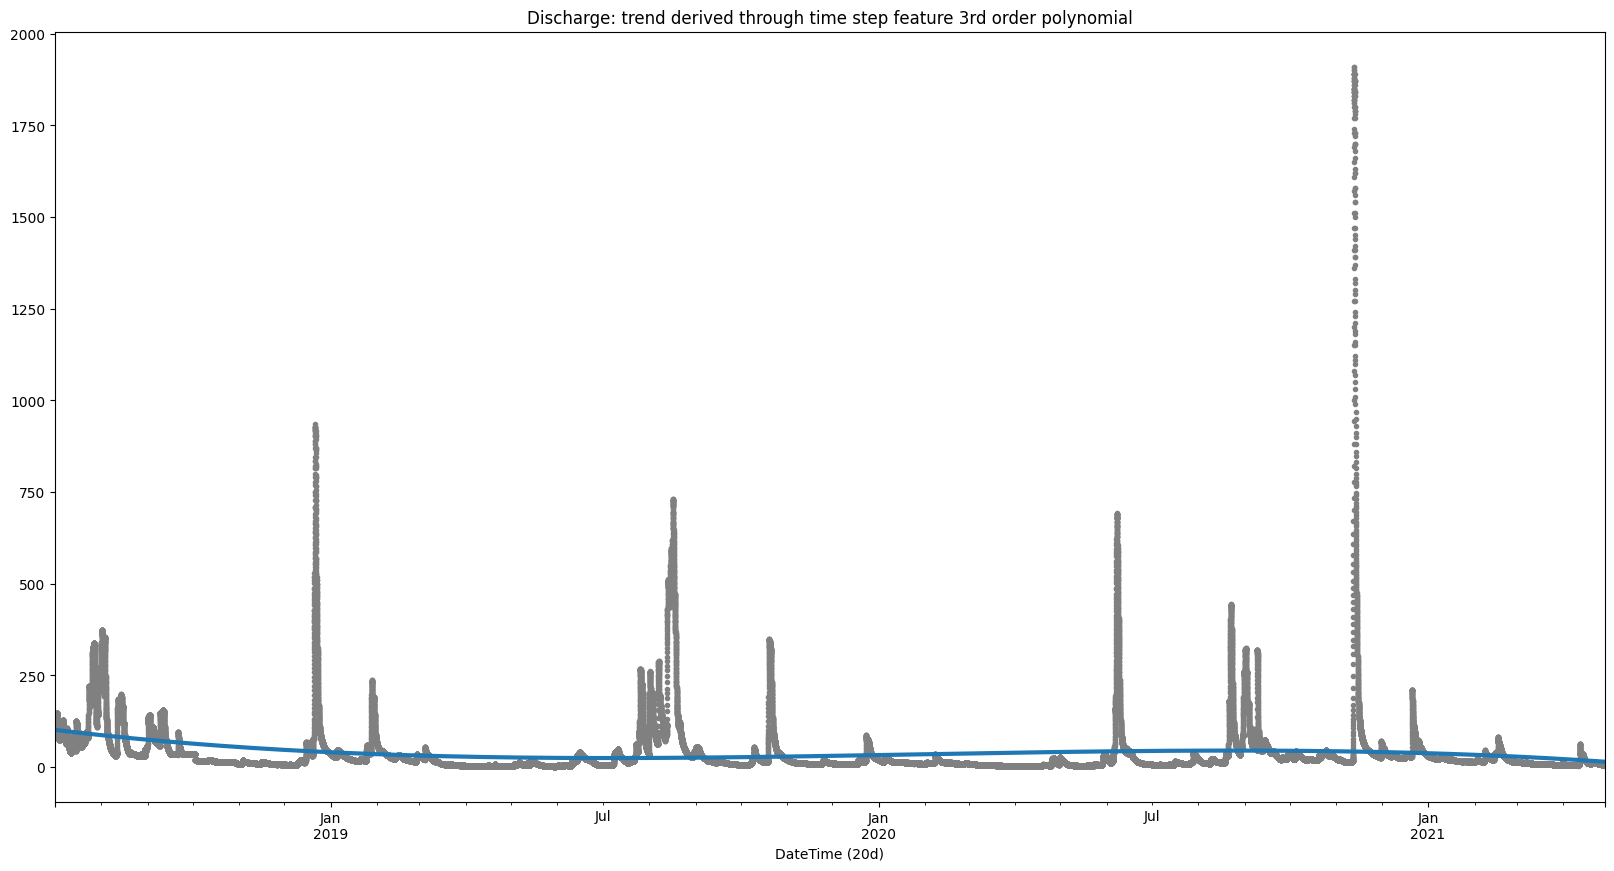

In [ ]:
data['time_step3'] = data['time_step'] ** 3

lr_discharge = LinearRegression()
lr_discharge.fit(data[['time_step', 'time_step2', 'time_step3']], data['Discharge (14n)'])

discharge_trend3 = pd.Series(
    lr_discharge.predict(data[['time_step', 'time_step2', 'time_step3']]),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(style='.', color='0.5')
discharge_trend3.plot(
    ax=ax,
    linewidth=3,
    title='Discharge: trend derived through time step feature 3rd order polynomial',
    legend=False
);

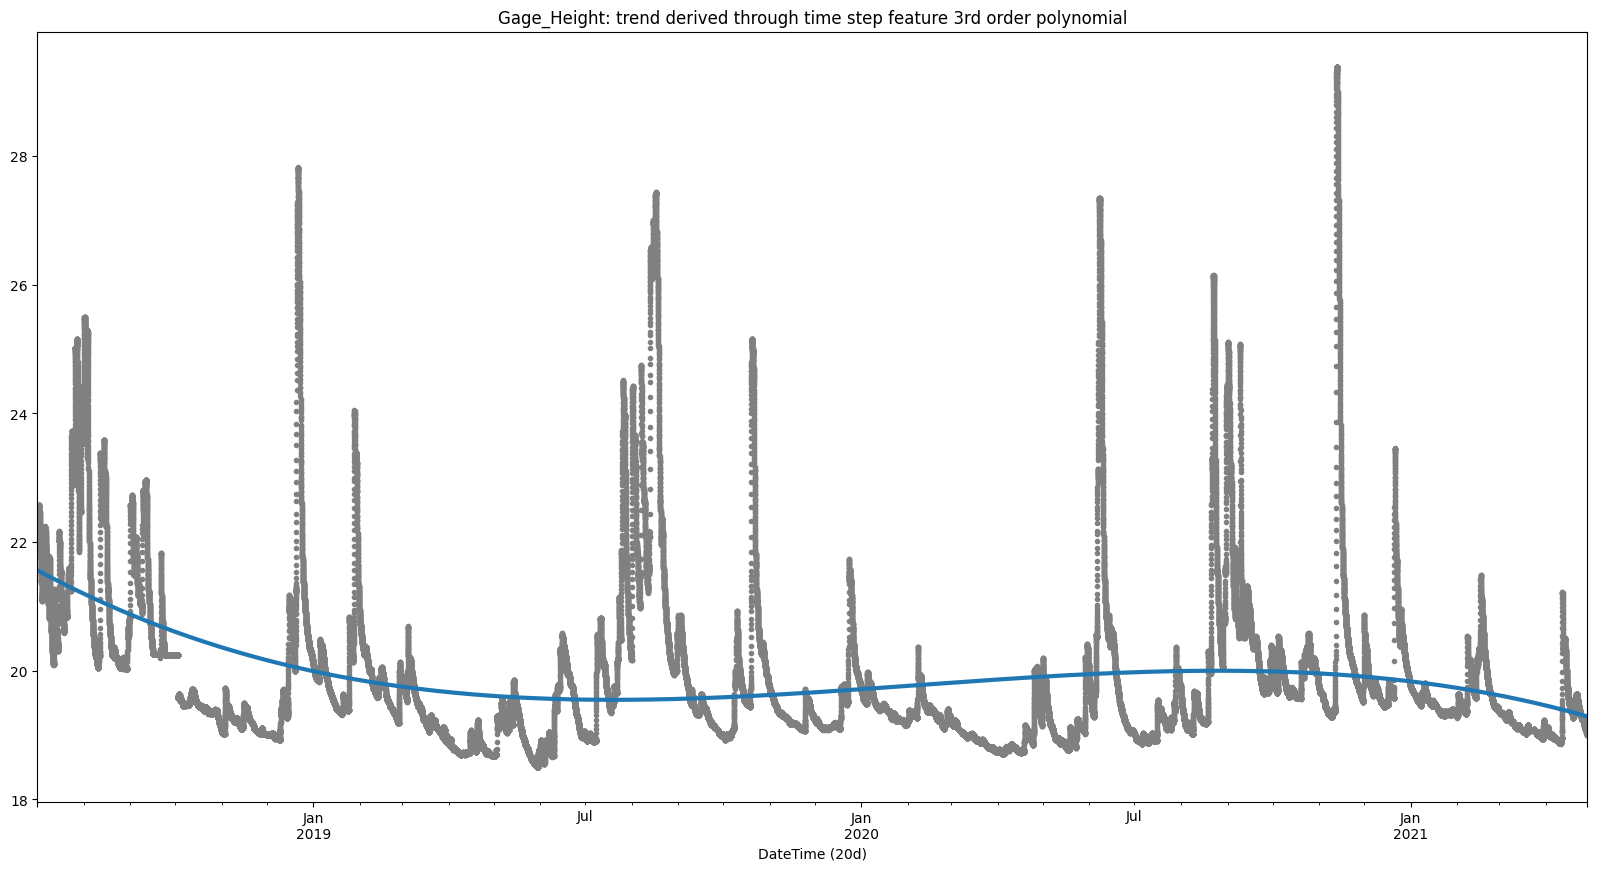

In [ ]:
lr_gage_height = LinearRegression()
lr_gage_height.fit(data[['time_step', 'time_step2', 'time_step3']], data['Gage_Height (14n)'])

gage_height_trend3 = pd.Series(
    lr_gage_height.predict(data[['time_step', 'time_step2', 'time_step3']]),
    index=data['DateTime (20d)']
)

ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(style='.', color='0.5')
gage_height_trend3.plot(
    ax=ax,
    linewidth=3,
    title='Gage_Height: trend derived through time step feature 3rd order polynomial',
    legend=False
);

Well, let's use the 1st order polynomial to approximate the trend for the series.

The next step will be to create some new features out of the datetime column and check their importance for prediction. Actually the created features will help identify the seasonality in some sense.

In [ ]:
data['week'] = data['DateTime (20d)'].dt.isocalendar().week
data['year'] = data['DateTime (20d)'].dt.year
data['dayofweek'] = data['DateTime (20d)'].dt.dayofweek
data['hour'] = data['DateTime (20d)'].dt.hour
data['month'] = data['DateTime (20d)'].dt.month
data['day'] = data['DateTime (20d)'].dt.day
data['weekofmonth'] = data['day'].apply(lambda x: (x-1) // 7 + 1)

# # extracting EDT and EST conversion dates
# edt_dates_data = list(
#     data[
#         (data['hour']==7) & (data['month']==3) &
#         (data['weekofmonth']==2) & (data['minute']==0) &
#         (data['second']==0) & (data['dayofweek']==6)
#     ]['DateTime (20d)']
# )

# est_dates_data = list(
#     data[
#         (data['hour']==6) & (data['month']==11) &
#         (data['weekofmonth']==1) & (data['minute']==0) &
#         (data['second']==0) & (data['dayofweek']==6)
#     ]['DateTime (20d)']
# )

Let's create seasonality plot of week days by year and week. Actually the plots show the average dynamics of the series over days of week computed for each year and week pair.

In [ ]:
def create_dayofweek_seasonal_plot(df, series_name):

    n_years = df['year'].nunique()

    n_rows = int((n_years-n_years % 3)/3)
    if n_years % 3 != 0:
        n_rows += 1

    fig = plt.figure(figsize=(12, 8))

    suplot_idx = 0

    for year in df['year'].unique():
        suplot_idx += 1
        for week in df['week'].unique():
            temp_df = df[(df['year']==year) & (df['week']==week)]
            temp_df_grouped = temp_df.groupby('dayofweek', as_index=False)[series_name].mean()
            temp_x = temp_df_grouped['dayofweek']
            temp_y = temp_df_grouped[series_name]
            if len(temp_x) == 0:
                continue
            plt.subplot(n_rows, 3, suplot_idx)
            plt.plot(temp_x, temp_y)
            plt.ylabel(series_name)
            plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
            plt.title(str(year))
    plt.suptitle('Seasonal plot (dayofweek) by year and week', y=1.01)
    # plt.xlabel('day of week')
    # plt.ylabel(series_name)
    # plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
    # plt.show()
    plt.tight_layout()

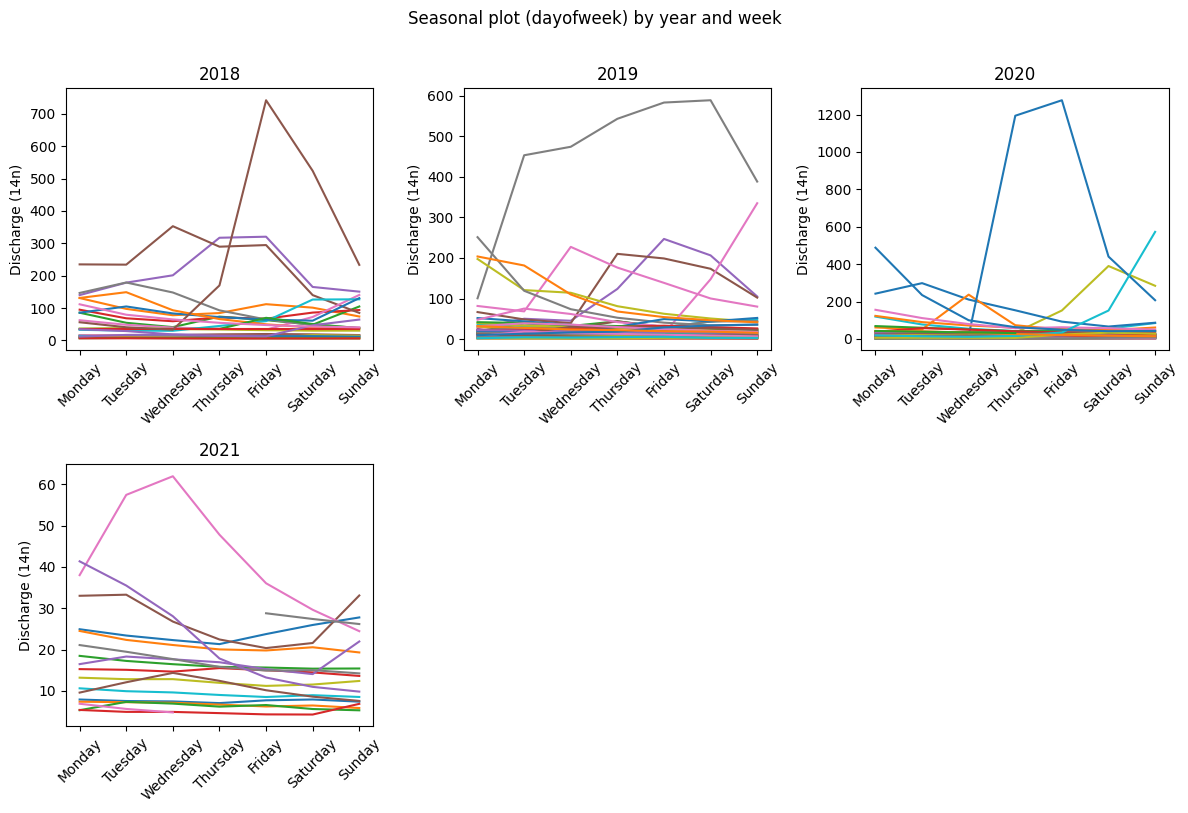

In [ ]:
create_dayofweek_seasonal_plot(df=data, series_name='Discharge (14n)')

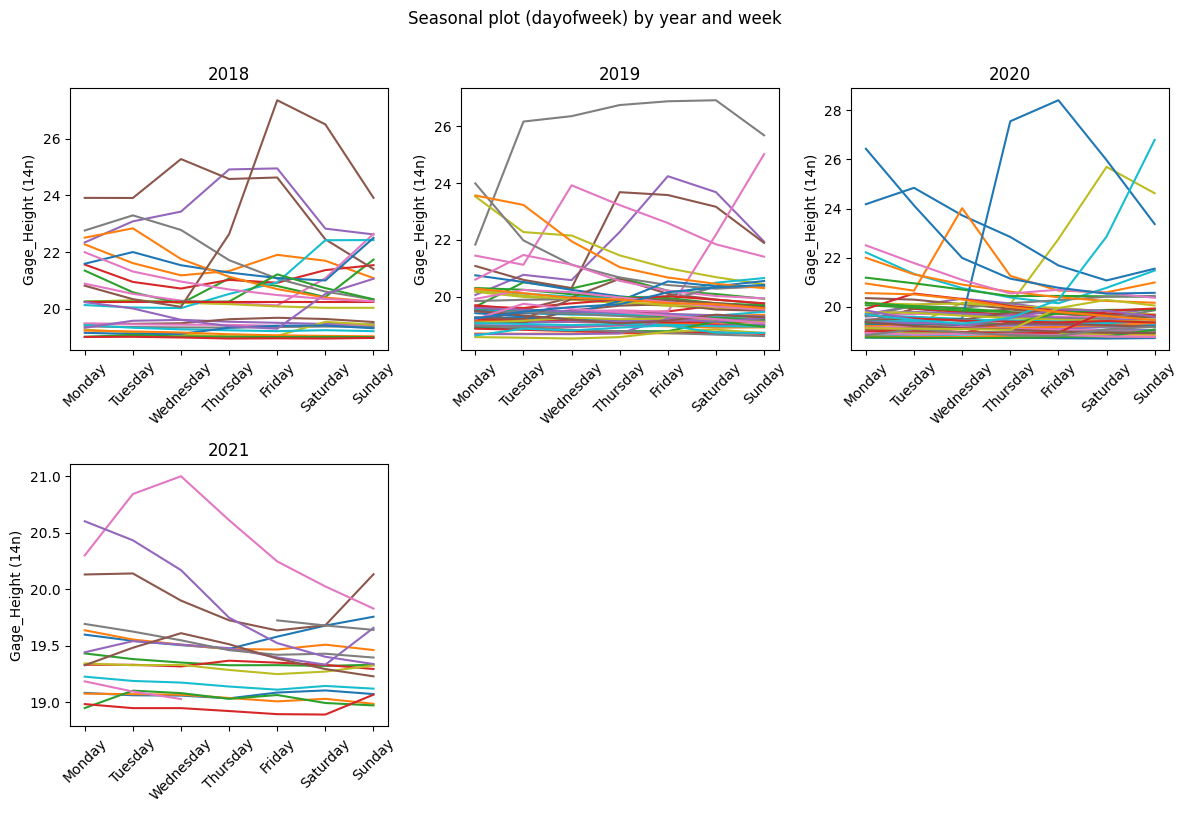

In [ ]:
create_dayofweek_seasonal_plot(df=data, series_name='Gage_Height (14n)')

Judging by the charts above there is not any striking tendecy with respect to days of week. But let's include it into a feature list for seasonality computation.

Let's create another seasonality plot of week days but using filtering by year, month, and week.

In [ ]:
month_names_list = list(calendar.month_name)
month_names_list = [month_str for month_str in month_names_list if month_str!='']

def create_dayofweek_seasonal_plot_weekly_monthly(df, series_name, month_names=month_names_list):
    fig = plt.figure(figsize=(12, 8))
    for year in df['year'].unique():
        for month in df['month'].unique():
            for week in df['week'].unique():
                temp_df = df[(df['year']==year) & (df['month']==month) & (df['week']==week)]
                temp_df_grouped = temp_df.groupby('dayofweek', as_index=False)[series_name].mean()
                temp_x = temp_df_grouped['dayofweek']
                temp_y = temp_df_grouped[series_name]
                if len(temp_x) == 0:
                    continue
                plt.subplot(4, 3, month)
                plt.plot(temp_x, temp_y)
                plt.title(month_names[month-1])
                if month in [10, 11, 12]:
                    plt.xlabel('day of week')
                    plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
                # plt.ylabel(series_name)
    plt.suptitle(f'{series_name}: Seasonal plot (dayofweek) by year, month, and week', y=1.01)
    plt.tight_layout()

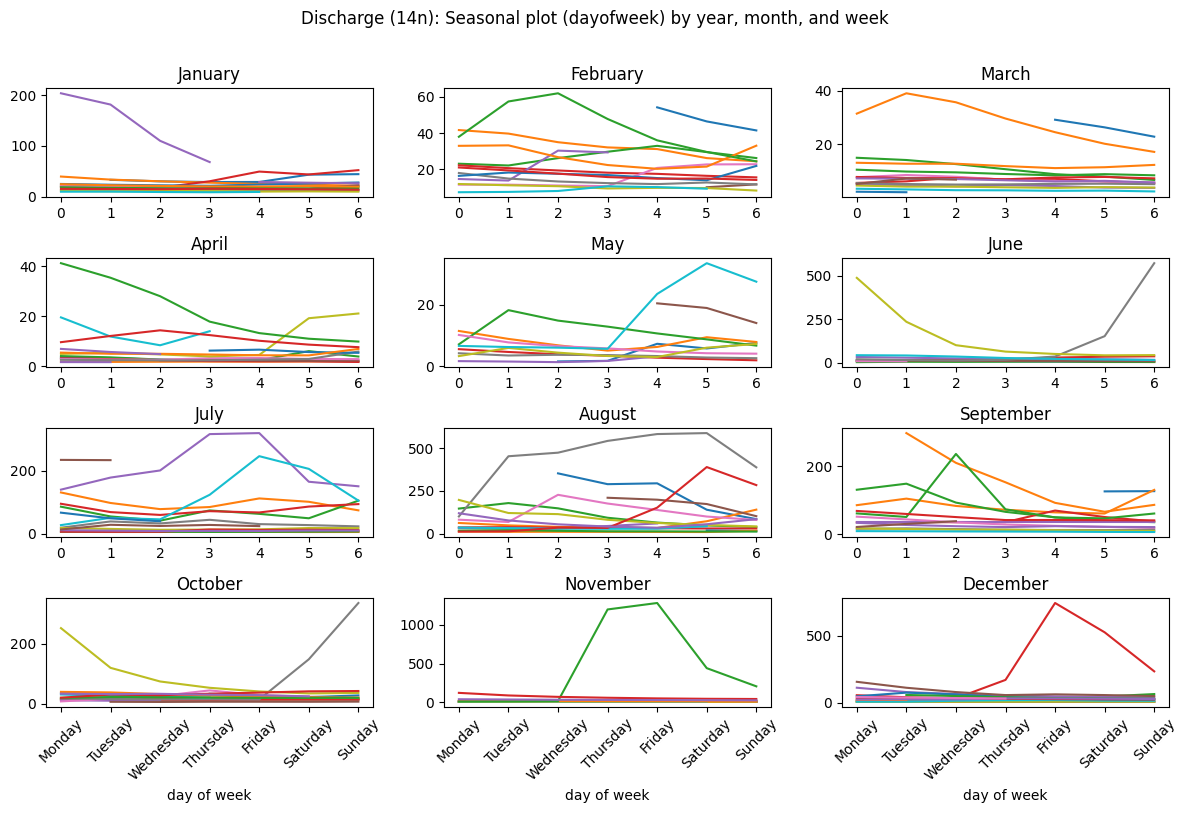

In [ ]:
create_dayofweek_seasonal_plot_weekly_monthly(df=data, series_name='Discharge (14n)')

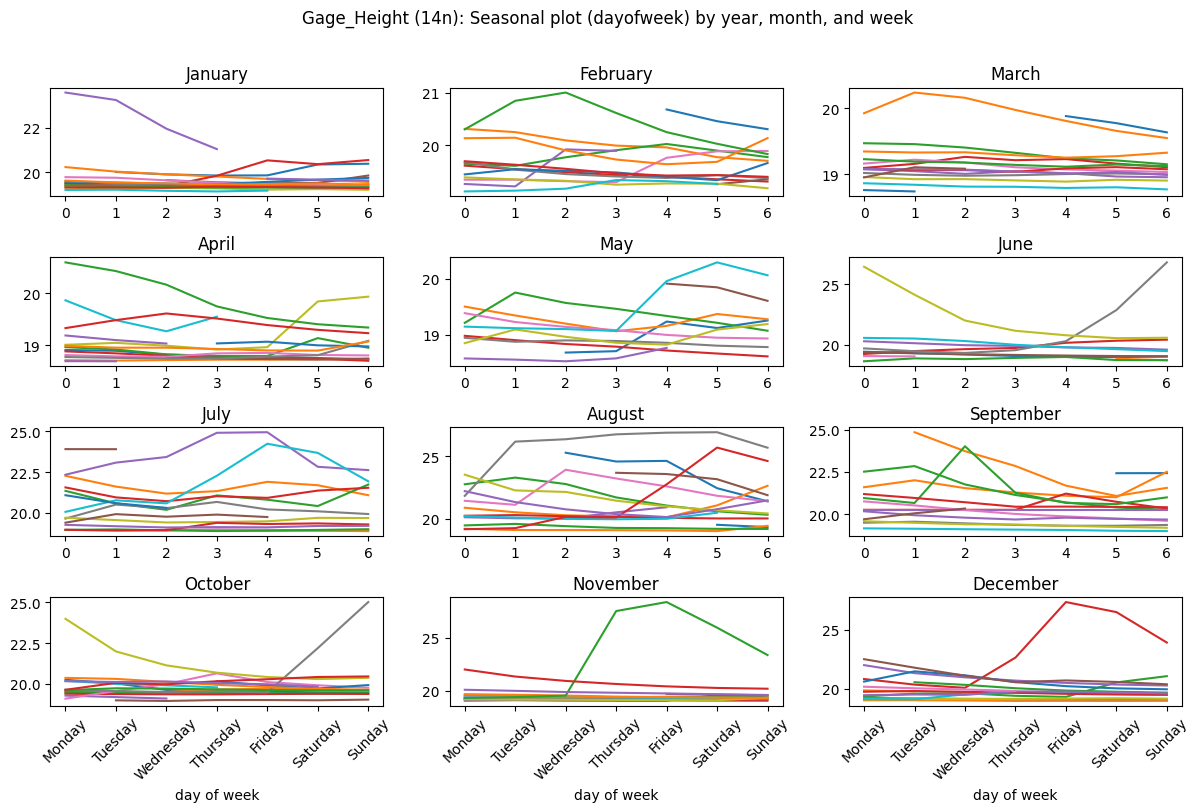

In [ ]:
create_dayofweek_seasonal_plot_weekly_monthly(df=data, series_name='Gage_Height (14n)')

Actually it is not that clear whether the addition of month feature will be helpful or not as shown by the charts above. But maybe there is something that is not clear. So let's address monthly frequency while deriving Fourier series for seasonality modeling.

Let's create seasonality plot of week by years. Actually the plots show the average dynamics of the series over weeks computed for each year.

In [ ]:
def create_week_seasonal_plot(df, series_name):
    for year in df['year'].unique():
        temp_df = df[(df['year']==year)]
        temp_df_grouped = temp_df.groupby('week', as_index=False)[series_name].mean()
        temp_x = temp_df_grouped['week']
        temp_y = temp_df_grouped[series_name]
        if len(temp_x) == 0:
            continue
        plt.plot(temp_x, temp_y, label=str(year))
    plt.title('Seasonal plot (week) by year')
    plt.xlabel('week')
    plt.ylabel(series_name)
    # plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
    plt.legend()
    plt.show()

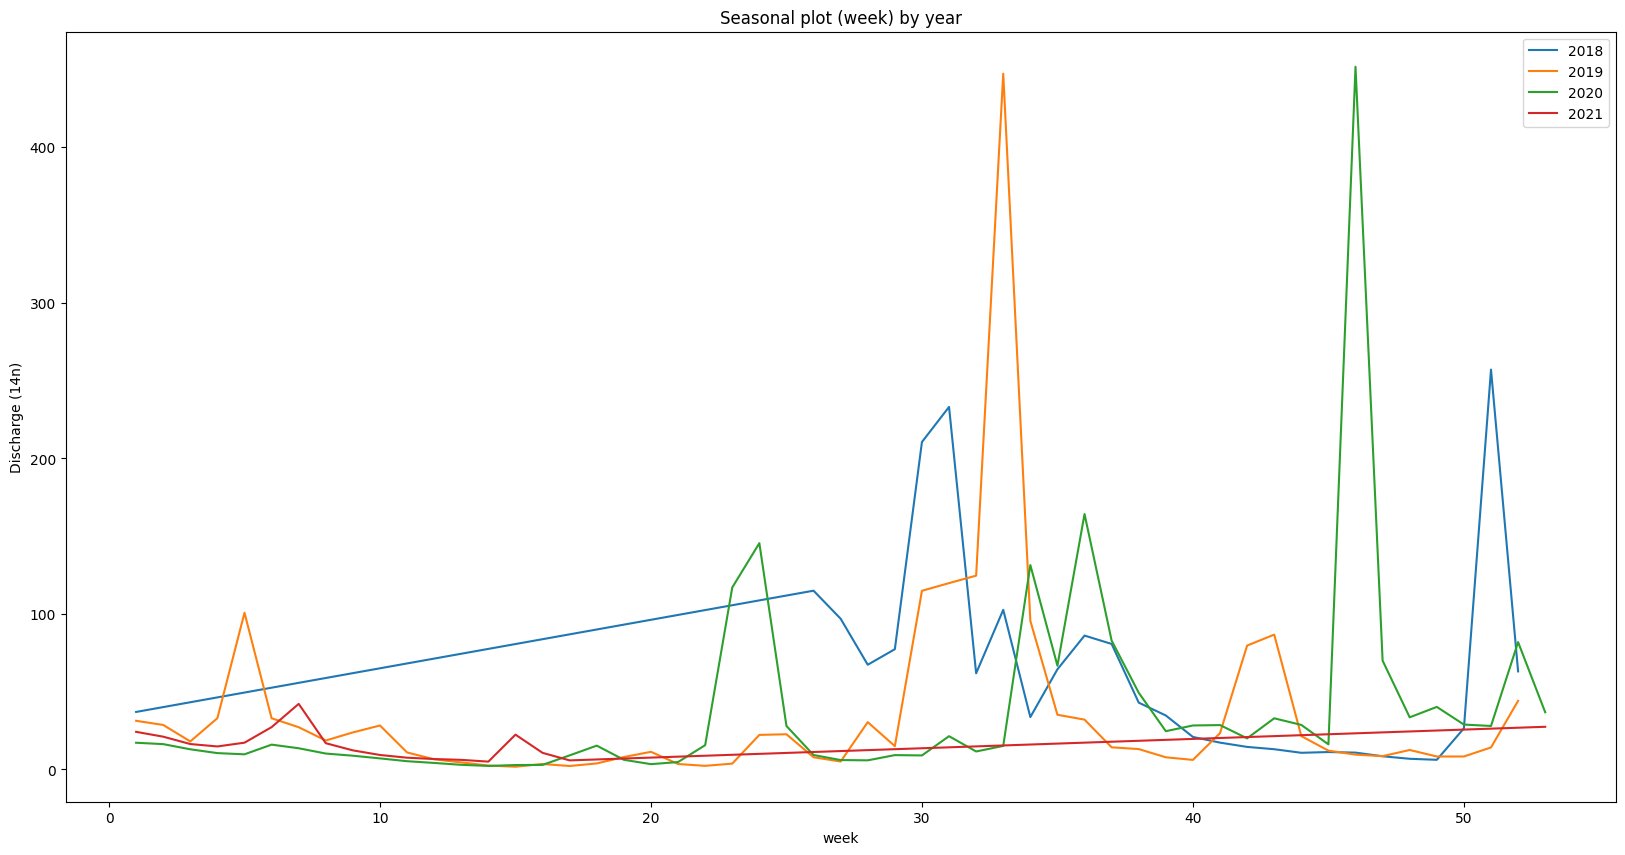

In [ ]:
create_week_seasonal_plot(df=data, series_name='Discharge (14n)')

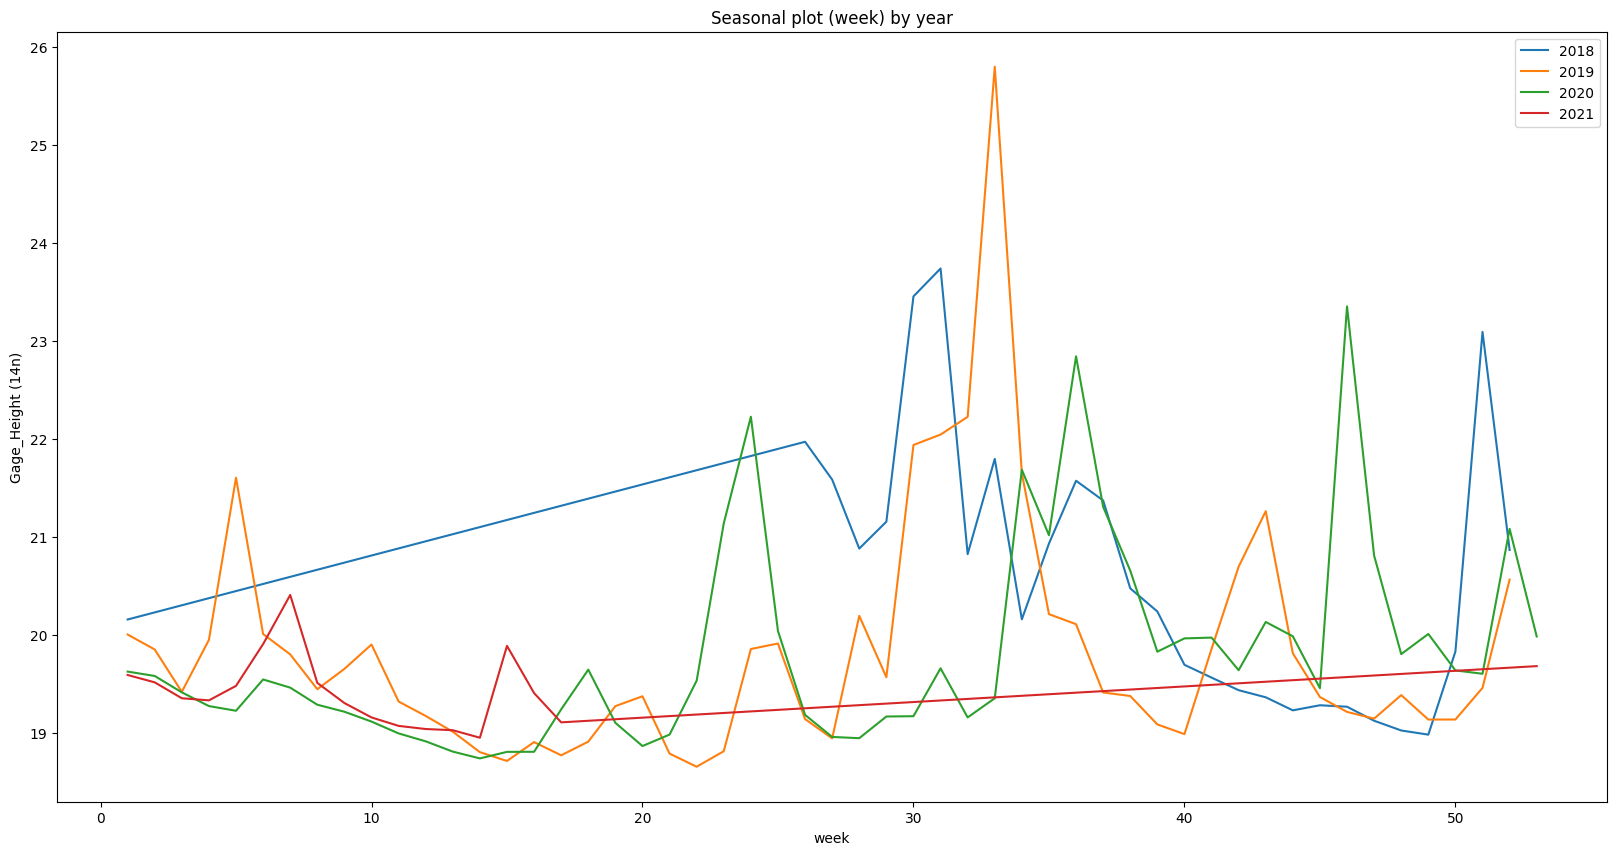

In [ ]:
create_week_seasonal_plot(df=data, series_name='Gage_Height (14n)')

The charts above show nothing really useful for modeling.

Next let's create seasonality plot of hours by year, month, and day. Actually the plots show the average dynamics of the series over hours computed for each year, month, and day combination.

In [ ]:
def create_hour_seasonal_plot(df, series_name, month_names=month_names_list):
    fig = plt.figure(figsize=(12, 8))
    for year in df['year'].unique():
        for month in df['month'].unique():
            for day in df['day'].unique():
                temp_df = df[(df['year']==year) & (df['month']==month) & (df['day']==day)]
                temp_df_grouped = temp_df.groupby('hour', as_index=False)[series_name].mean()
                temp_x = temp_df_grouped['hour']
                temp_y = temp_df_grouped[series_name]
                if len(temp_x) == 0:
                    continue
                plt.subplot(4, 3, month)
                plt.plot(temp_x, temp_y)
                plt.title(month_names[month-1])
                plt.xlabel('hour')
                plt.ylabel(series_name)
    plt.suptitle(f'{series_name}: Seasonal plot (hour) by year, month, and day')
    # plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
    # plt.legend()
    plt.tight_layout()

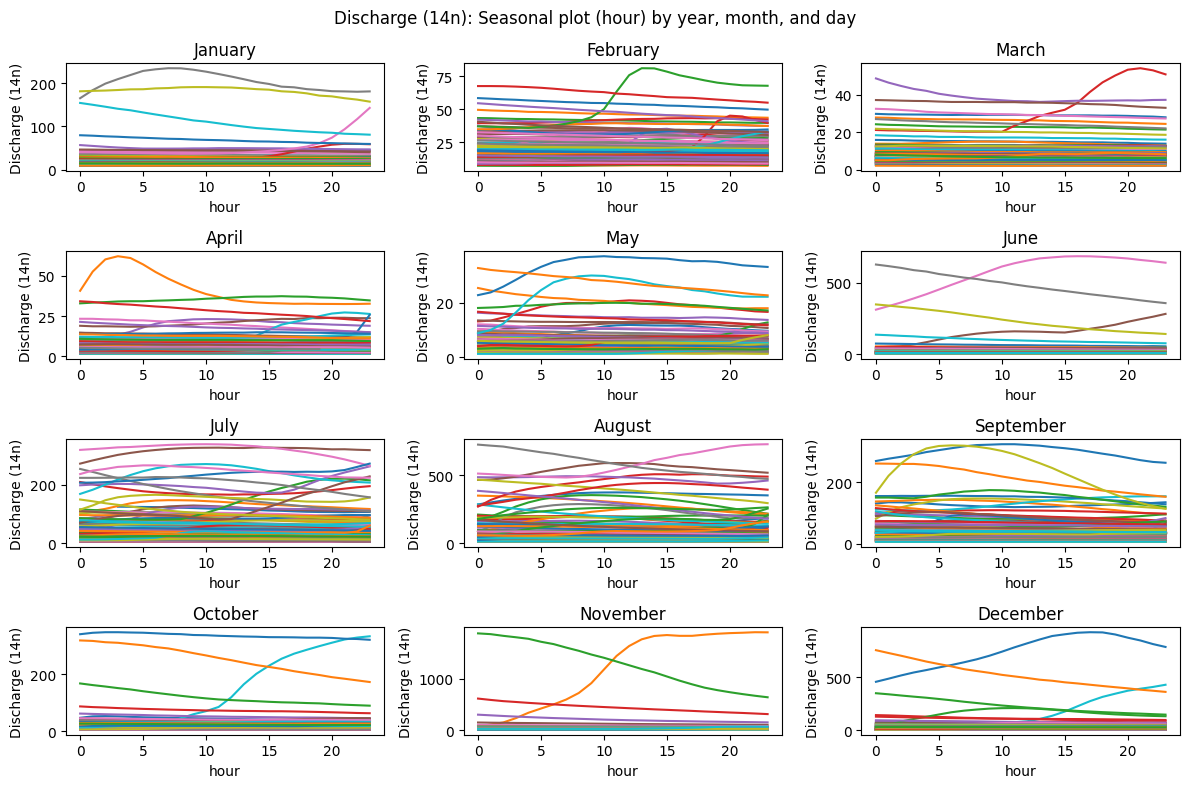

In [ ]:
create_hour_seasonal_plot(df=data, series_name='Discharge (14n)')

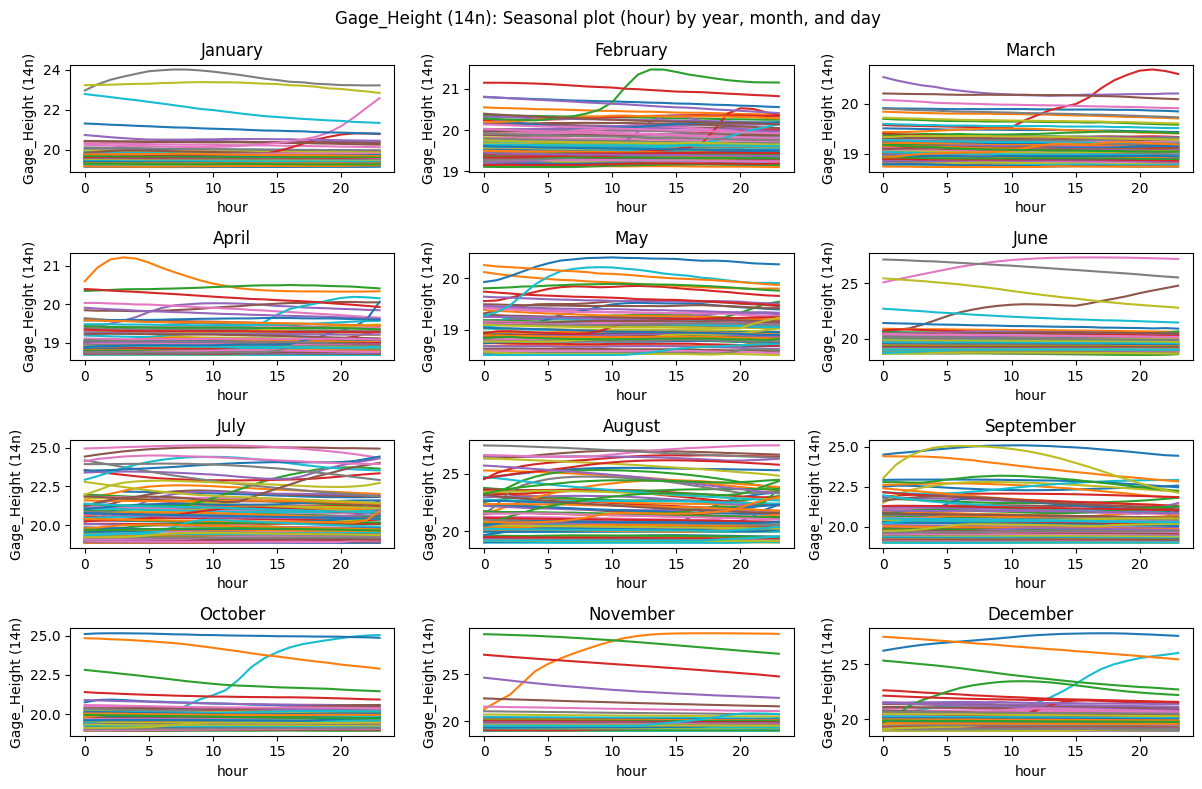

In [ ]:
create_hour_seasonal_plot(df=data, series_name='Gage_Height (14n)')

Again nothing useful can be derived from the charts above.

Creating seasonality plot of month by year. Actually the plots show the average dynamics of the series over months computed for each year.

In [ ]:
def create_month_seasonal_plot(df, series_name):
    for year in df['year'].unique():
        temp_df = df[(df['year']==year)]
        temp_df_grouped = temp_df.groupby('month', as_index=False)[series_name].mean()
        temp_x = temp_df_grouped['month']
        temp_y = temp_df_grouped[series_name]
        if len(temp_x) == 0:
            continue
        plt.plot(temp_x, temp_y, label=str(year))
    plt.title('Seasonal plot (month) by year')
    plt.xlabel('month')
    plt.ylabel(series_name)
    # plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
    plt.legend()
    plt.show()

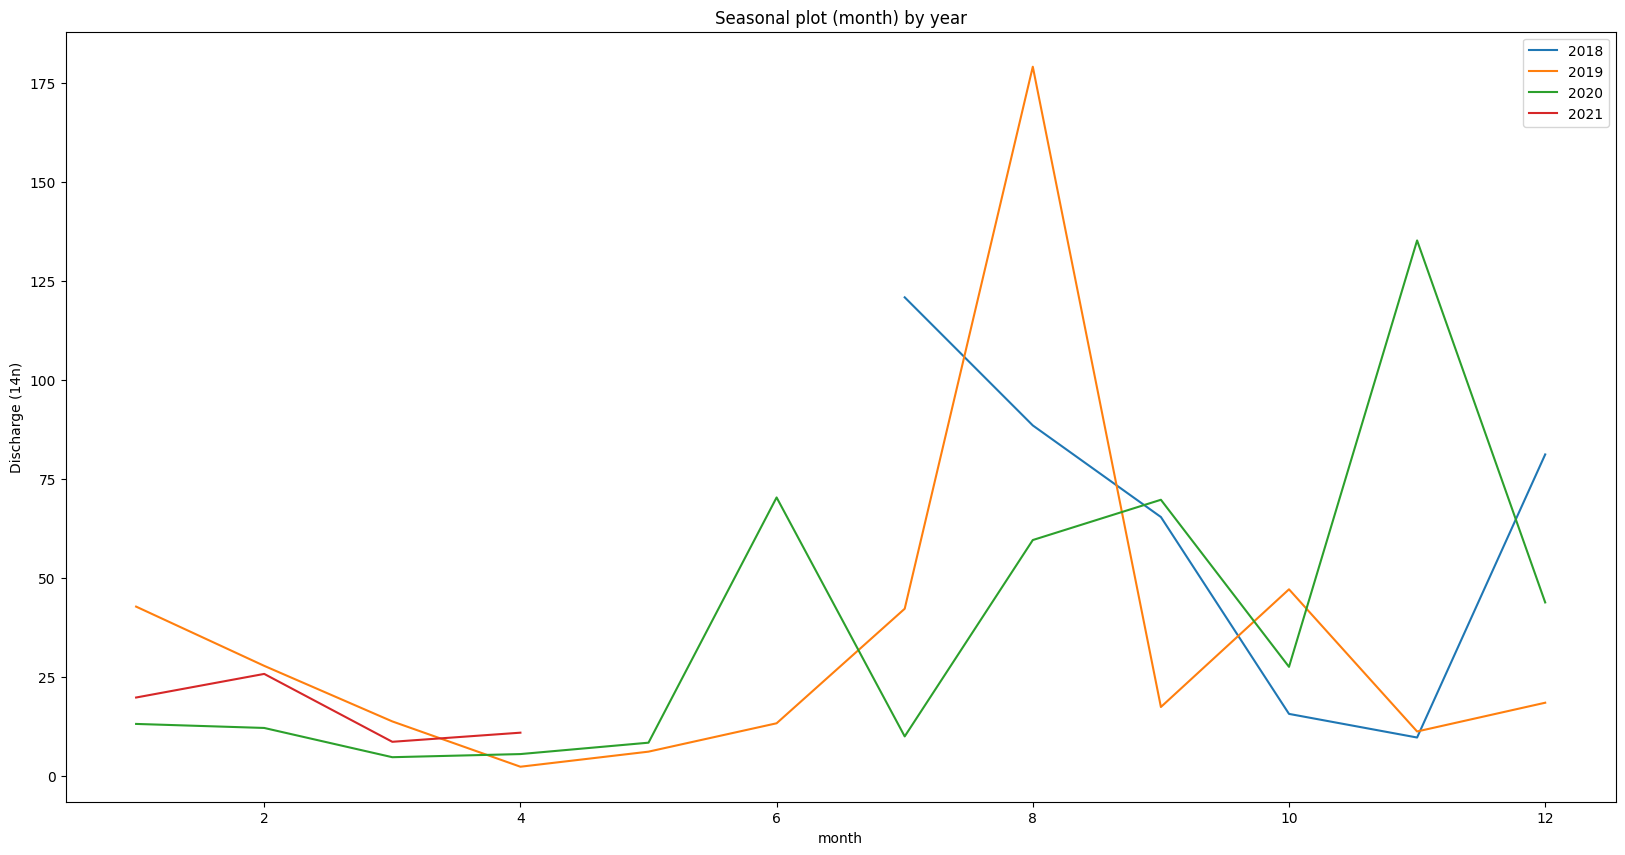

In [ ]:
create_month_seasonal_plot(df=data, series_name='Discharge (14n)')

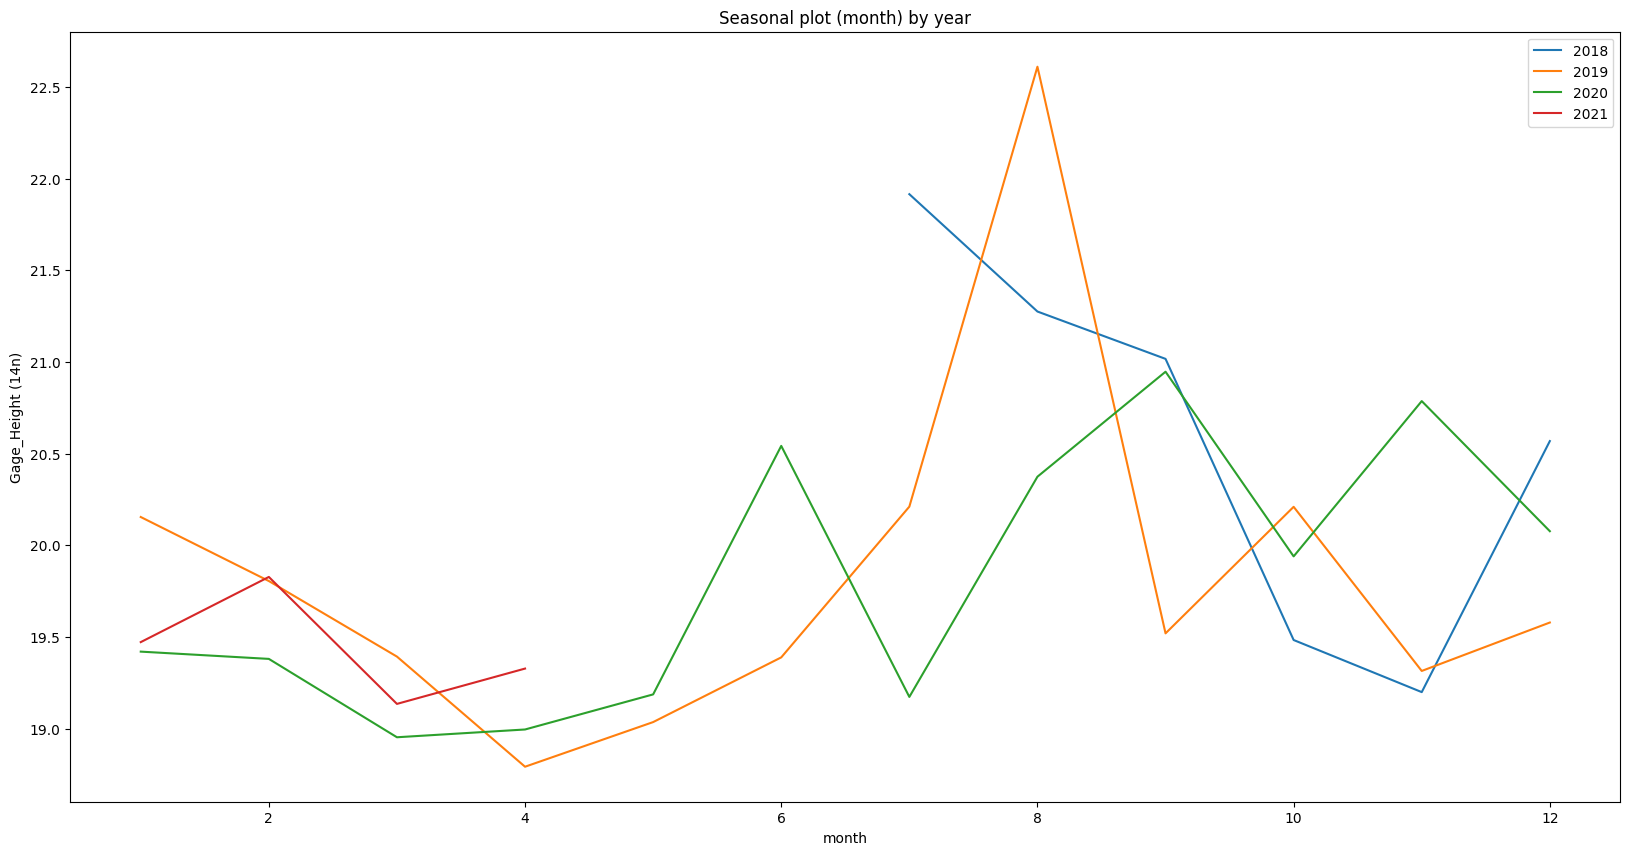

In [ ]:
create_month_seasonal_plot(df=data, series_name='Gage_Height (14n)')

Nothing really useful can be visualized from the charts above.

Let's create seasonality plot of month weeks by year and month. Actually the plots show the average dynamics of the series over weeks of month computed for each year and month pair.

In [ ]:
# month_names_list = list(calendar.month_name)
# month_names_list = [month_str for month_str in month_names_list if month_str!='']

def create_weekofmonth_seasonal_plot(df, series_name, month_names=month_names_list):
    fig = plt.figure(figsize=(12, 8))
    for year in df['year'].unique():
        for month in df['month'].unique():
            temp_df = df[(df['year']==year) & (df['month']==month)]
            temp_df_grouped = temp_df.groupby('weekofmonth', as_index=False)[series_name].mean()
            temp_x = temp_df_grouped['weekofmonth']
            temp_y = temp_df_grouped[series_name]
            if len(temp_x) == 0:
                continue
            plt.subplot(4, 3, month)
            plt.plot(temp_x, temp_y)
            plt.title(month_names[month-1])
            if month in [10, 11, 12]:
                plt.xlabel('week of month')
            # plt.ylabel(series_name)
    plt.suptitle(f'{series_name}: Seasonal plot (weekofmonth) by year and month', y=1.01)
    # plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
    plt.tight_layout()

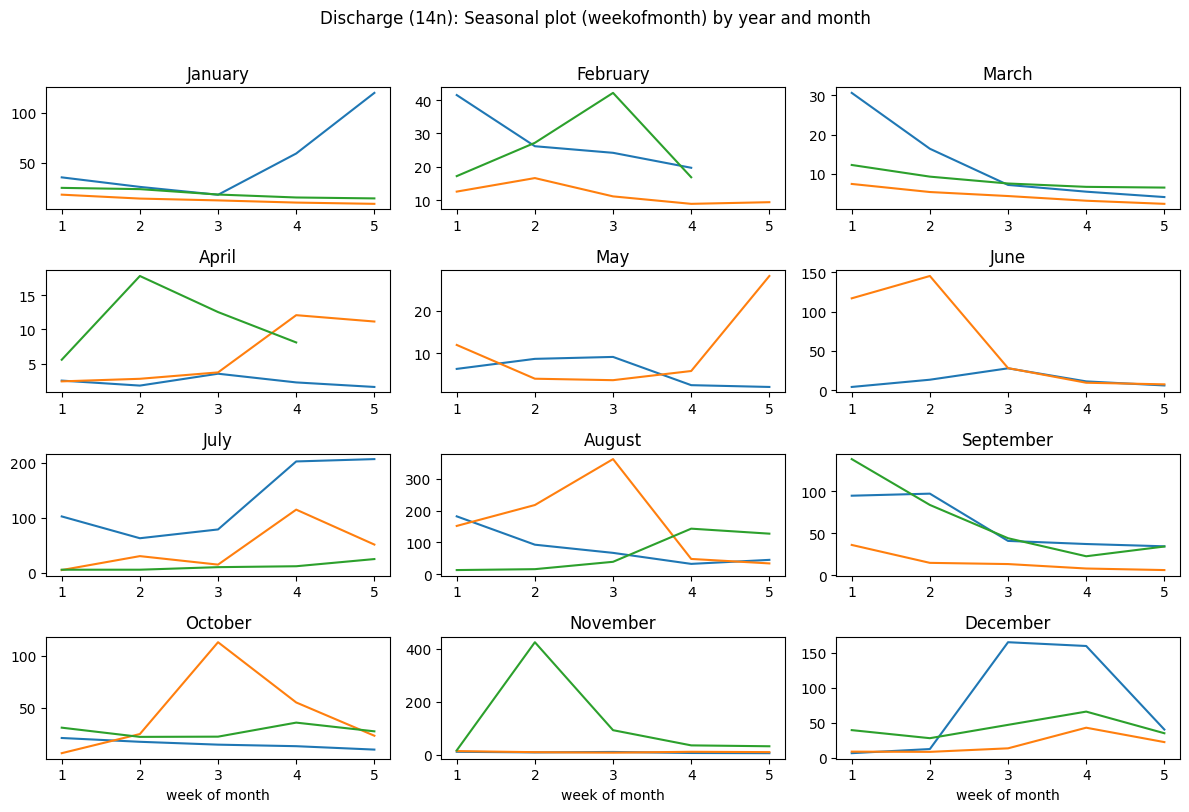

In [ ]:
create_weekofmonth_seasonal_plot(df=data, series_name='Discharge (14n)')

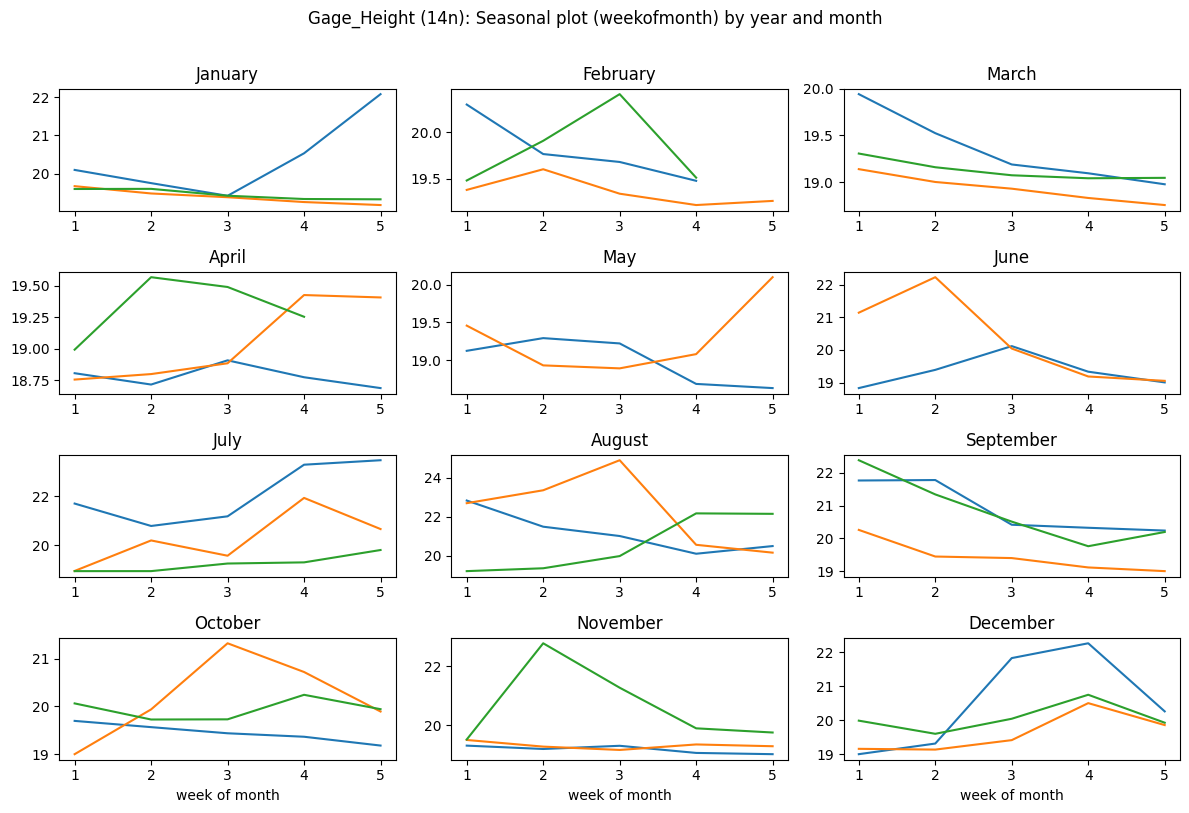

In [ ]:
create_weekofmonth_seasonal_plot(df=data, series_name='Gage_Height (14n)')

The charts above doesn't contain useful info.

Let's create seasonality plot of week days by year and month. Actually the plots show the average dynamics of the series over days of week computed for each year and month pair.

In [ ]:
def create_dayofweek_seasonal_plot_monthly(df, series_name, month_names=month_names_list):
    fig = plt.figure(figsize=(12, 10))
    for year in df['year'].unique():
        for month in df['month'].unique():
            temp_df = df[(df['year']==year) & (df['month']==month)]
            temp_df_grouped = temp_df.groupby('dayofweek', as_index=False)[series_name].mean()
            temp_x = temp_df_grouped['dayofweek']
            temp_y = temp_df_grouped[series_name]
            if len(temp_x) == 0:
                continue
            plt.subplot(4, 3, month)
            plt.plot(temp_x, temp_y)
            plt.title(month_names[month-1])
            # if month in [10, 11, 12]:
            plt.xlabel('day of week')
            plt.xticks(np.arange(7), list(calendar.day_name), rotation=45)
            # plt.ylabel(series_name)
    plt.suptitle(f'{series_name}: Seasonal plot (dayofweek) by year and month', y=1.01)
    plt.tight_layout()

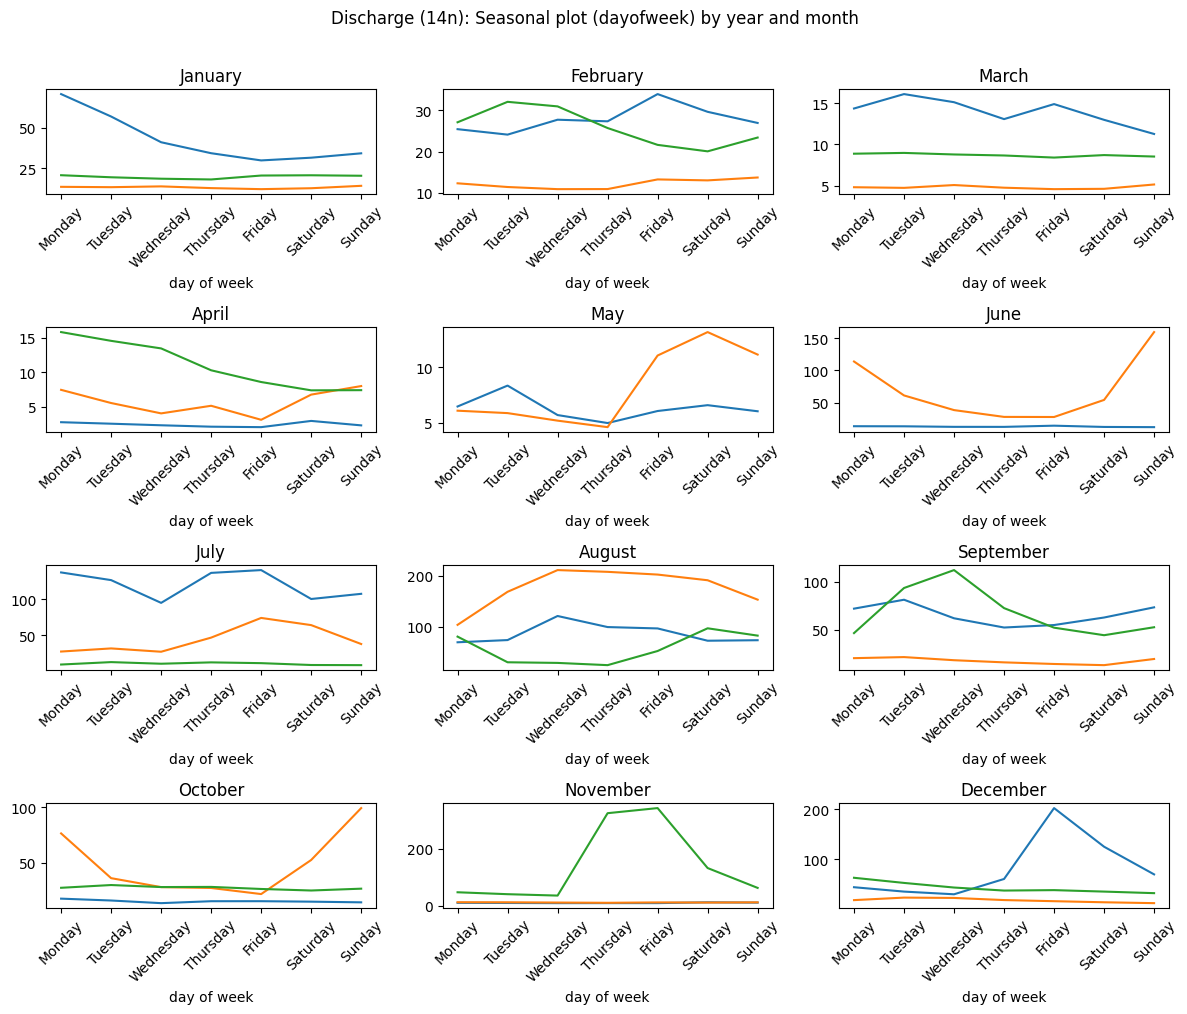

In [ ]:
create_dayofweek_seasonal_plot_monthly(df=data, series_name='Discharge (14n)')

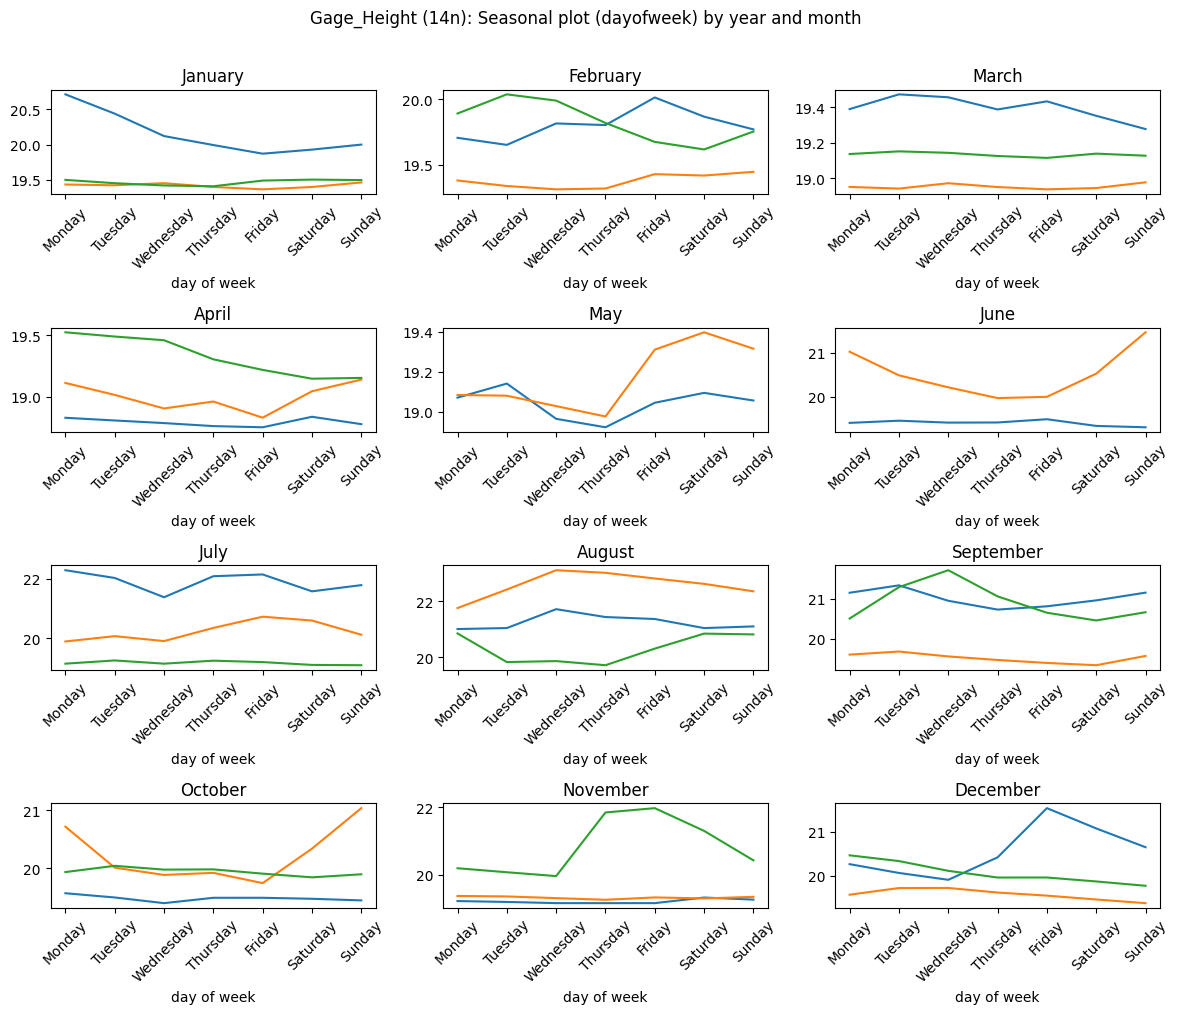

In [ ]:
create_dayofweek_seasonal_plot_monthly(df=data, series_name='Gage_Height (14n)')

Nothing useful can be observed from the charts above.

Plotting the series by year

In [ ]:
month_day_list = list(data[data['year']==2019]['DateTime (20d)'].dt.strftime('%m-%d %H:%M:%S'))
minute_map_dict = {month_day_list[i]: i+1 for i in range(len(month_day_list))}

def create_year_plot(
    df, series_name,
    map_dict=minute_map_dict,
    month_day_list=month_day_list,
    month_list=month_names_list
):
    for year in df['year'].unique():
        temp_df = df[(df['year']==year)]
        temp_x = temp_df['DateTime (20d)'].dt.strftime('%m-%d %H:%M:%S').map(map_dict)
        temp_y = temp_df[series_name]
        if len(temp_x) == 0:
            continue
        plt.plot(temp_x, temp_y, label=str(year))
    plt.title(f'{series_name} by year')
    # plt.xlabel('datetime')
    plt.ylabel(series_name)
    # for i in range(1, 13):
    #     month_text = f'0{i}' if i < 10 else f'{i}'
        # plt.axvline(map_dict[f'{month_text}-01 00:00:00'], color='k', linestyle=':')
    # plt.xticks(np.arange(len(map_dict)), month_day_list, rotation=45)
    x_points = [
        map_dict[f'0{i}-01 00:00:00']
        if i < 10 else map_dict[f'{i}-01 00:00:00']
        for i in range(1, 13)
    ]
    plt.xticks(x_points, month_list, rotation=45)
    plt.legend()
    plt.show()

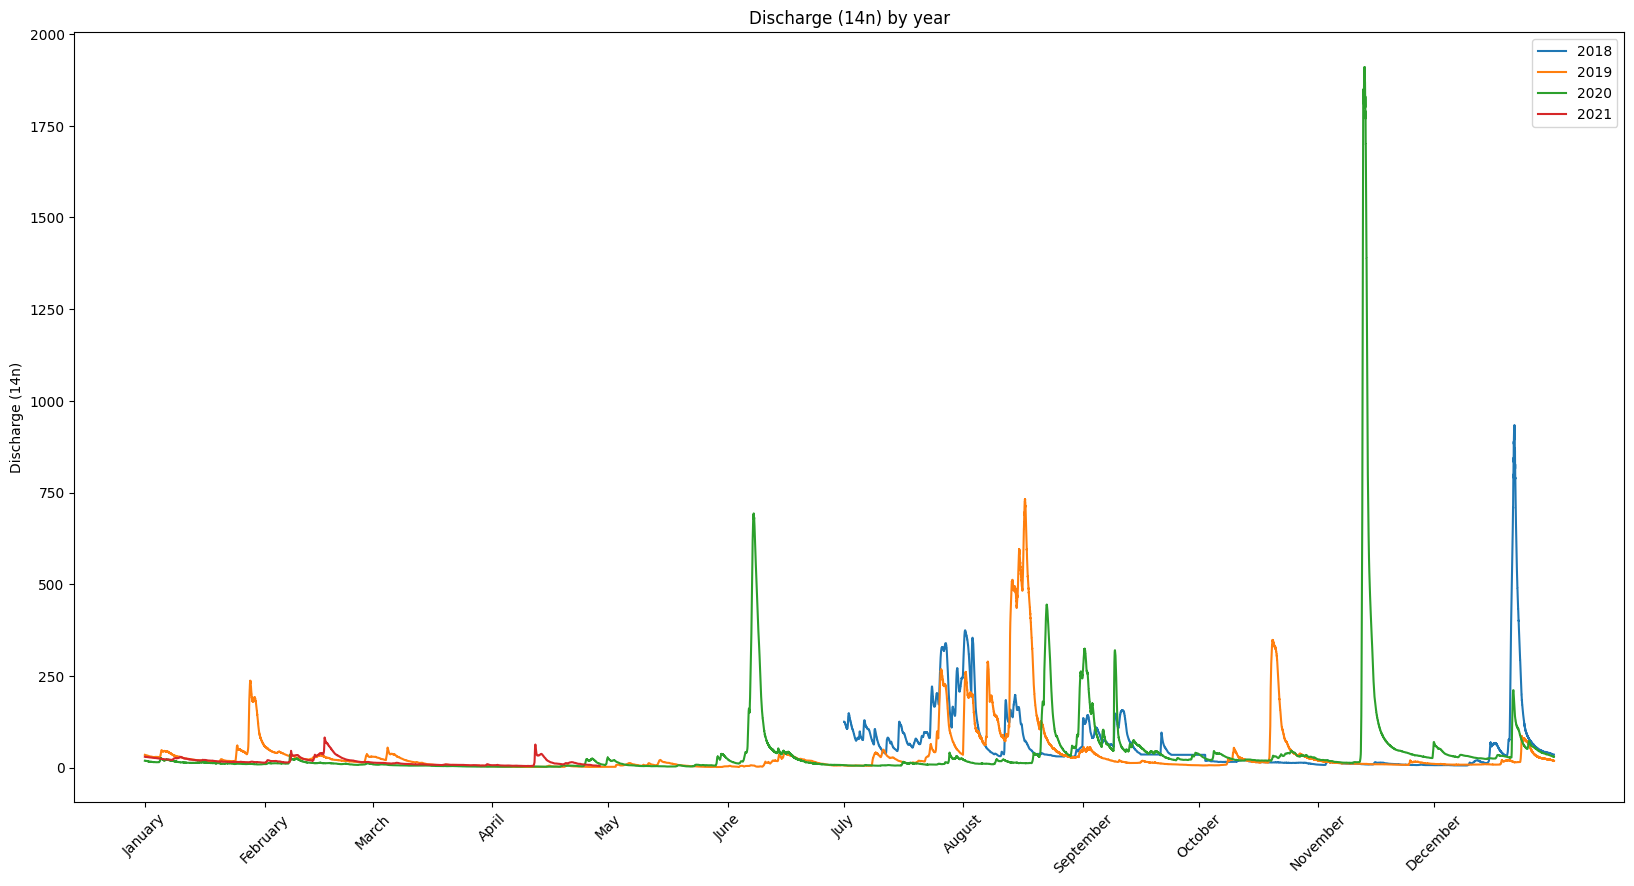

In [ ]:
create_year_plot(df=data, series_name='Discharge (14n)')

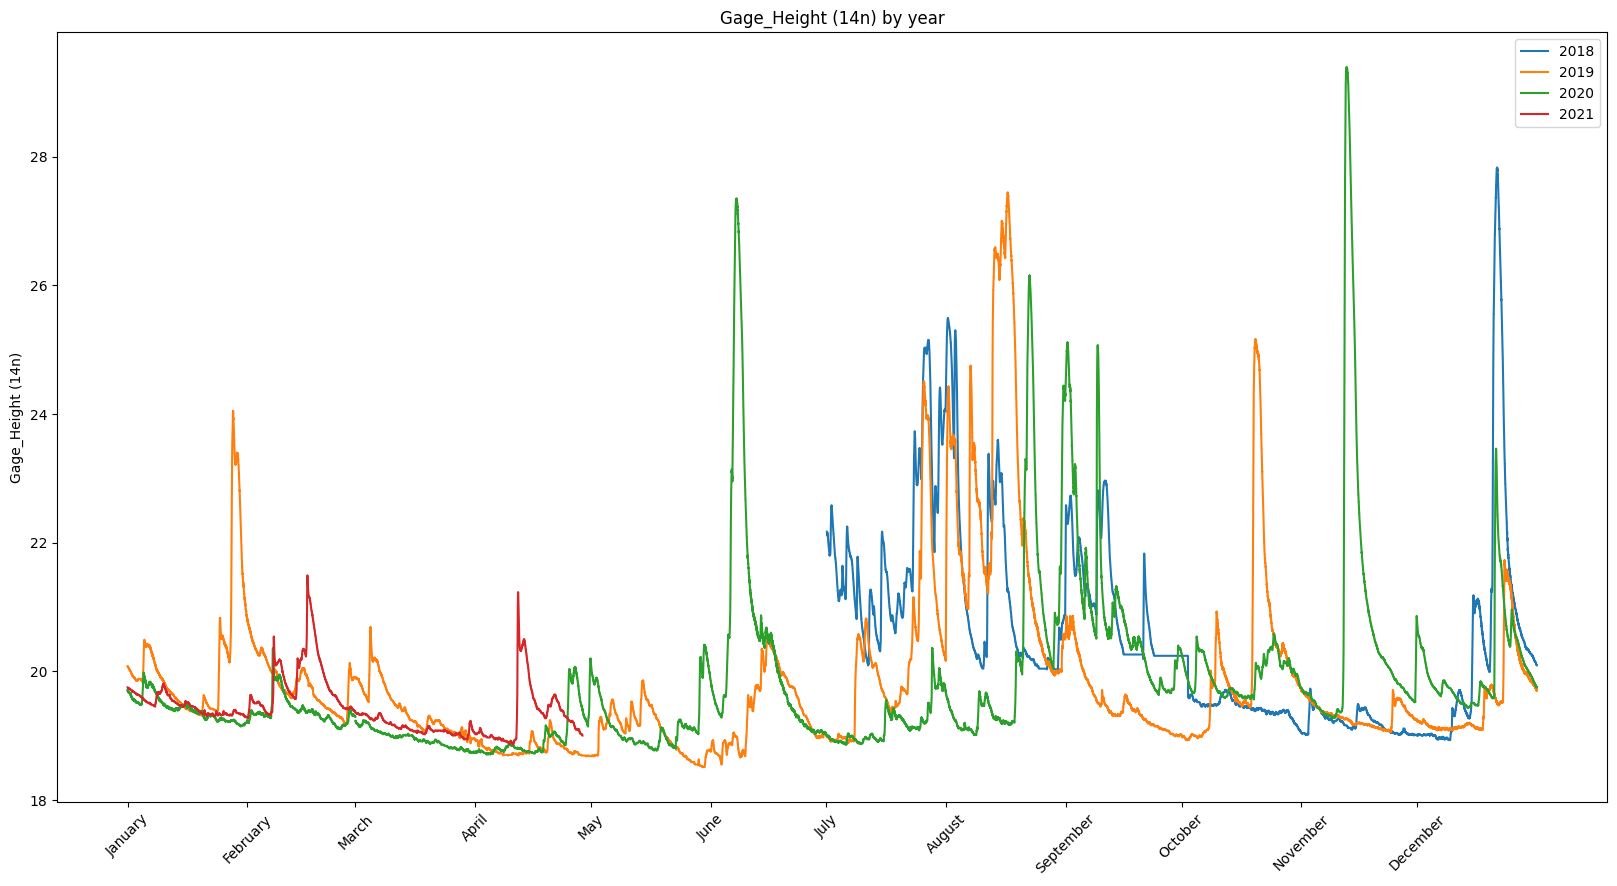

In [ ]:
create_year_plot(df=data, series_name='Gage_Height (14n)')

The charts above doesn't contain anything to drive our attention in terms of feature engineering.

Let's show average (actually median is used) monthly dynamics for each series.

In [ ]:
def create_average_monthly_plot(df, series_name, month_list=month_names_list):
    temp_df = df.groupby('month', as_index=False)[series_name].median()
    temp_x = temp_df['month']
    temp_y = temp_df[series_name]
    plt.plot(temp_x, temp_y)
    plt.title(f'{series_name} average monthly dynamics')
    # plt.xlabel('datetime')
    plt.ylabel(series_name)
    plt.xticks(np.arange(1, 13), month_list, rotation=45)
    plt.show()

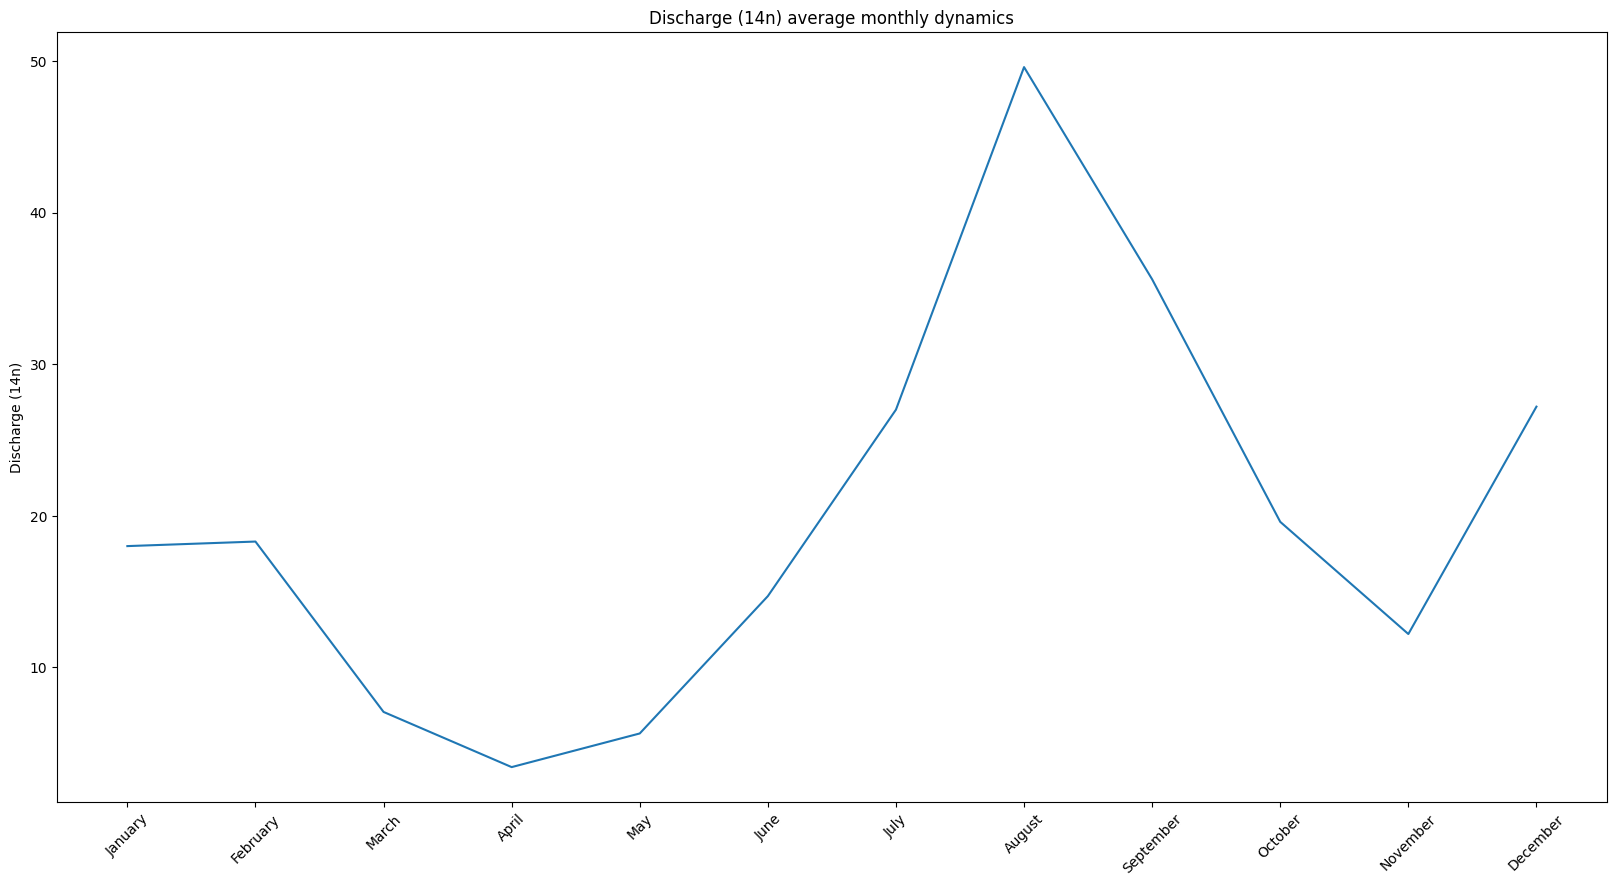

In [ ]:
create_average_monthly_plot(df=data, series_name='Discharge (14n)')

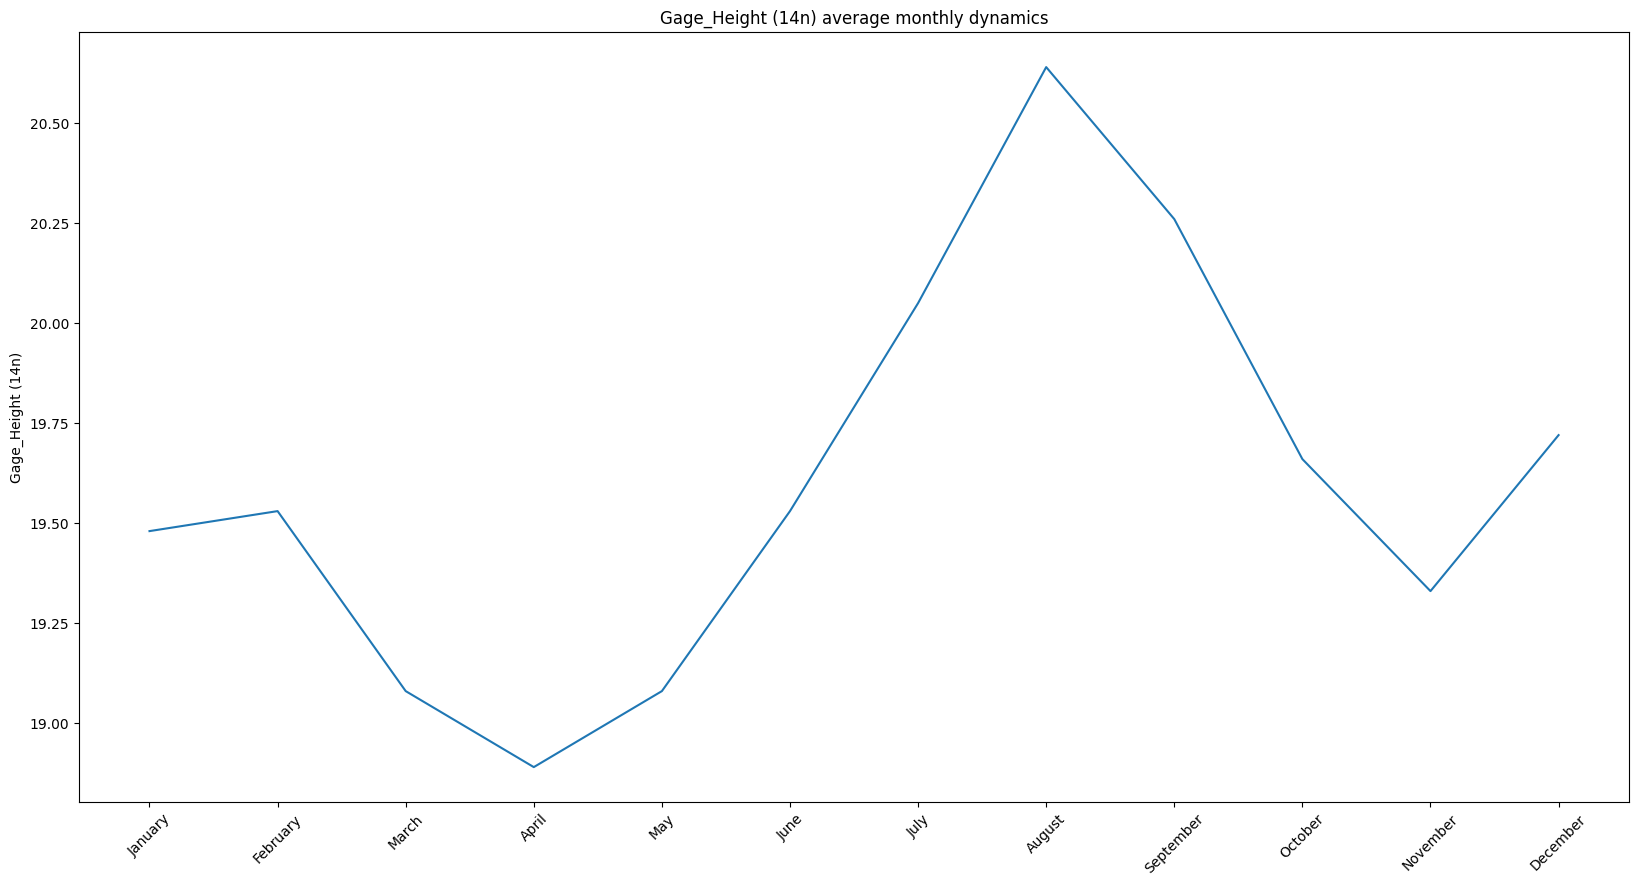

In [ ]:
create_average_monthly_plot(df=data, series_name='Gage_Height (14n)')

Actually the plots above show the seasonality present in the series and it can be helpful to include the average values of the series as features.

Let's plot a periodogram to derive important Fourier series related to the data.

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = 365 * 4 * 24 #pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

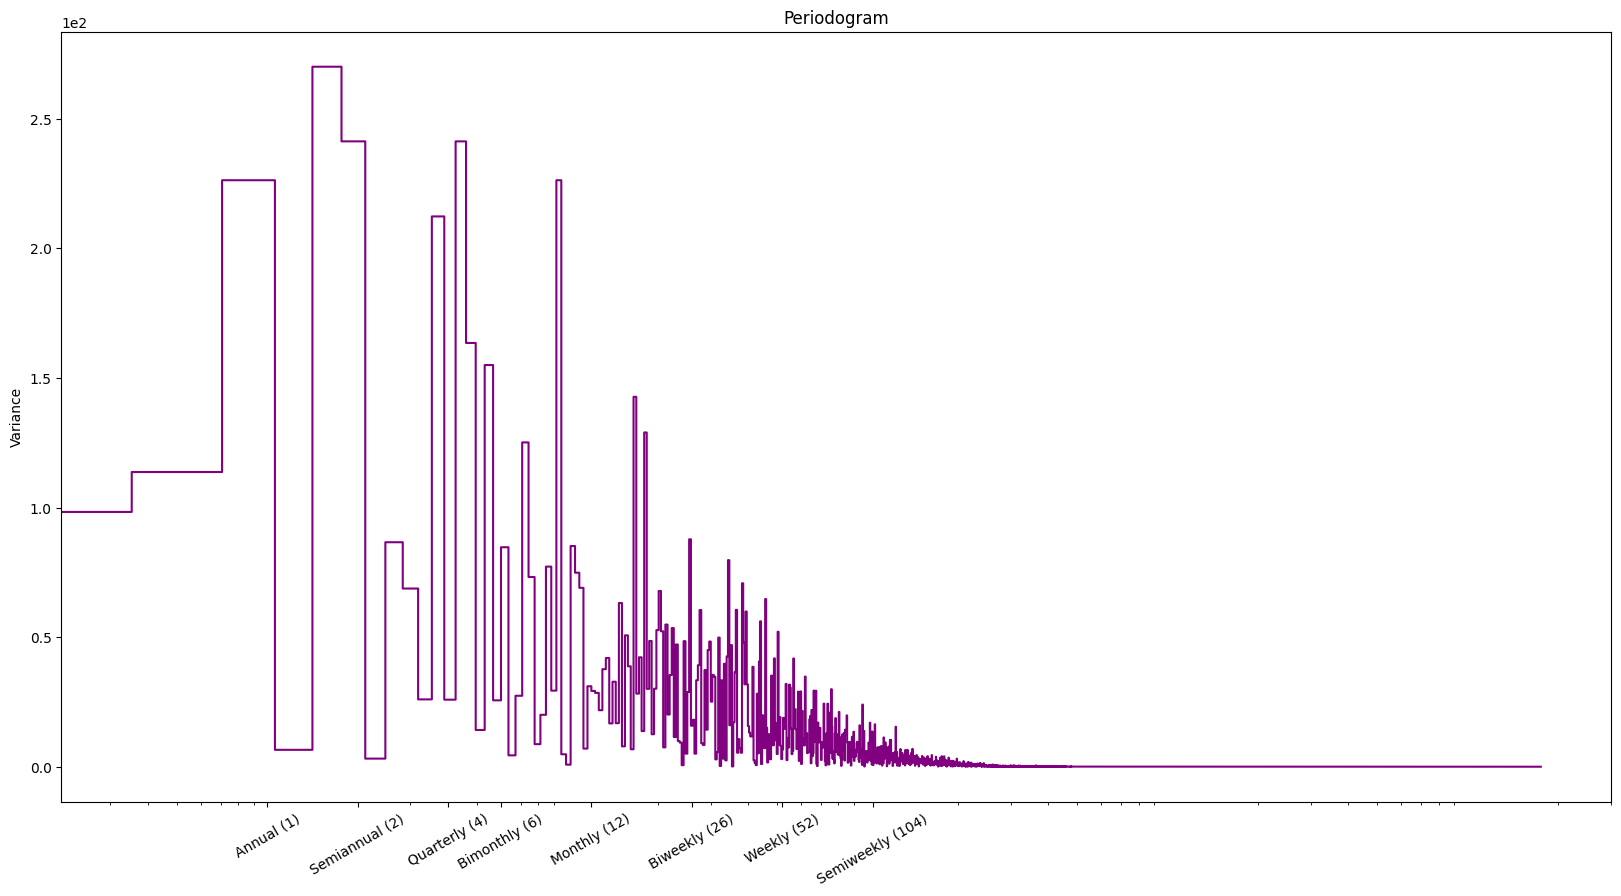

In [ ]:
plot_periodogram(data['Discharge (14n)']);

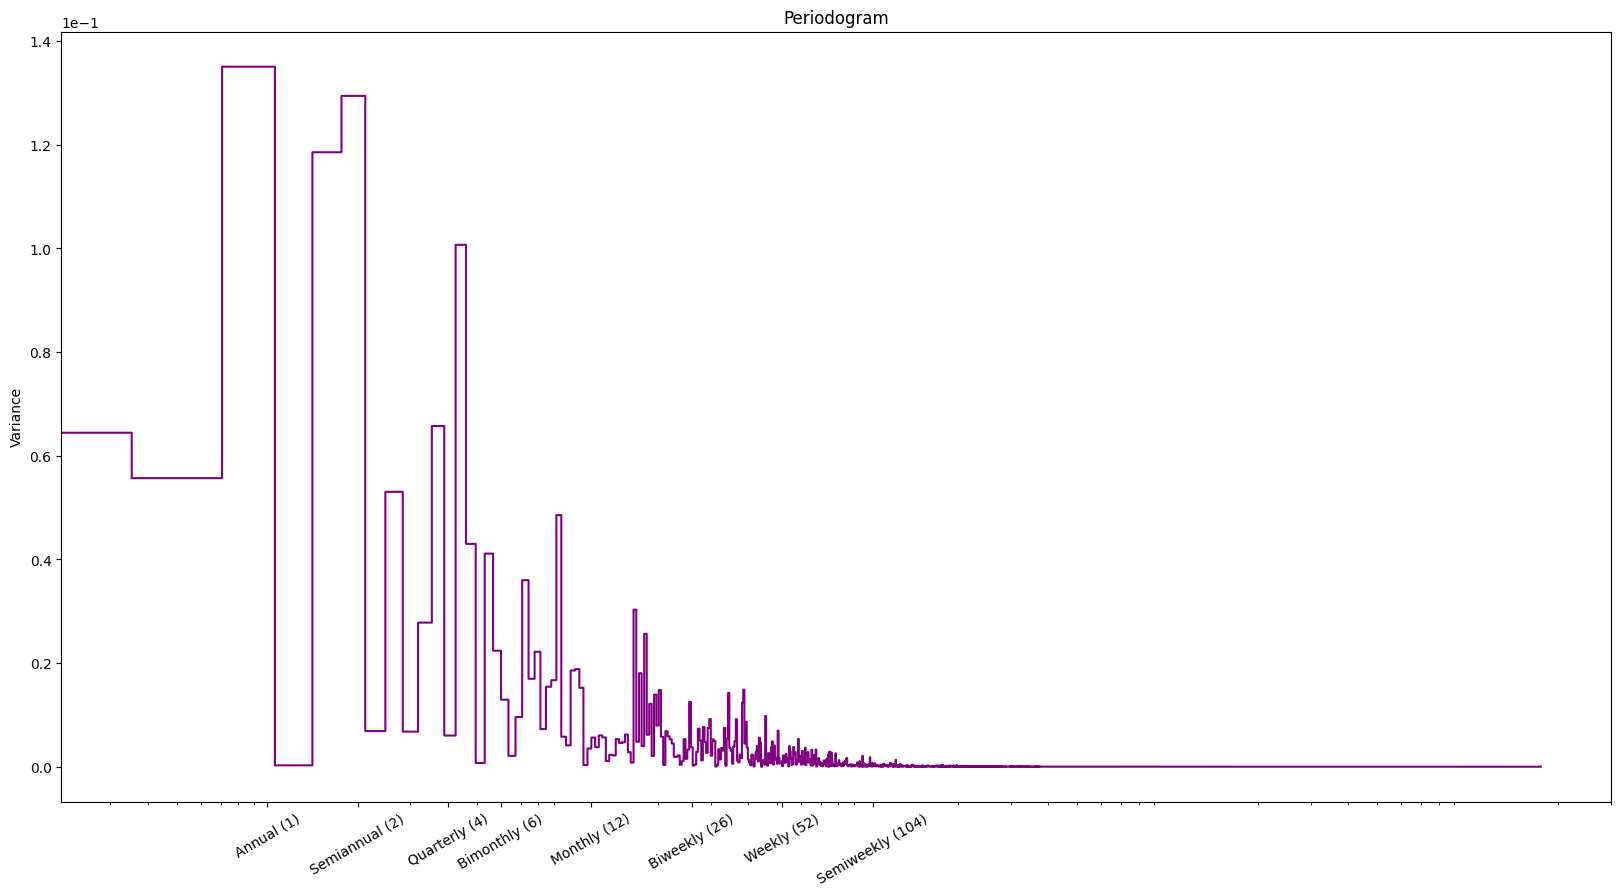

In [ ]:
plot_periodogram(data['Gage_Height (14n)']);

The periodograms above start dropping between 6 and 12 (bimonthly and monthly frequencies respectively) x values. So let's take 10 as a number of periods to derive the Fourier series.We'll do that a little bit later. Now let's plot partial autocorrelation functions for the series.

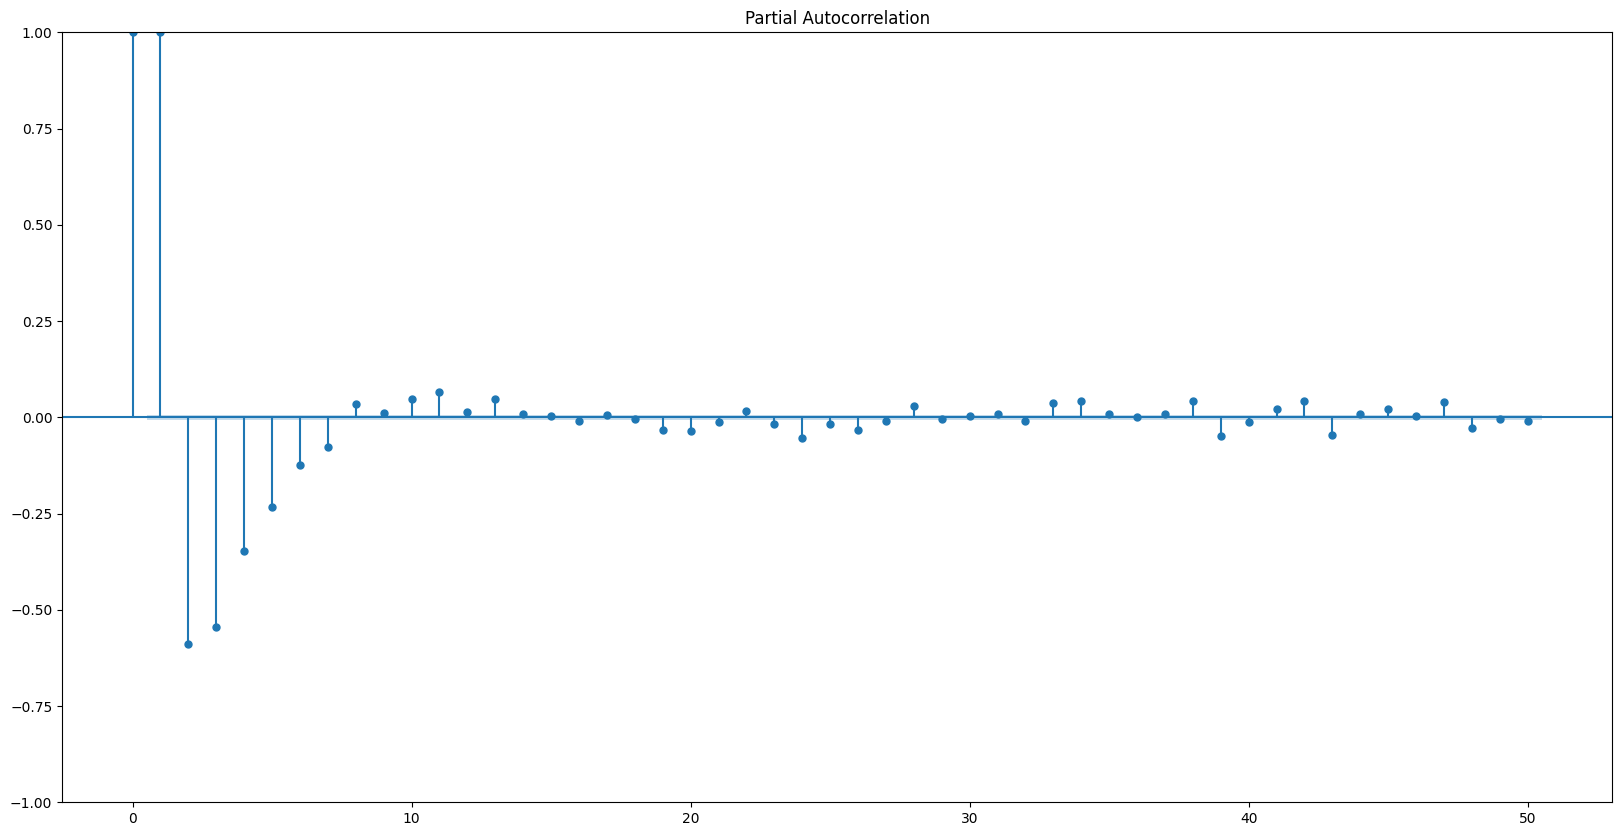

In [ ]:
plot_pacf(data['Discharge (14n)']);

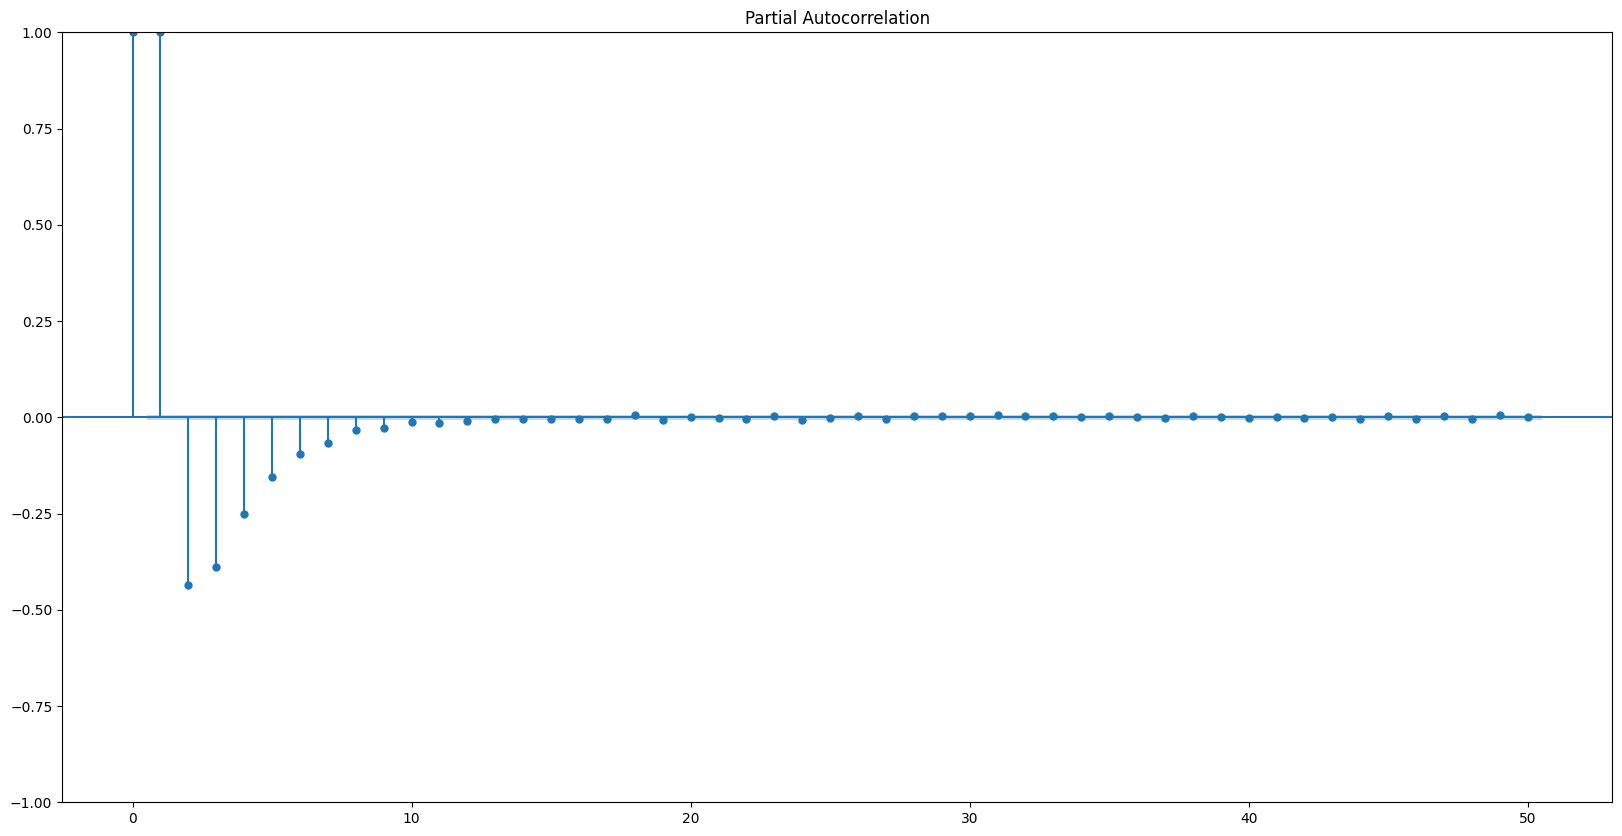

In [ ]:
plot_pacf(data['Gage_Height (14n)']);

Judging by the charts above 8 lags is enough to take as features. Let's plot lag plots to visualize it.

In [ ]:
def create_lag_plots(df, series_name, n_lag=8):

    n_rows = int((n_lag-n_lag % 3)/3)
    if n_lag % 3 != 0:
        n_rows += 1

    fig = plt.figure(figsize=(12, 8))
    for i_lag in range(1, n_lag+1):
        temp_df = df.copy()
        temp_df['lag'] = temp_df[series_name].shift(i_lag)
        plt.subplot(n_rows, 3, i_lag)
        plt.scatter(temp_df[series_name], temp_df['lag'])
        plt.xlabel(f"lag {i_lag}")
        plt.ylabel('series')
    plt.suptitle(f'{series_name}: lag plots', y=1.01)
    plt.tight_layout()

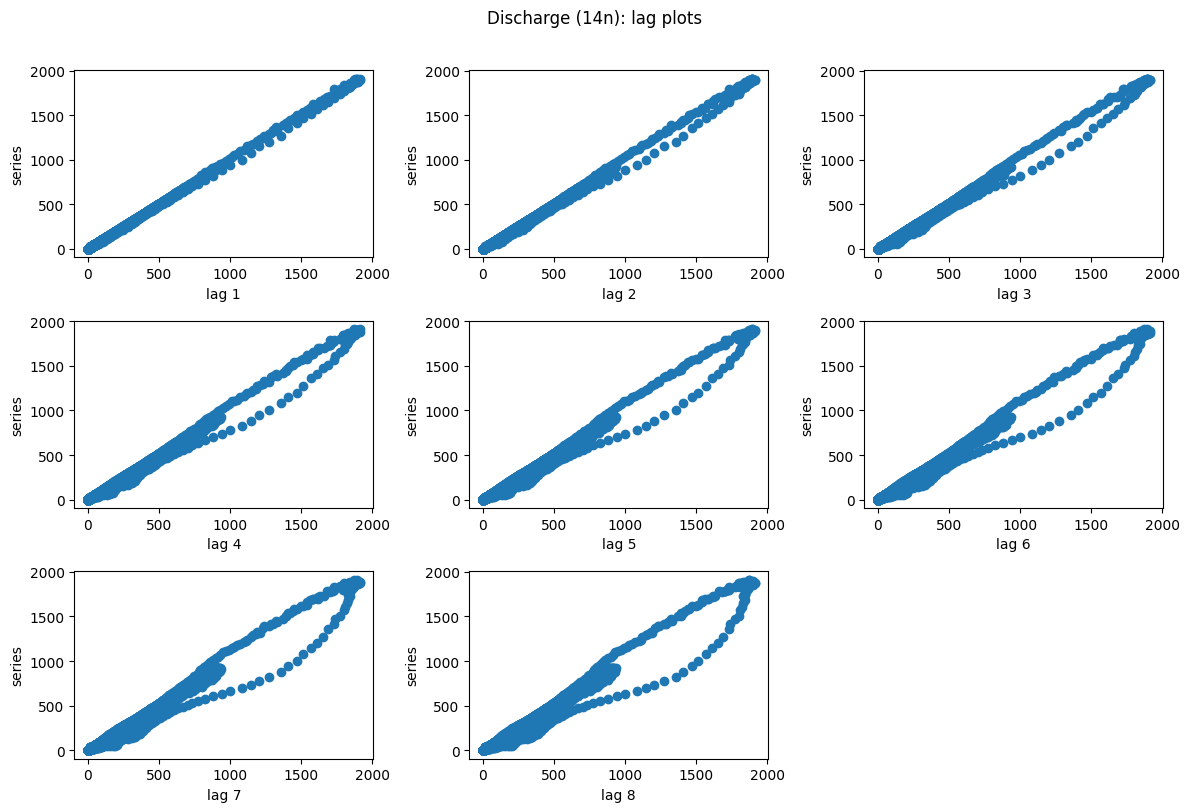

In [ ]:
create_lag_plots(data, 'Discharge (14n)')

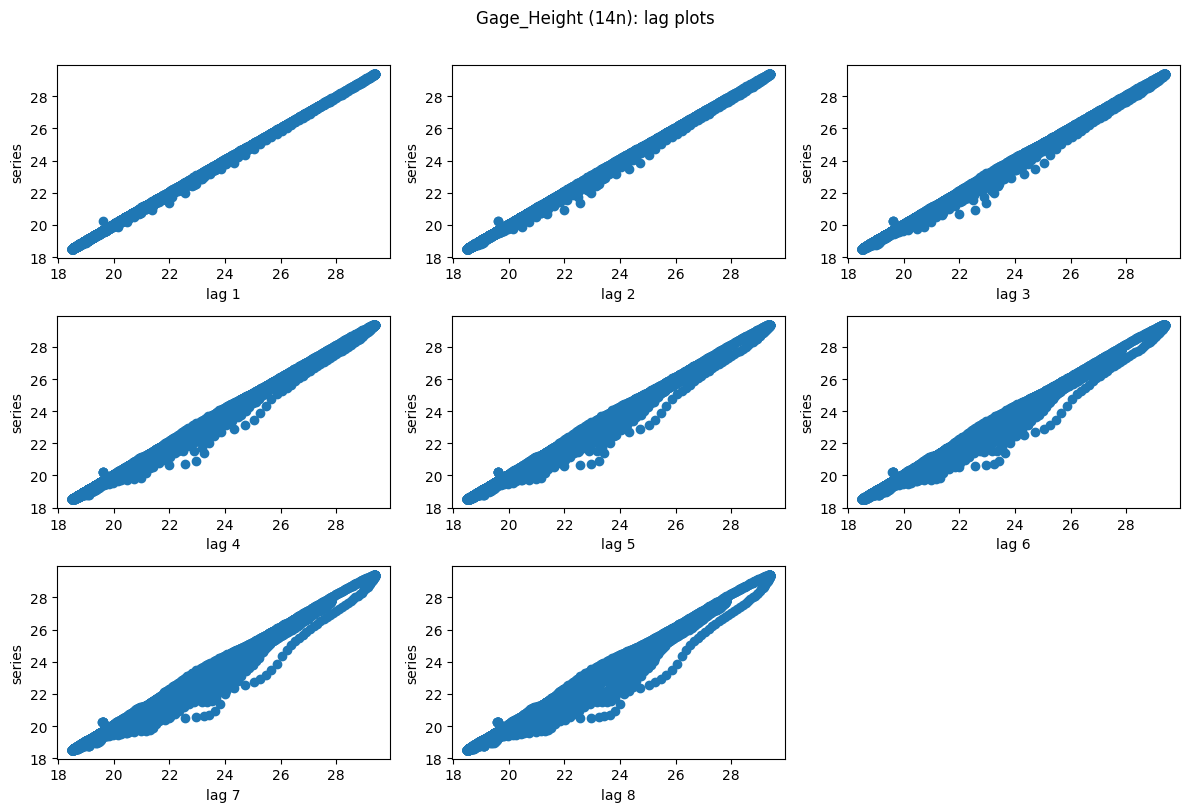

In [ ]:
create_lag_plots(data, 'Gage_Height (14n)')

So the charts above show that at lag 1 the dependency is more linear compared to the other lags. we'll also include 8 lags as features.

Let's split the data into the train and test sets. For test set we will use the last 35040 (365 * 24 * 4) datapoints. The rest will constitute the train set. We also need to create the features. So let's do that too. Please take into account that the period number of Fourier series has been decreased to 4 during experimenting despite the fact that initially 10 was selected in feature engineering section. Moreover interquantile range by month is added as a feature which was not discusssed previously.

In [ ]:
# creating dummy features out dayofweek and merging with the data
dayofweek_dummy = pd.get_dummies(data['dayofweek'], drop_first=True, prefix='day')
data = pd.concat([data, dayofweek_dummy], axis=1)

# setting some parameters
N_LAGS = 8 # number of lags
FT_PERIODS = 5 # periods for Fourier series

# creating lag features
for i in range(1, N_LAGS+1):
    data[f'lag{i}_discharge'] = data['Discharge (14n)'].shift(i)
    data[f'lag{i}_gage'] = data['Gage_Height (14n)'].shift(i)

# removing rows containing missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# dropping some columns from the data
data.drop(
    columns=[
        'time_step2', 'time_step3', 'year',
        'week', 'hour', 'day',
        'weekofmonth', 'dayofweek'
    ],
    inplace=True
)

# conducting the train-test split
train = data.iloc[:-35040].copy().reset_index(drop=True)
test = data.iloc[-35040:].copy().reset_index(drop=True)

# creating a dictionary for median by month and the series based on train set
monthly_median_map = train.groupby('month')[
    ['Discharge (14n)', 'Gage_Height (14n)']
].median().to_dict()

# mapping the median monthly values of the series to train and test sets
train['discharge_median'] = train['month'].map(monthly_median_map['Discharge (14n)'])
train['gage_median'] = train['month'].map(monthly_median_map['Gage_Height (14n)'])

test['discharge_median'] = test['month'].map(monthly_median_map['Discharge (14n)'])
test['gage_median'] = test['month'].map(monthly_median_map['Gage_Height (14n)'])

# creating a dictionary for iterquantile range by month and the series based on train set
monthly_iqr_map = train.groupby('month')[
    ['Discharge (14n)', 'Gage_Height (14n)']
].agg(iqr).to_dict()

# mapping the interquantile range monthly values of the series to train and test sets
train['discharge_iqr'] = train['month'].map(monthly_iqr_map['Discharge (14n)'])
train['gage_iqr'] = train['month'].map(monthly_iqr_map['Gage_Height (14n)'])

test['discharge_iqr'] = test['month'].map(monthly_iqr_map['Discharge (14n)'])
test['gage_iqr'] = test['month'].map(monthly_iqr_map['Gage_Height (14n)'])

train.drop(columns='month', inplace=True)
test.drop(columns='month', inplace=True)

# # creating a dictionary for standard deviation by month and the series based on train set
# monthly_std_map = train.groupby('month')[
#     ['Discharge (14n)', 'Gage_Height (14n)']
# ].std().to_dict()

# # mapping the standard deviation monthly values of the series to train and test sets
# train['discharge_std'] = train['month'].map(monthly_std_map['Discharge (14n)'])
# train['gage_std'] = train['month'].map(monthly_std_map['Gage_Height (14n)'])
# train.drop(columns='month', inplace=True)

# test['discharge_std'] = test['month'].map(monthly_std_map['Discharge (14n)'])
# test['gage_std'] = test['month'].map(monthly_std_map['Gage_Height (14n)'])
# test.drop(columns='month', inplace=True)

# creating a dataframe to assign features for 5 years ahead prediction
prediction_features = pd.DataFrame()
n_15minutes_prediction = 4 * 24 * 365 * 5
prediction_features['DateTime (20d)'] = pd.date_range(
    start=(
        data.iloc[-1]['DateTime (20d)']+timedelta(minutes=15)
    ).strftime('%Y-%m-%d %H:%M:%S'),
    periods=n_15minutes_prediction,
    freq='15T'
)
prediction_features['time_step'] = np.arange(
    data.shape[0]+1,
    data.shape[0] + n_15minutes_prediction+1
)
# prediction_features.set_index('DateTime (20d)', inplace=True)
prediction_features['month'] = prediction_features['DateTime (20d)'].dt.month
prediction_features['discharge_median'] = prediction_features['month'].map(
    monthly_median_map['Discharge (14n)']
)
prediction_features['gage_median'] = prediction_features['month'].map(
    monthly_median_map['Gage_Height (14n)']
)
prediction_features['discharge_iqr'] = prediction_features['month'].map(
    monthly_iqr_map['Discharge (14n)']
)
prediction_features['gage_iqr'] = prediction_features['month'].map(
    monthly_iqr_map['Gage_Height (14n)']
)
# prediction_features['discharge_std'] = prediction_features['month'].map(
#     monthly_std_map['Discharge (14n)']
# )
# prediction_features['gage_std'] = prediction_features['month'].map(
#     monthly_std_map['Gage_Height (14n)']
# )
prediction_features['dayofweek'] = prediction_features['DateTime (20d)'].dt.dayofweek
prediction_dayofweek_dummy = pd.get_dummies(
    prediction_features['dayofweek'],
    drop_first=True,
    prefix='day'
)
prediction_features = pd.concat(
    [
        prediction_features,
        prediction_dayofweek_dummy
    ],
    axis=1
)
prediction_features.drop(columns=['month', 'dayofweek'], inplace=True)

# creating Fourier series and merging with train, test, and prediction sets
cal_fourier_gen = CalendarFourier("A", FT_PERIODS)
index = pd.DatetimeIndex(train['DateTime (20d)'])
fourier_series_train = cal_fourier_gen.in_sample(index)
fourier_series_train.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fourier_series_train.reset_index(inplace=True)
fourier_series_train.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

# train.set_index('DateTime (20d)', inplace=True)
# train = pd.concat([train, fourier_series_train], axis=0)
train = pd.merge(train, fourier_series_train, on='DateTime (20d)')

out_of_sample_periods = 35040 + n_15minutes_prediction
fourier_series_test = cal_fourier_gen.out_of_sample(
    steps=out_of_sample_periods,
    index=pd.date_range(
        start=train.iloc[0]['DateTime (20d)'].strftime('%Y-%m-%d %H:%M:%S'),
        periods=train.shape[0],
        freq='15T'
    )
)
fourier_series_test.columns = [
    f'sin{int(i/2)+1}'
    if i%2==0 else f'cos{int(i/2)+1}'
    for i in range(FT_PERIODS*2)
]
fourier_series_test.reset_index(inplace=True)
fourier_series_test.rename(columns={'index': 'DateTime (20d)'}, inplace=True)

# test.set_index('DateTime (20d)', inplace=True)
# test = pd.concat([test, fourier_series_test.iloc[:35040]], axis=0)
# prediction_features = pd.concat(
#     [
#         prediction_features, fourier_series_test.iloc[35040:]
#     ],
#     axis=0
# )
test = pd.merge(test, fourier_series_test, on='DateTime (20d)')
prediction_features = pd.merge(prediction_features, fourier_series_test, on='DateTime (20d)')

y_train = train[['Discharge (14n)', 'Gage_Height (14n)']].copy()
X_train = train[
    [
        col for col in train.columns
        if col not in ['Discharge (14n)', 'Gage_Height (14n)']
    ]
].copy()

y_test = test[['Discharge (14n)', 'Gage_Height (14n)']].copy()
X_test = test[
    [
        col for col in test.columns
        if col not in ['Discharge (14n)', 'Gage_Height (14n)']
    ]
].copy()

print(f'Train size: {X_train.shape}')
print(f'Test size: {X_test.shape}')
print(f'Prediction size: {prediction_features.shape}')

Train size: (64090, 38)
Test size: (35040, 38)
Prediction size: (175200, 22)


# Model

## Series decomposition

First of all let's show the series decomposition by trend (35040 window moving average), seasonality (derived via linear regression based on day of week and Fourier series with period equal to 1), cyclicality (derived via xgboost regression based on first lag of the series) and error (actual series minus the aforemetioned components).

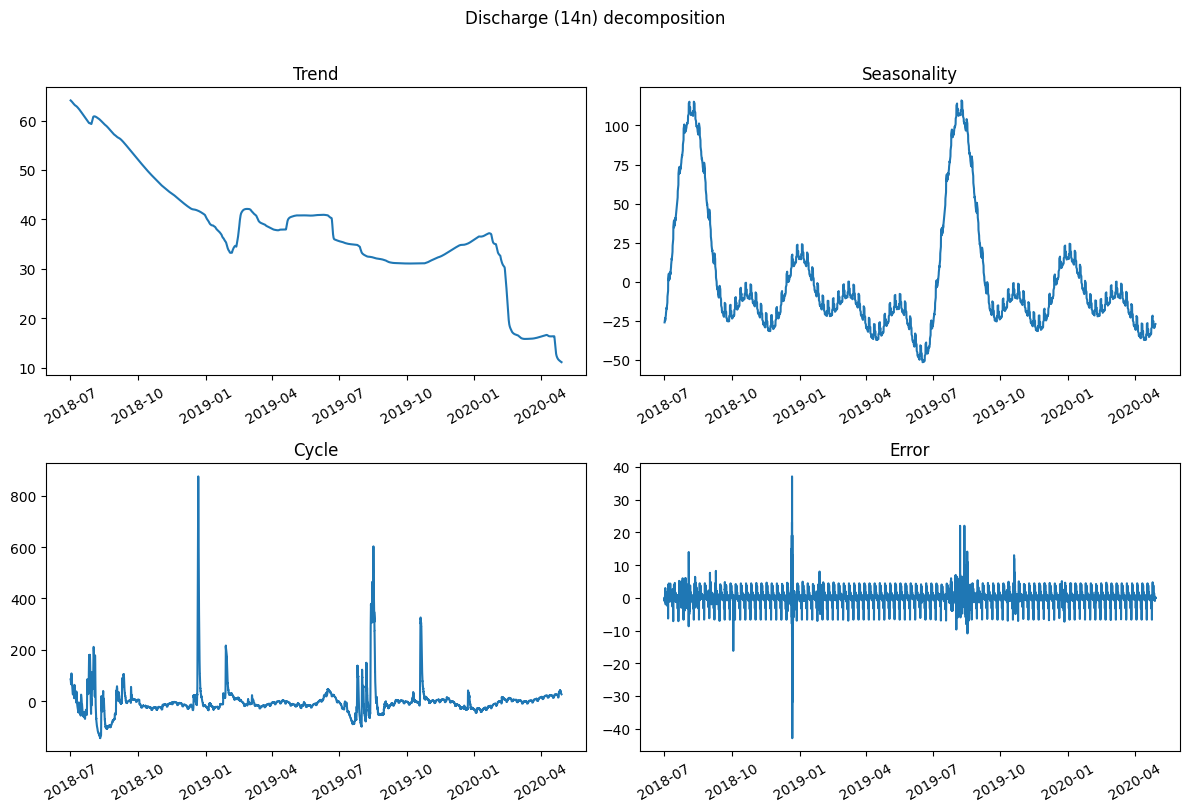

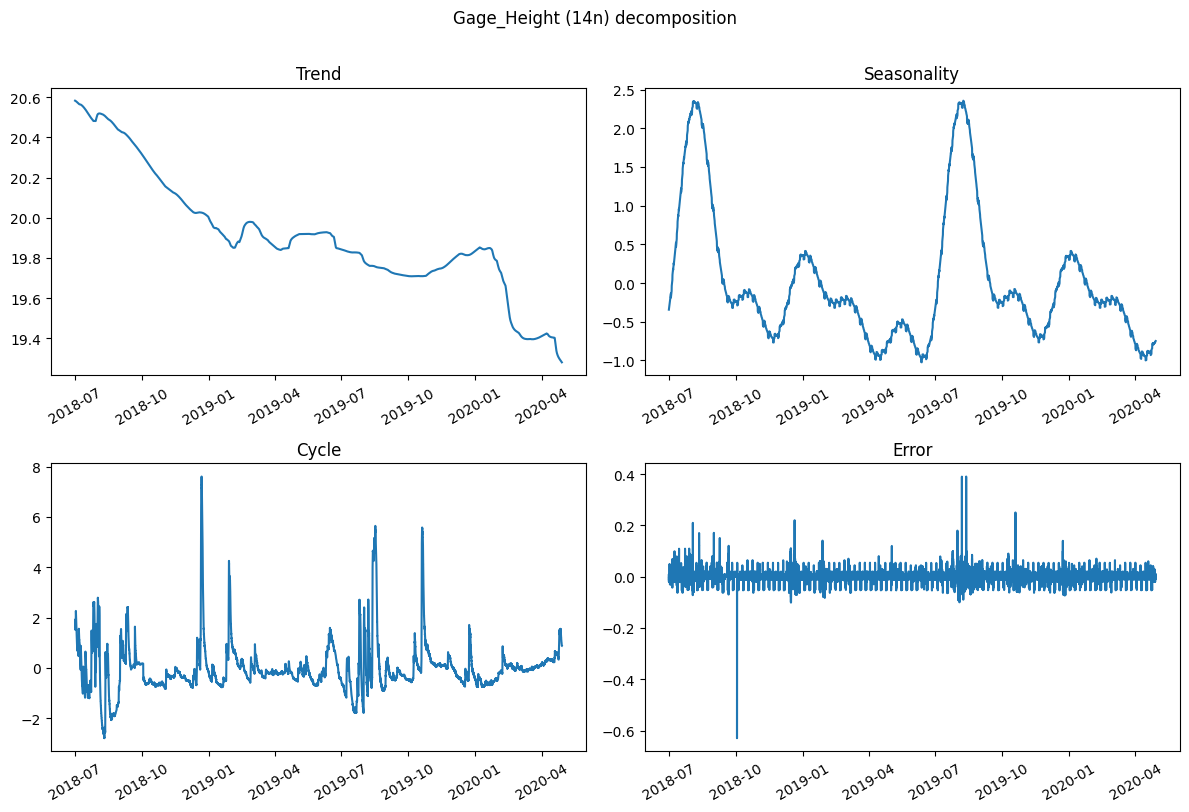

In [ ]:
# lr_trend = LinearRegression()
# lr_trend.fit(X_train['time_step'].to_frame(), y_train)

# trend_series = lr_trend.predict(X_train['time_step'].to_frame())
# trend_series = pd.DataFrame(trend_series, columns=y_train.columns)

discharge_ma = y_train.set_index(X_train['DateTime (20d)'])['Discharge (14n)'].rolling(
    window=35040,
    center=True,
    min_periods=17520
).mean()

gage_ma = y_train.set_index(X_train['DateTime (20d)'])['Gage_Height (14n)'].rolling(
    window=35040,
    center=True,
    min_periods=17520
).mean()

trend_series = pd.DataFrame()
trend_series['Discharge (14n)'] = discharge_ma
trend_series['Gage_Height (14n)'] = gage_ma
trend_series.reset_index(drop=True, inplace=True)

y_train_detrended = y_train - trend_series

seasonality_features = [
    col for col in X_train.columns
    if col.startswith('day') or col.startswith('sin') or col.startswith('cos')
]

seasonality_lr = LinearRegression()
seasonality_lr.fit(X_train[seasonality_features], y_train_detrended)

seasonality_series = seasonality_lr.predict(X_train[seasonality_features])
seasonality_series = pd.DataFrame(seasonality_series, columns=y_train.columns)

y_train_deseasoned = y_train_detrended - seasonality_series

X_train_cycle = y_train_deseasoned.iloc[:-1].reset_index(drop=True)
y_train_deseasoned = y_train_deseasoned.iloc[1:].reset_index(drop=True)

cycle_lr_discharge = LinearRegression()
cycle_lr_discharge.fit(
    X_train_cycle['Discharge (14n)'].to_frame(),
    y_train_deseasoned['Discharge (14n)']
)

cycle_lr_gage = LinearRegression()
cycle_lr_gage.fit(
    X_train_cycle['Gage_Height (14n)'].to_frame(),
    y_train_deseasoned['Gage_Height (14n)']
)

cycle_series = pd.DataFrame()
cycle_series['Discharge (14n)'] = cycle_lr_discharge.predict(
    X_train_cycle['Discharge (14n)'].to_frame()
)
cycle_series['Gage_Height (14n)'] = cycle_lr_gage.predict(
    X_train_cycle['Gage_Height (14n)'].to_frame()
)

error_series = y_train_deseasoned - cycle_series

series_list = [trend_series, seasonality_series, cycle_series, error_series]
series_names_list = ['Trend', 'Seasonality', 'Cycle', 'Error']

for col in ['Discharge (14n)', 'Gage_Height (14n)']:
    fig = plt.figure(figsize=(12, 8))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        if i in [2, 3]:
            plt.plot(X_train.iloc[1:]['DateTime (20d)'], series_list[i][col])
        else:
            plt.plot(X_train['DateTime (20d)'], series_list[i][col])
        plt.title(series_names_list[i])
        plt.xticks(rotation=30)
    plt.suptitle(f"{col} decomposition", y=1.01)
    plt.tight_layout()

Now let's do decomposition using statsmodels package. But the series have been converted to hourly frequency as the package is not able to work with 15 minute frequency: the mean over each hour has been taken while changing the frequency of the series.

In [ ]:
def plot_components(df, series_name):
    temp_df = df.set_index('DateTime (20d)')
    temp_df = temp_df.resample('H').mean()
    seasonal_decomp_mul = seasonal_decompose(
        temp_df[series_name],
        model='multiplicative',
        extrapolate_trend='freq'
    )
    seasonal_decomp_add = seasonal_decompose(
        temp_df[series_name],
        model='additive',
        extrapolate_trend='freq'
    )

    # plt.rcParams.update({'figure.figsize': (20, 10)})
    # fig = plt.figure(figsize=(20, 10))
    seasonal_decomp_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    seasonal_decomp_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()

    # return seasonal_decomp_mul, seasonal_decomp_add

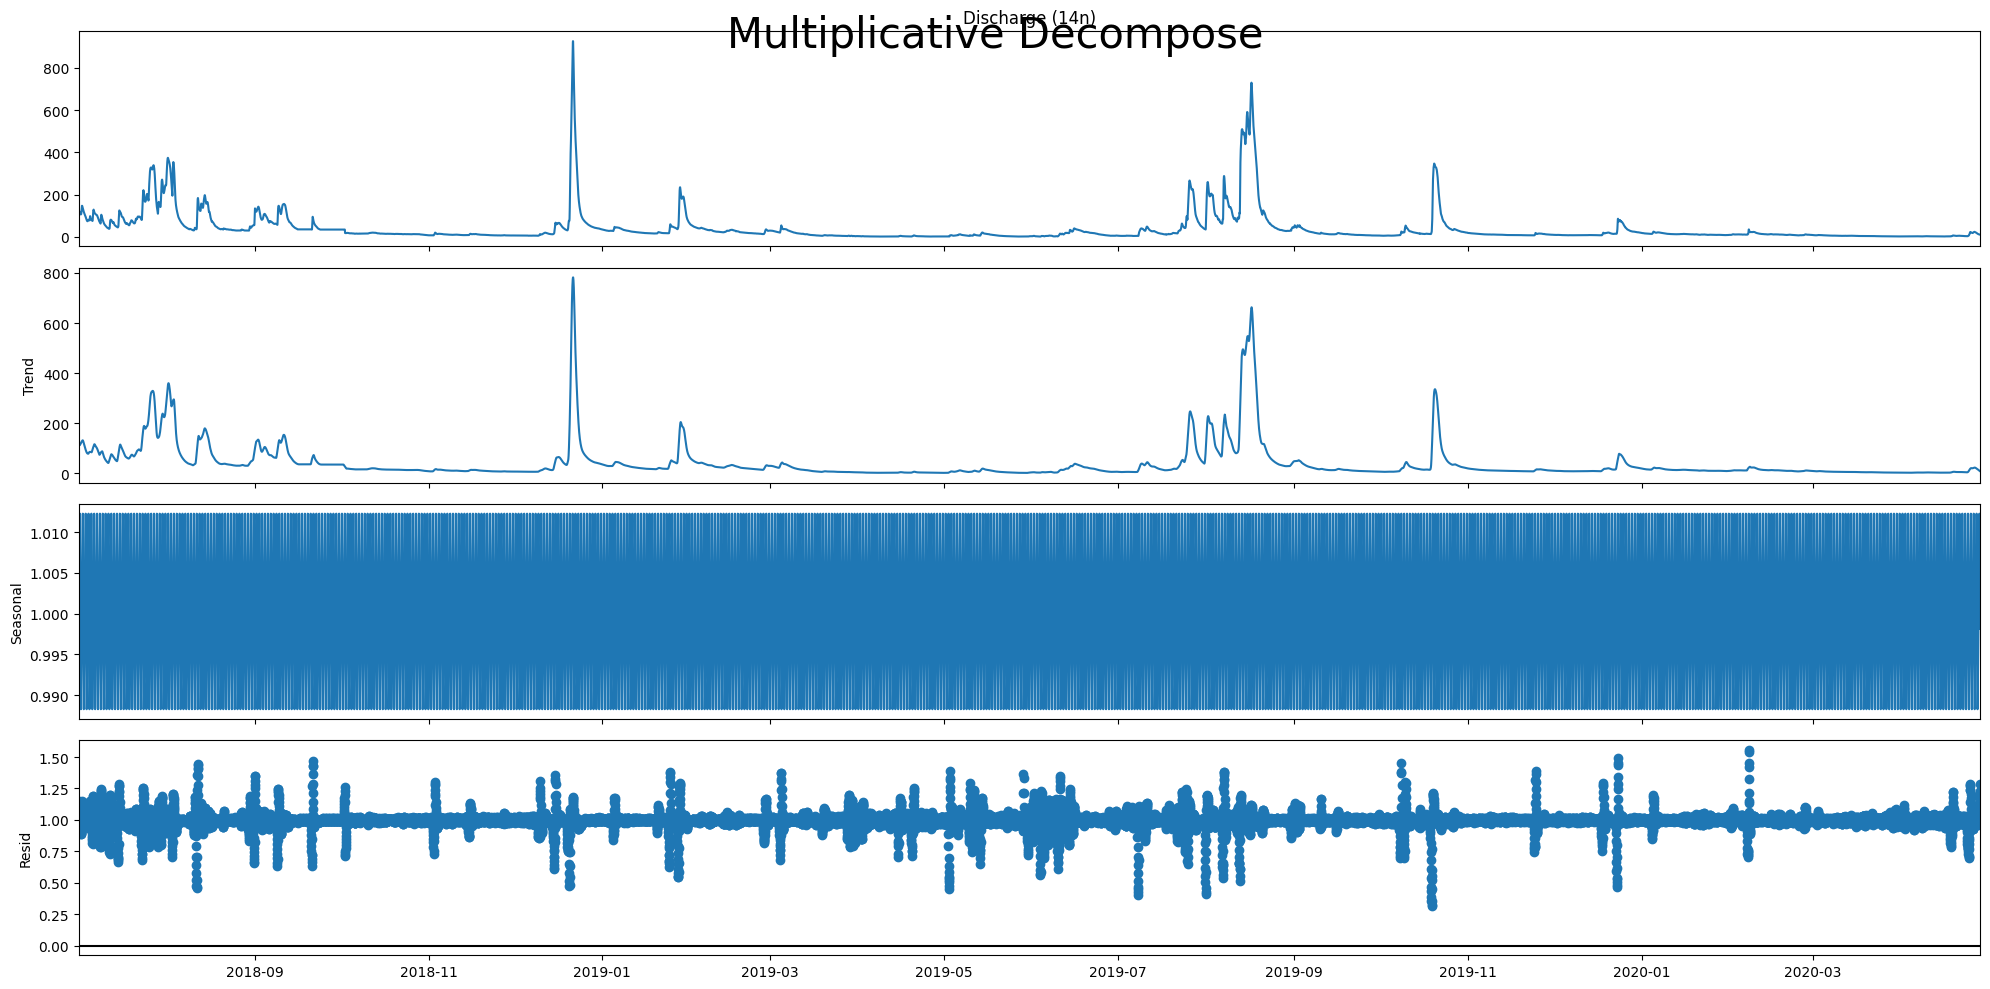

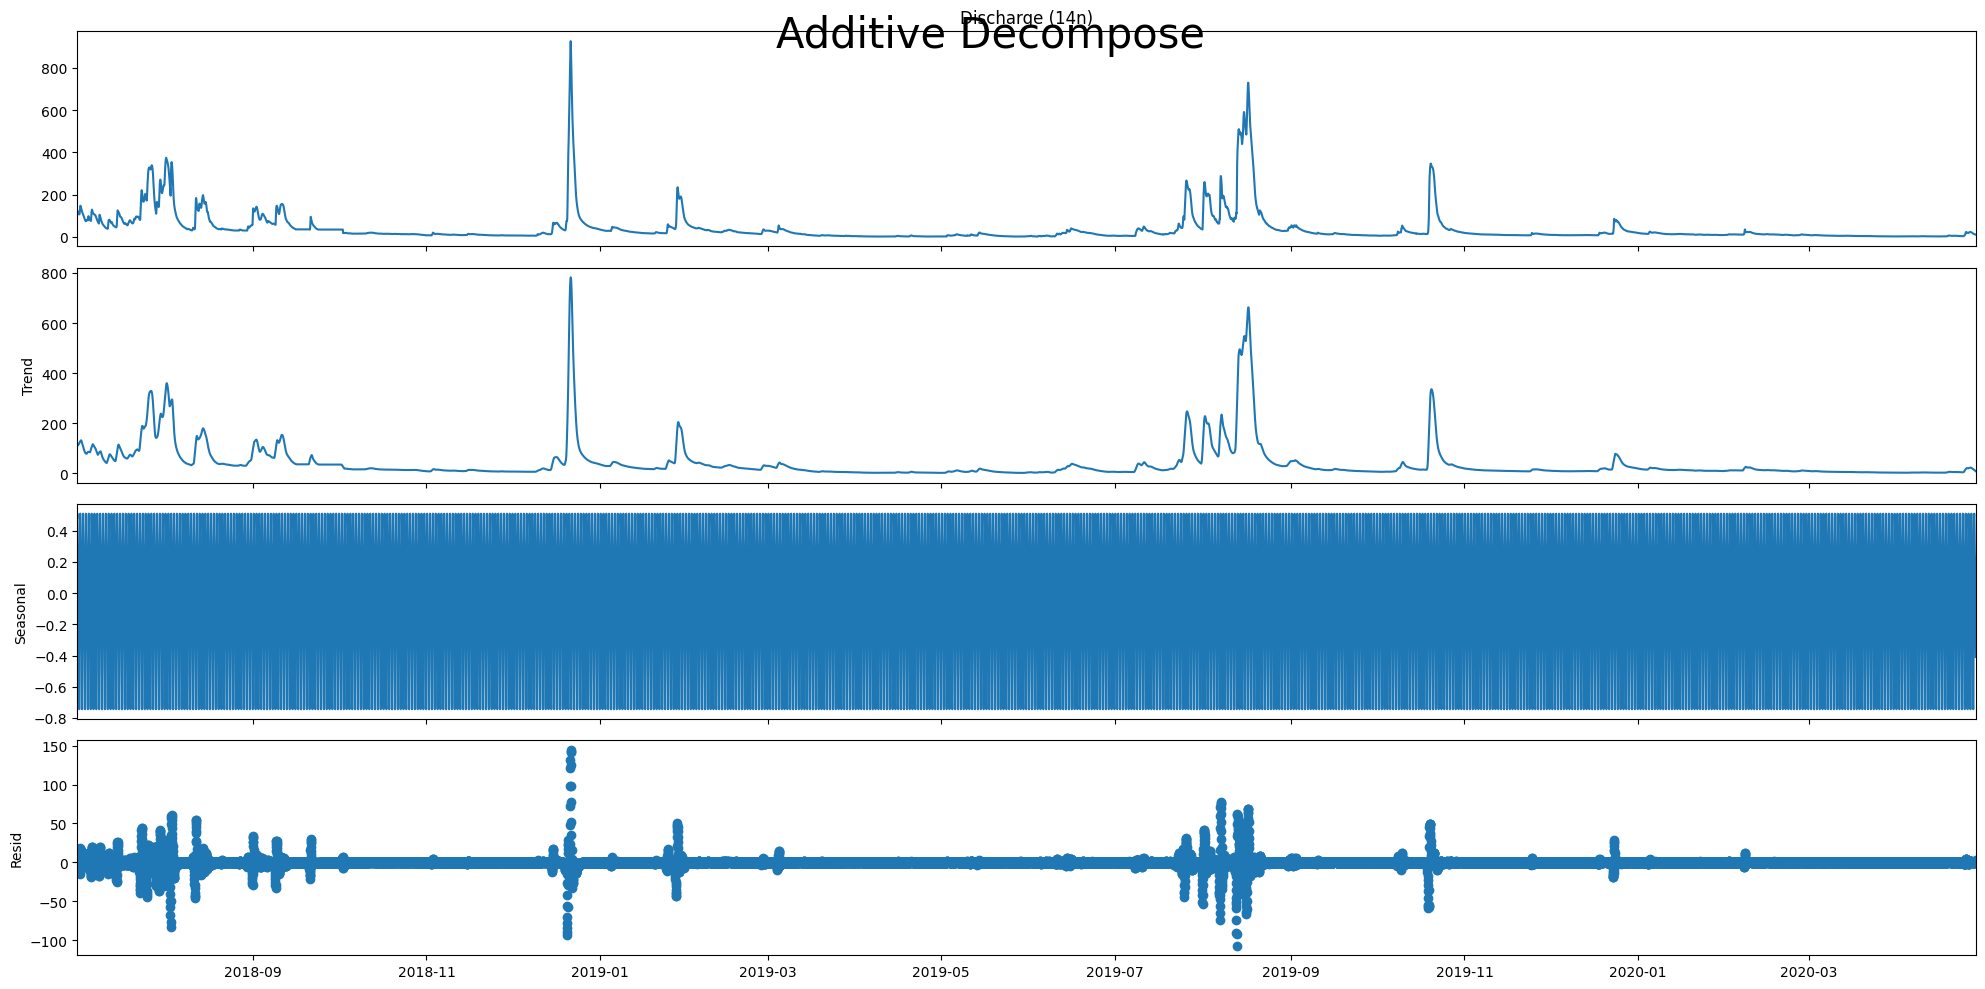

In [ ]:
plot_components(df=train, series_name='Discharge (14n)')

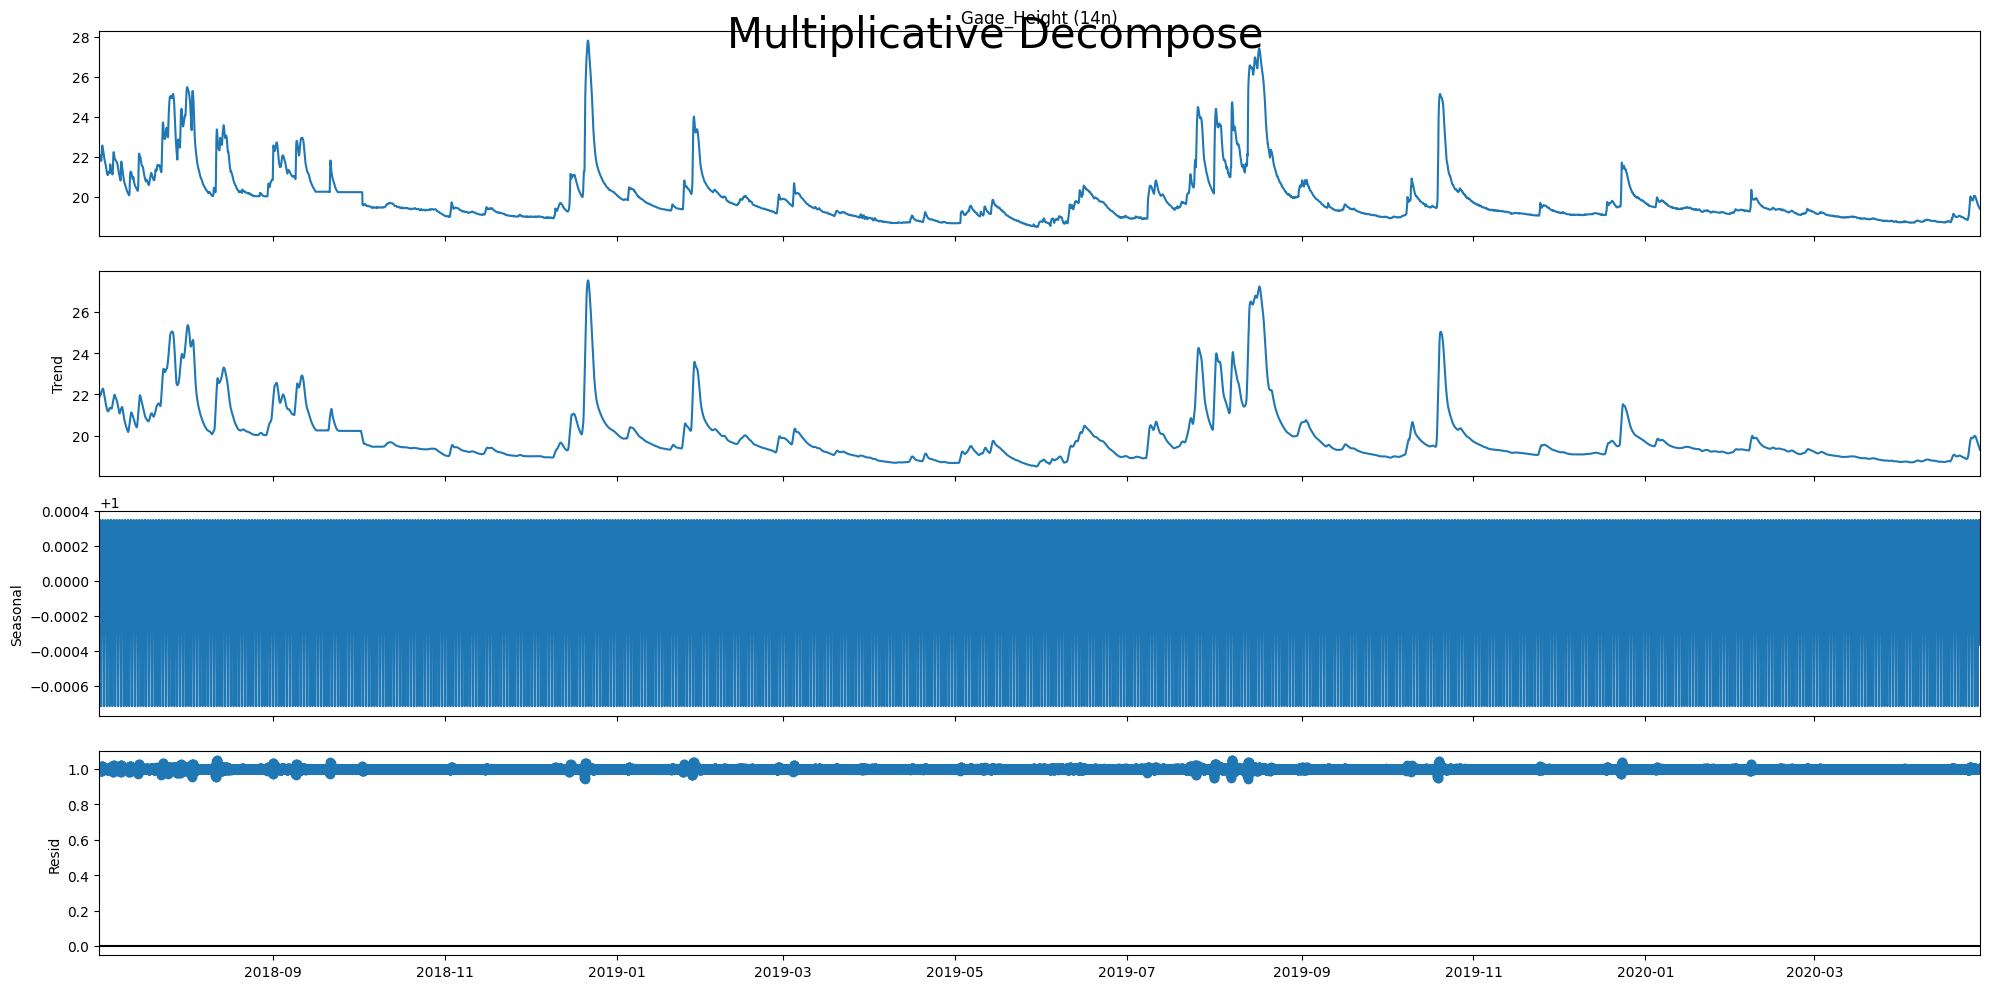

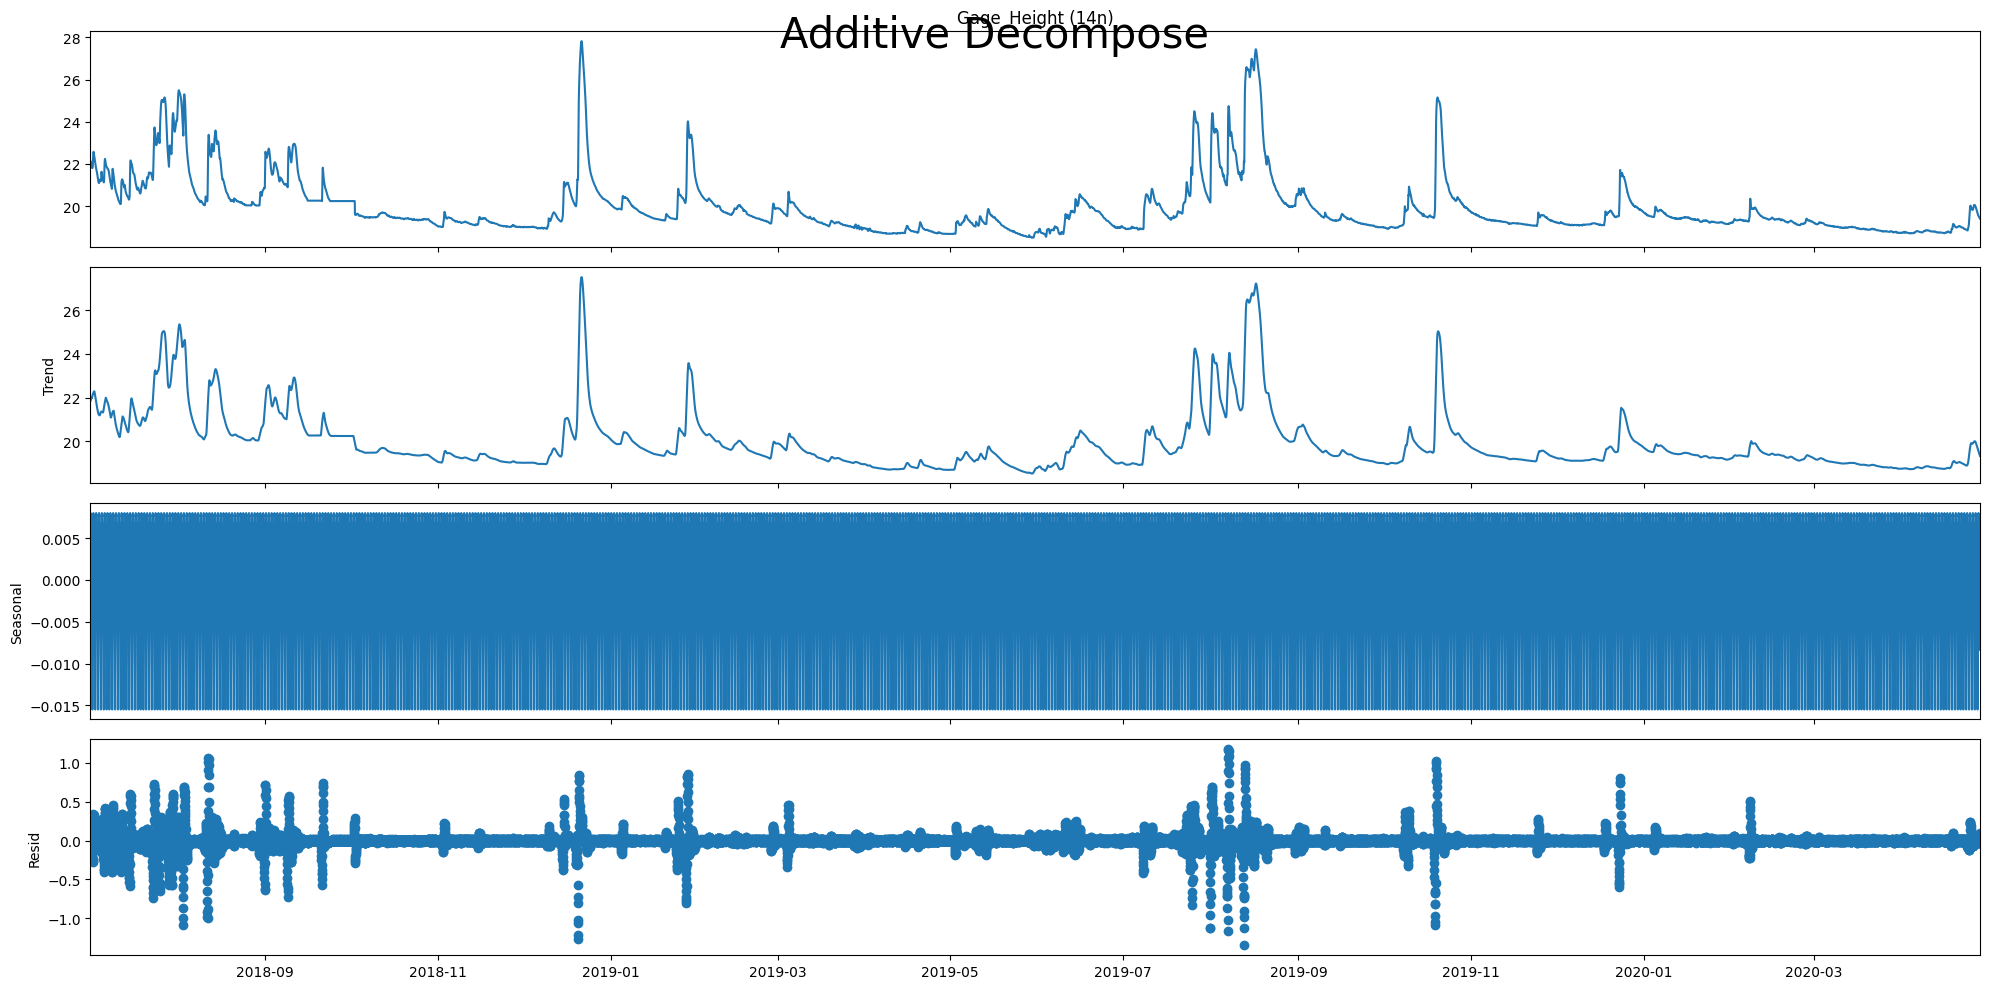

In [ ]:
plot_components(df=train, series_name='Gage_Height (14n)')

## Hybrid model

Now we can proceed to model creation. A hybrid model will be used. Specifically we apply linear regression using trend and seasonality features. Then we will subtract the estimates of trend and seasonality from the series and apply XBGRession using the rest of the features. To make a prediction we will sum the predictions from the 2 models.

In [ ]:
# creating linear regression model
lr_features = [
    col for col in X_train.columns
    if col.startswith('day') or col.startswith('sin') or col.startswith('cos')
]
# lr_features.append('time_step')

lr = LinearRegression()
lr.fit(X_train[lr_features], y_train)

# predicting the series using the estimated linear regression
lr_series_train = lr.predict(X_train[lr_features])
lr_series_train = pd.DataFrame(lr_series_train, columns=y_train.columns)

# removing the prediction of linear regression to prepare the new target variable
y_train_xgb = y_train - lr_series_train

# separating features for xgboost for each series
discharge_features = [
    col for col in X_train.columns
    if col.startswith('discharge') or col.endswith('discharge')
]

gage_features = [
    col for col in X_train.columns
    if col.startswith('gage') or col.endswith('gage')
]

# creating XGBoost models
xgb_discharge = XGBRegressor()
xgb_discharge.fit(X_train[discharge_features], y_train_xgb['Discharge (14n)'])

xgb_gage = XGBRegressor()
xgb_gage.fit(X_train[gage_features], y_train_xgb['Gage_Height (14n)'])

xgb_series_train = pd.DataFrame()
xgb_series_train['Discharge (14n)'] = xgb_discharge.predict(X_train[discharge_features])
xgb_series_train['Gage_Height (14n)'] = xgb_gage.predict(X_train[gage_features])

# creating final predictions for train and test sets
final_train_prediction = xgb_series_train + lr_series_train
final_train_prediction.index = X_train['DateTime (20d)']

final_train_prediction['Discharge (14n)'] = final_train_prediction['Discharge (14n)'].apply(
    lambda x: train['Discharge (14n)'].min() if x <=0 else x
)
final_train_prediction['Gage_Height (14n)'] = final_train_prediction['Gage_Height (14n)'].apply(
    lambda x: train['Gage_Height (14n)'].min() if x <=0 else x
)

lr_series_test = lr.predict(X_test[lr_features])
lr_series_test = pd.DataFrame(lr_series_test, columns=y_train.columns)

xgb_series_test = pd.DataFrame()
xgb_series_test['Discharge (14n)'] = xgb_discharge.predict(X_test[discharge_features])
xgb_series_test['Gage_Height (14n)'] = xgb_gage.predict(X_test[gage_features])

final_test_prediction = xgb_series_test + lr_series_test
final_test_prediction.index = X_test['DateTime (20d)']

final_test_prediction['Discharge (14n)'] = final_test_prediction['Discharge (14n)'].apply(
    lambda x: train['Discharge (14n)'].min() if x <=0 else x
)
final_test_prediction['Gage_Height (14n)'] = final_test_prediction['Gage_Height (14n)'].apply(
    lambda x: train['Gage_Height (14n)'].min() if x <=0 else x
)

## Metrics

Let's show the metrics for the train set predictions.

In [ ]:
discharge_mse = mean_squared_error(
    y_train['Discharge (14n)'],
    final_train_prediction['Discharge (14n)']
)

discharge_rmse = np.sqrt(discharge_mse)

discharge_mae = mean_absolute_error(
    y_train['Discharge (14n)'],
    final_train_prediction['Discharge (14n)']
)

discharge_r2 = r2_score(
    y_train['Discharge (14n)'],
    final_train_prediction['Discharge (14n)']
)

gage_mse = mean_squared_error(
    y_train['Gage_Height (14n)'],
    final_train_prediction['Gage_Height (14n)']
)

gage_rmse = np.sqrt(gage_mse)

gage_mae = mean_absolute_error(
    y_train['Gage_Height (14n)'],
    final_train_prediction['Gage_Height (14n)']
)

gage_r2 = r2_score(
    y_train['Gage_Height (14n)'],
    final_train_prediction['Gage_Height (14n)']
)

print('### Discharge ###')
print(f"MSE: {discharge_mse:.4f}")
print(f"RMSE: {discharge_rmse:.4f}")
print(f"MAE: {discharge_mae:.4f}")
print(f"R2: {discharge_r2:.4f}")

print('### Gage_Height ###')
print(f"MSE: {gage_mse:.4f}")
print(f"RMSE: {gage_rmse:.4f}")
print(f"MAE: {gage_mae:.4f}")
print(f"R2: {gage_r2:.4f}")

### Discharge ###
MSE: 132.1565
RMSE: 11.4959
MAE: 6.0018
R2: 0.9772
### Gage_Height ###
MSE: 0.0428
RMSE: 0.2068
MAE: 0.1130
R2: 0.9779


And now let's show the metrics for the test set predictions.

In [ ]:
discharge_mse = mean_squared_error(
    y_test['Discharge (14n)'],
    final_test_prediction['Discharge (14n)']
)

discharge_rmse = np.sqrt(discharge_mse)

discharge_mae = mean_absolute_error(
    y_test['Discharge (14n)'],
    final_test_prediction['Discharge (14n)']
)

discharge_r2 = r2_score(
    y_test['Discharge (14n)'],
    final_test_prediction['Discharge (14n)']
)

gage_mse = mean_squared_error(
    y_test['Gage_Height (14n)'],
    final_test_prediction['Gage_Height (14n)']
)

gage_rmse = np.sqrt(gage_mse)

gage_mae = mean_absolute_error(
    y_test['Gage_Height (14n)'],
    final_test_prediction['Gage_Height (14n)']
)

gage_r2 = r2_score(
    y_test['Gage_Height (14n)'],
    final_test_prediction['Gage_Height (14n)']
)

print('### Discharge ###')
print(f"MSE: {discharge_mse:.4f}")
print(f"RMSE: {discharge_rmse:.4f}")
print(f"MAE: {discharge_mae:.4f}")
print(f"R2: {discharge_r2:.4f}")

print('### Gage_Height ###')
print(f"MSE: {gage_mse:.4f}")
print(f"RMSE: {gage_rmse:.4f}")
print(f"MAE: {gage_mae:.4f}")
print(f"R2: {gage_r2:.4f}")

### Discharge ###
MSE: 2281.2366
RMSE: 47.7623
MAE: 17.0699
R2: 0.8318
### Gage_Height ###
MSE: 0.3780
RMSE: 0.6149
MAE: 0.3414
R2: 0.7803


## Prediction

Let's plot the actual and predicted values of the series.

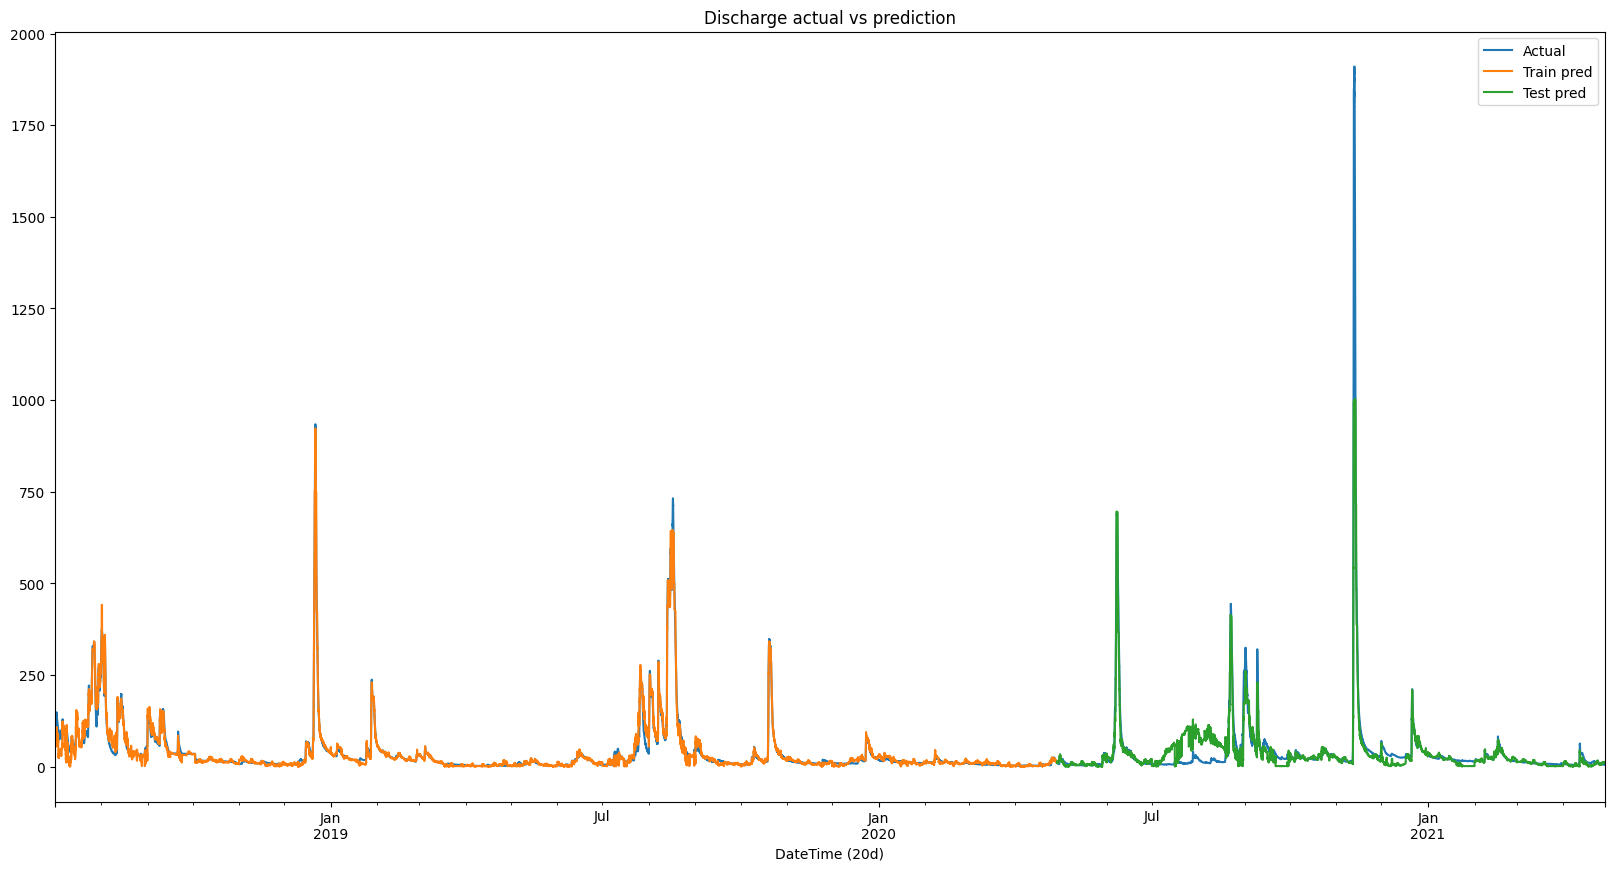

In [ ]:
ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

final_train_prediction['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Discharge actual vs prediction',
    legend=True,
    label='Train pred'
)

final_test_prediction['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    # title='Discharge',
    legend=True,
    label='Test pred'
);

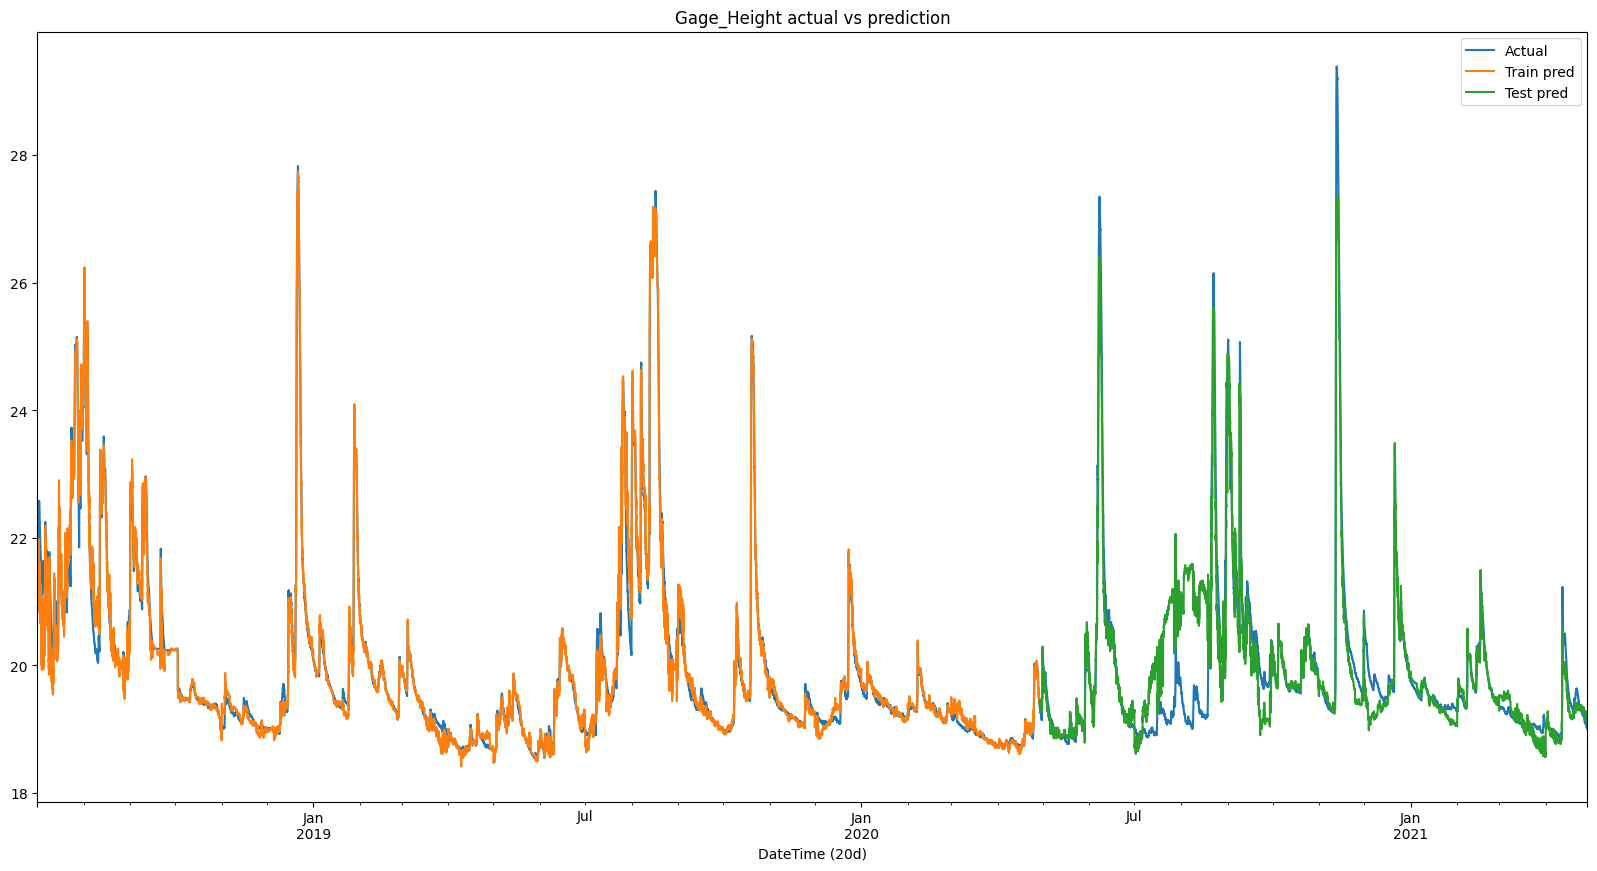

In [ ]:
ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

final_train_prediction['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Gage_Height actual vs prediction',
    legend=True,
    label='Train pred'
)

final_test_prediction['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    # title='Gage_Height',
    legend=True,
    label='Test pred'
);

Now let's make the 5 year prediction.

In [ ]:
# # getting EDT and EST conversion dates for prediction set
# prediction_features['hour'] = prediction_features['DateTime (20d)'].dt.hour
# prediction_features['minute'] = prediction_features['DateTime (20d)'].dt.minute
# prediction_features['second'] = prediction_features['DateTime (20d)'].dt.second
# prediction_features['month'] = prediction_features['DateTime (20d)'].dt.month
# prediction_features['dayofweek'] = prediction_features['DateTime (20d)'].dt.dayofweek
# prediction_features['day'] = prediction_features['DateTime (20d)'].dt.day
# prediction_features['weekofmonth'] = prediction_features['day'].apply(lambda x: (x-1) // 7 + 1)
# edt_dates_pred = list(
#     prediction_features[
#         (prediction_features['hour']==7) & (prediction_features['month']==3) &
#         (prediction_features['weekofmonth']==2) & (prediction_features['minute']==0) &
#         (prediction_features['second']==0) & (prediction_features['dayofweek']==6)
#     ]['DateTime (20d)']
# )
# est_dates_pred = list(
#     prediction_features[
#         (prediction_features['hour']==6) & (prediction_features['month']==11) &
#         (prediction_features['weekofmonth']==1) & (prediction_features['minute']==0) &
#         (prediction_features['second']==0) & (prediction_features['dayofweek']==6)
#     ]['DateTime (20d)']
# )
# est_dates_pred

In [ ]:
lr_series_pred = lr.predict(prediction_features[lr_features])
lr_series_pred = pd.DataFrame(lr_series_pred, columns=y_train.columns)

prediction_features['Discharge (14n)'] = np.zeros(prediction_features.shape[0])
prediction_features['Gage_Height (14n)'] = np.zeros(prediction_features.shape[0])

for i in range(1, N_LAGS+1):
    prediction_features[f'lag{i}_discharge'] = np.zeros(prediction_features.shape[0])
    prediction_features[f'lag{i}_gage'] = np.zeros(prediction_features.shape[0])

for j in tqdm(range(prediction_features.shape[0])):
    for i in range(1, 9):
        if i - j > 0:
            prediction_features.loc[j, f'lag{i}_discharge'] = y_test.iloc[-i+j]['Discharge (14n)']
            prediction_features[f'lag{i}_gage'] = y_test.iloc[-i+j]['Gage_Height (14n)']
        else:
            prediction_features.loc[j, f'lag{i}_discharge'] = prediction_features.iloc[j-i]['Discharge (14n)']
            prediction_features.loc[j, f'lag{i}_gage'] = prediction_features.iloc[j-i]['Gage_Height (14n)']

    prediction_features.loc[j, 'Discharge (14n)'] = xgb_discharge.predict(
        np.array(list(prediction_features.iloc[j][discharge_features])).reshape(1, -1)
    )[0]

    prediction_features.loc[j, 'Gage_Height (14n)'] = xgb_gage.predict(
        np.array(list(prediction_features.iloc[j][gage_features])).reshape(1, -1)
    )[0]

final_5year_prediction = prediction_features[
    ['Discharge (14n)', 'Gage_Height (14n)']
] + lr_series_pred

final_5year_prediction['Discharge (14n)'] = final_5year_prediction['Discharge (14n)'].apply(
    lambda x: train['Discharge (14n)'].min()
    if (x <=0 or x < train['Discharge (14n)'].min())
    else x
)
final_5year_prediction['Gage_Height (14n)'] = final_5year_prediction['Gage_Height (14n)'].apply(
    lambda x: train['Gage_Height (14n)'].min()
    if (x <=0 or x < train['Gage_Height (14n)'].min())
    else x
)

final_5year_prediction.index = prediction_features['DateTime (20d)']

eastern_tz = pytz.timezone('US/Eastern')
est_time = prediction_features['DateTime (20d)'].apply(
    lambda x: pd.to_datetime(x, utc=True).astimezone(eastern_tz)
)

final_5year_prediction['Timezone'] = (pd.to_datetime(
    prediction_features['DateTime (20d)'], utc=True
).dt.hour - est_time.dt.hour).values
final_5year_prediction['EST_EDT_DateTime'] = list(prediction_features['DateTime (20d)'])
final_5year_prediction.loc[final_5year_prediction['Timezone']==4, 'EST_EDT_DateTime'] -= timedelta(hours=4)
final_5year_prediction.loc[final_5year_prediction['Timezone']==5, 'EST_EDT_DateTime'] -= timedelta(hours=5)
final_5year_prediction.loc[final_5year_prediction['Timezone']==-20, 'EST_EDT_DateTime'] -= timedelta(hours=4)
final_5year_prediction.loc[final_5year_prediction['Timezone']==-19, 'EST_EDT_DateTime'] -= timedelta(hours=5)
final_5year_prediction.drop(columns='Timezone', inplace=True)
final_5year_prediction.head()

100%|██████████| 175200/175200 [38:48<00:00, 75.25it/s]


Discharge (14n)  Gage_Height (14n)    EST_EDT_DateTime
DateTime (20d)                                                             
2021-04-28 19:30:00        12.174462          19.150279 2021-04-28 15:30:00
2021-04-28 19:45:00         5.520546          18.744227 2021-04-28 15:45:00
2021-04-28 20:00:00        10.781947          18.782684 2021-04-28 16:00:00
2021-04-28 20:15:00         7.995636          18.790563 2021-04-28 16:15:00
2021-04-28 20:30:00        10.012545          18.765739 2021-04-28 16:30:00

Finally let's plot the predictions along with actual data.

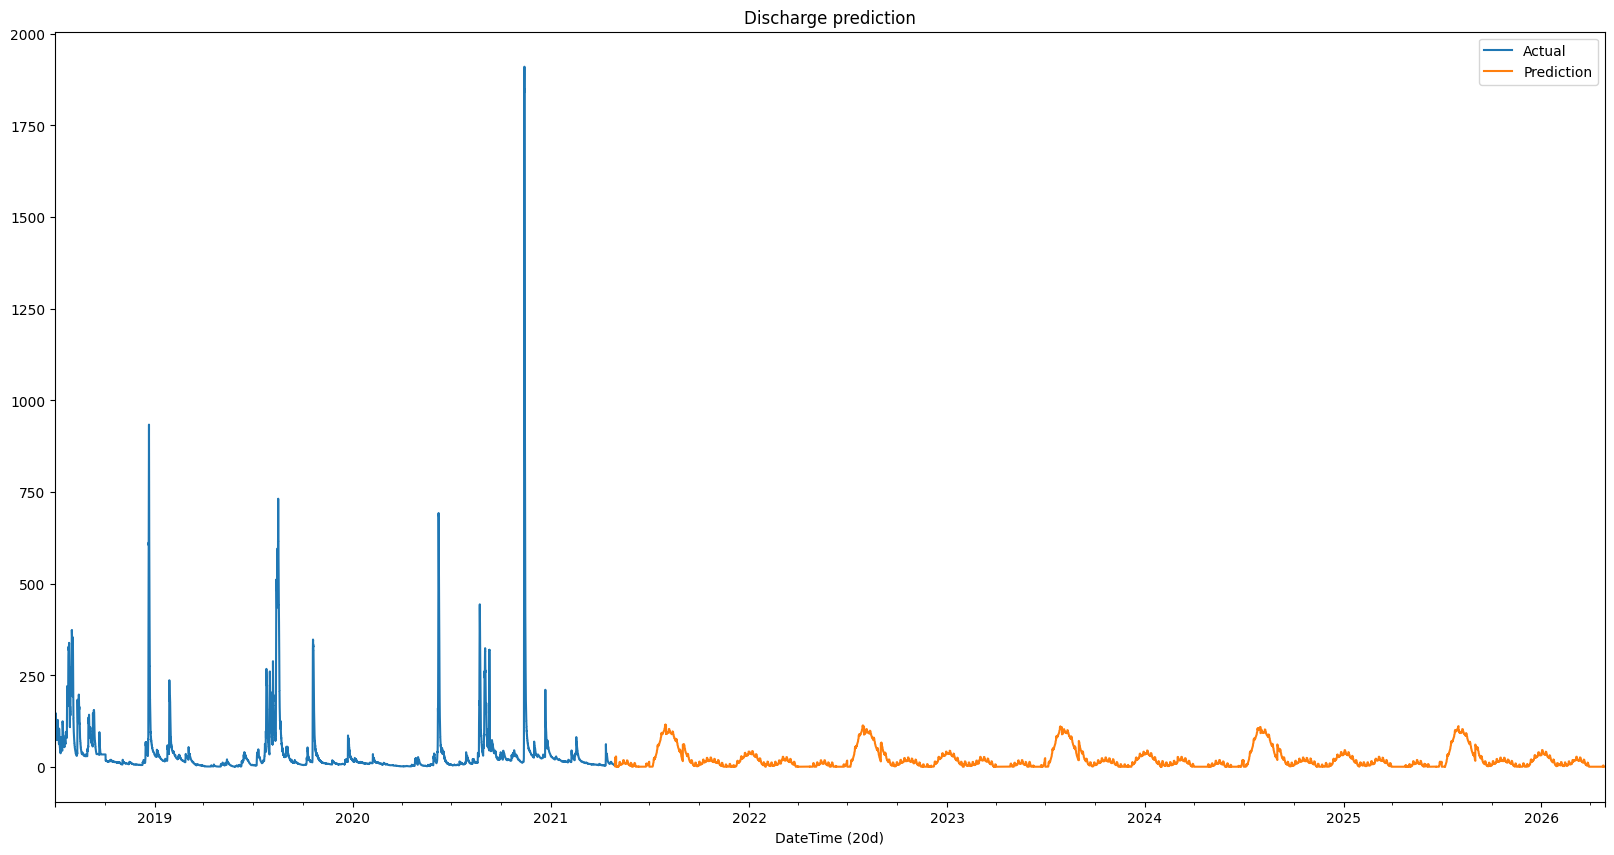

In [ ]:
ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_prediction['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Discharge prediction',
    legend=True,
    label='Prediction'
);

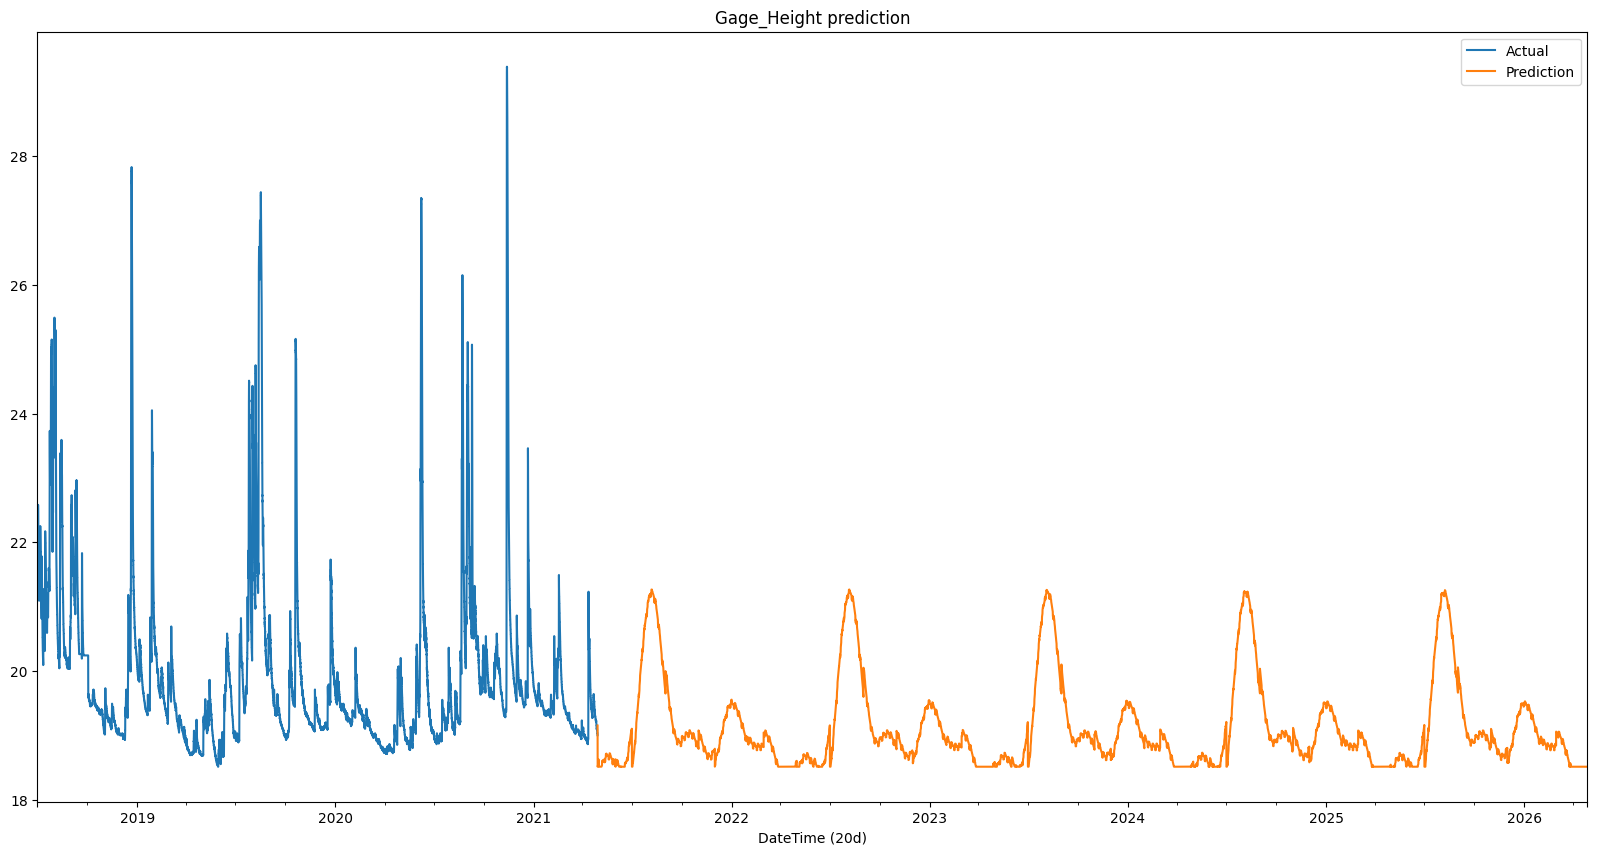

In [ ]:
ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_prediction['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Gage_Height prediction',
    legend=True,
    label='Prediction'
);

Saving the predictions

In [ ]:
final_5year_prediction.to_csv('predictions.csv')

Let's try to add the spikes to the predictions. First of all let's
derive the average values for spikes and duration between them.

In [ ]:
df = train.copy()
series_name = 'Discharge (14n)'

def get_spikes(
    df, series_name, multiplier1=4,
    multiplier2=None, acceptable_diff=15,
    main_data=data, pred_data=prediction_features
):

    # finding interquantile range
    Q1 = df[series_name].quantile(0.25)
    Q3 = df[series_name].quantile(0.75)
    IQR = Q3 - Q1

    # creating boundaries
    lower_bound1 = Q1 - multiplier1 * IQR
    upper_bound1 = Q3 + multiplier1 * IQR

    # identifying outliers/spikes
    if multiplier2 is None:
        outliers = df[
            (df[series_name] < lower_bound1) | (df[series_name] > upper_bound1)
        ][['DateTime (20d)', series_name]]

        outliers2 = main_data[
            (main_data[series_name] < lower_bound1) | (main_data[series_name] > upper_bound1)
        ][['DateTime (20d)', series_name]]
    else:
        lower_bound2 = Q1 - multiplier2 * IQR
        upper_bound2 = Q3 + multiplier2 * IQR
        outliers = df[
            ((df[series_name] < lower_bound1) & ((df[series_name] > lower_bound2))) |
            ((df[series_name] > upper_bound1) & (df[series_name] < upper_bound2))
        ][['DateTime (20d)', series_name]]

        outliers2 = main_data[
            ((main_data[series_name] < lower_bound1) & ((main_data[series_name] > lower_bound2))) |
            ((main_data[series_name] > upper_bound1) & (main_data[series_name] < upper_bound2))
        ][['DateTime (20d)', series_name]]

    # finding the mean value of spikes for the series
    # spike_mean_value = outliers[series_name].median()
    spike_mean_value = outliers[
        outliers[series_name]>=outliers[series_name].median()
    ][series_name].mean()

    # finding the average period between spikes
    outliers.sort_values('DateTime (20d)', ascending=True, inplace=True)
    outliers.reset_index(inplace=True, drop=True)
    spike_mean_freq = int(
        (
            outliers[
                outliers['DateTime (20d)'].diff().dt.total_seconds()/60>acceptable_diff
            ]['DateTime (20d)'].diff().dt.total_seconds()/60
        ).max()
    )

    last_date = outliers2[
        outliers2['DateTime (20d)'].diff().dt.total_seconds()/60>acceptable_diff
    ].iloc[-1]['DateTime (20d)']

    spike_mean_freq15 = int(spike_mean_freq - spike_mean_freq % 15)

    future_occurance_dates = []
    spike_freq_multiplier = 7
    while last_date < pred_data.iloc[-1]['DateTime (20d)']:
        next_last_date = last_date + timedelta(seconds=spike_freq_multiplier*spike_mean_freq15)
        if next_last_date > main_data.iloc[-1]['DateTime (20d)']:
            future_occurance_dates.append(next_last_date)
        last_date = next_last_date

    # finding dates related to outliers/spikes
    outliers_date = list(outliers['DateTime (20d)'])

    # plotting spikes in line with the series
    fig = plt.figure(figsize=(20, 10))
    plt.plot(df['DateTime (20d)'], df[series_name])
    for i in range(len(outliers_date)):
        plt.axvline(outliers_date[i], color='orange', alpha=0.01)
    plt.xticks(rotation=45)
    plt.title('Spikes used during calculation')
    plt.show()

    return spike_mean_value, future_occurance_dates

##### Value pair 1 #####


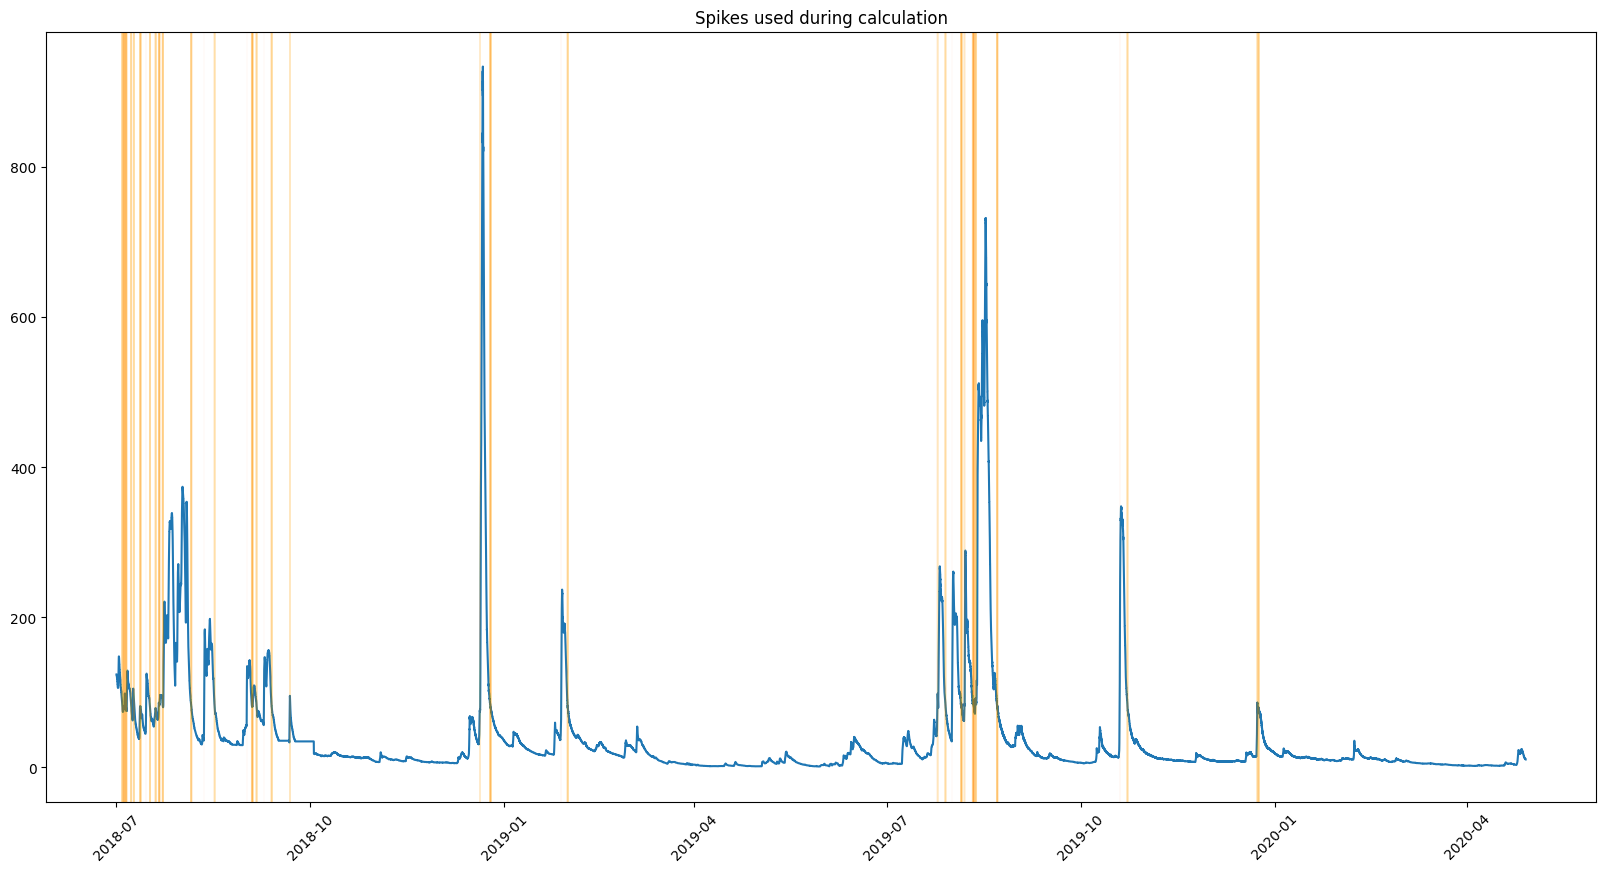

##### Value pair 2 #####


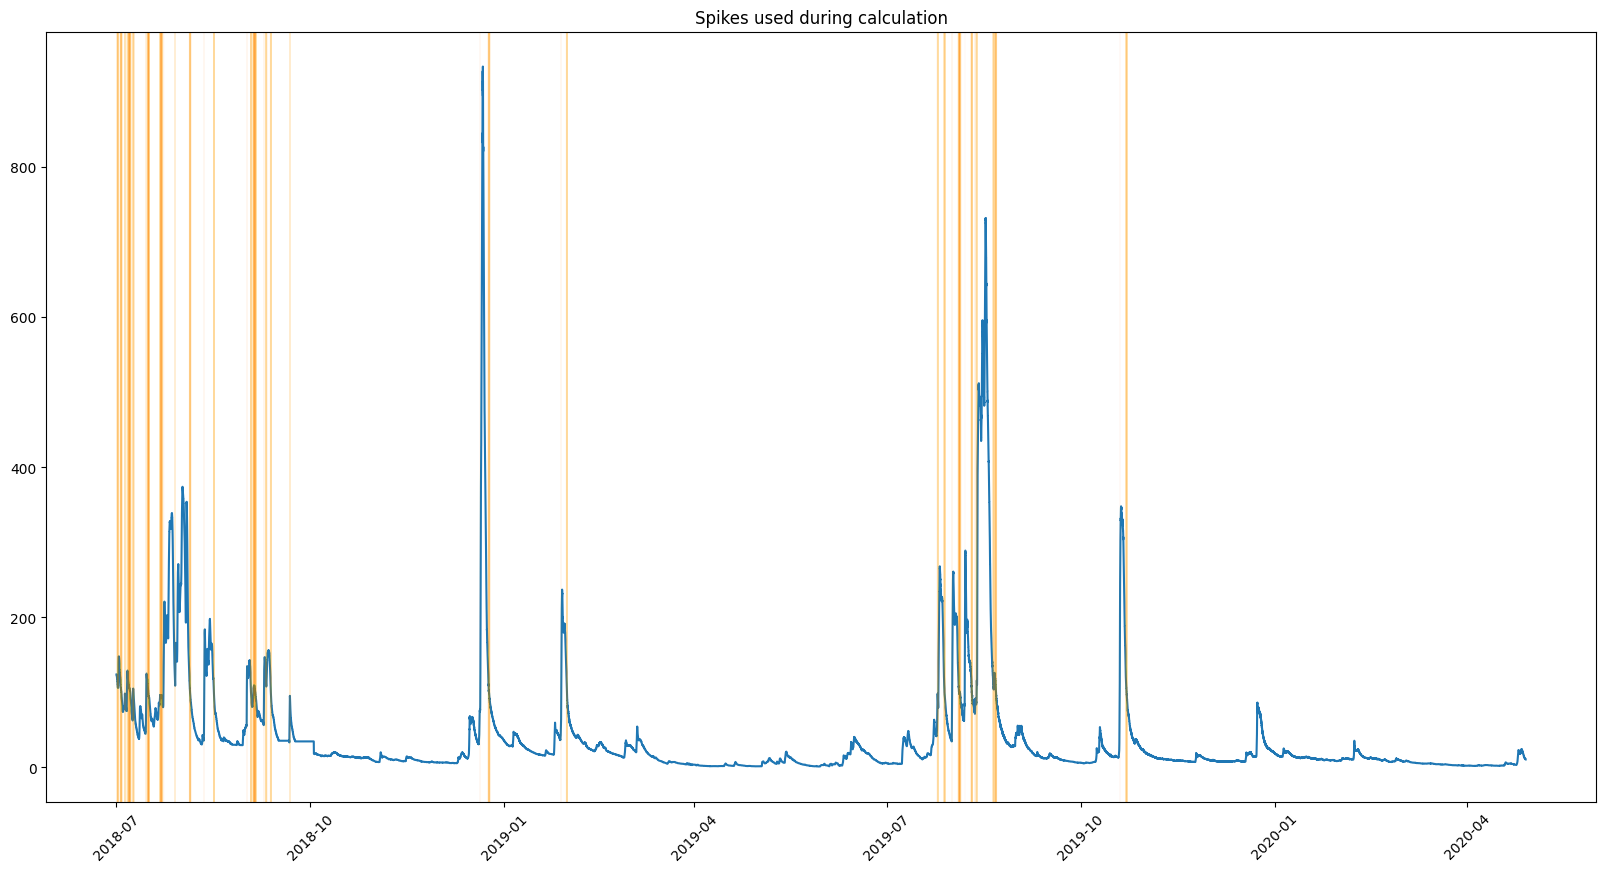

##### Value pair 3 #####


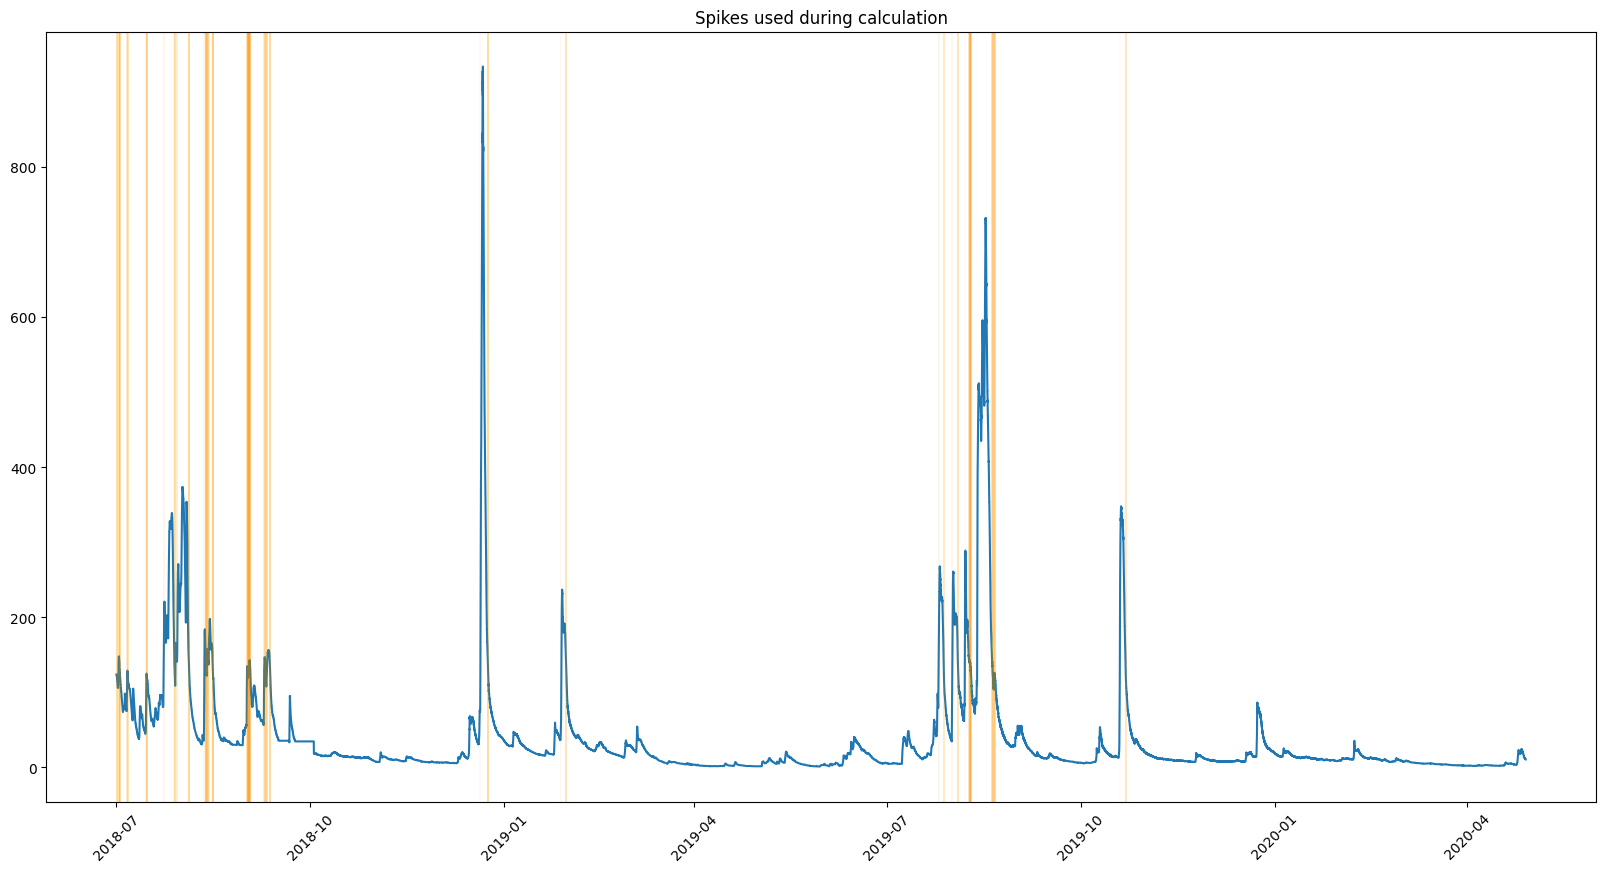

##### Value pair 4 #####


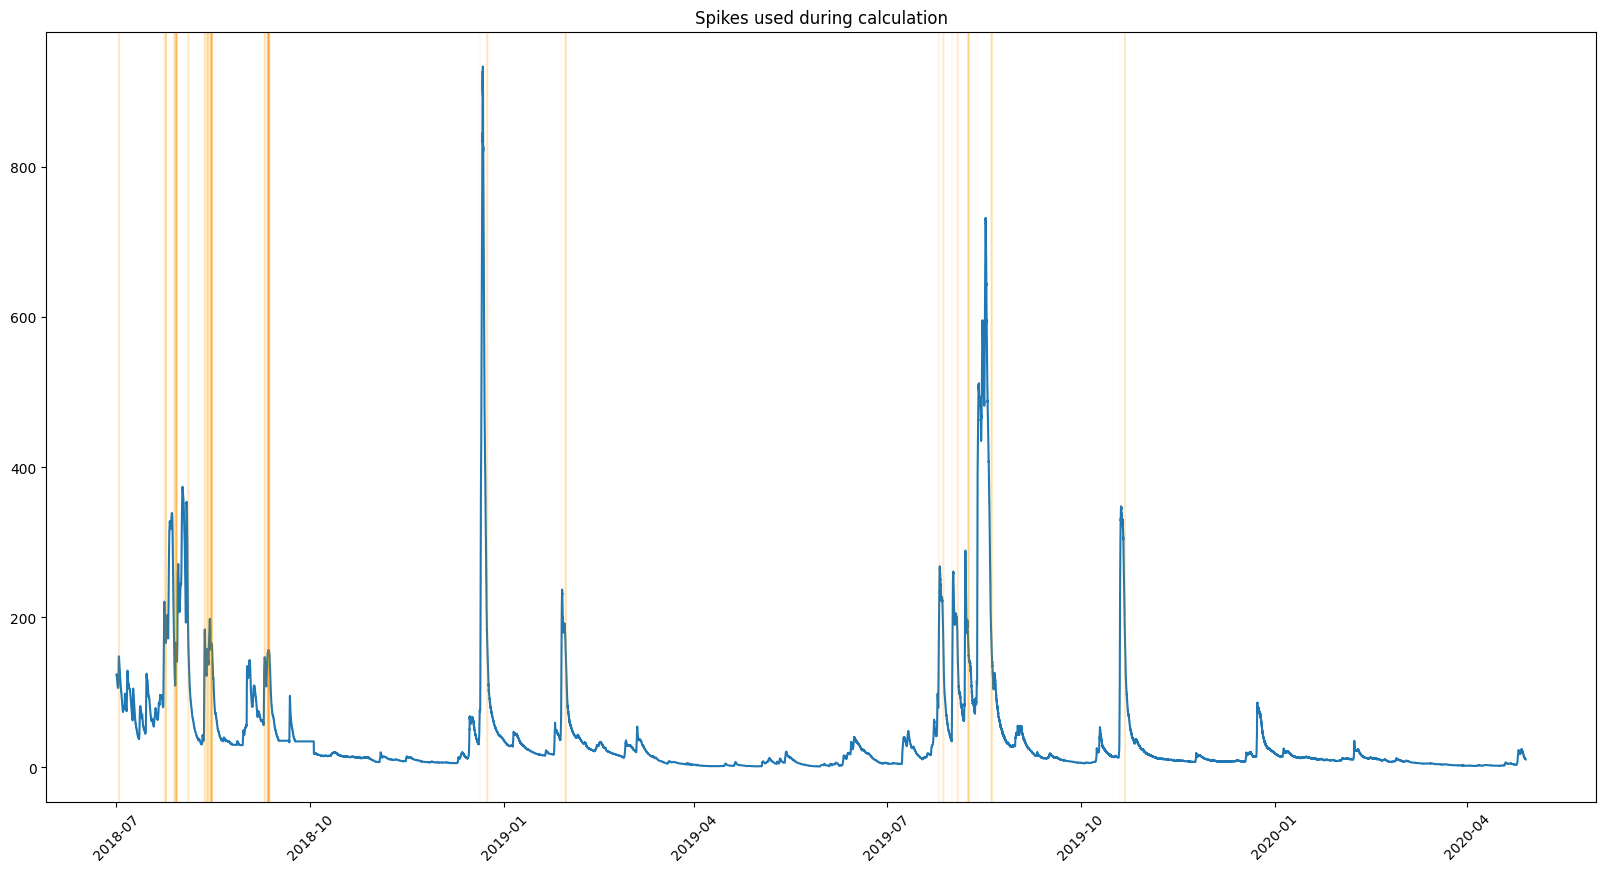

##### Value pair 5 #####


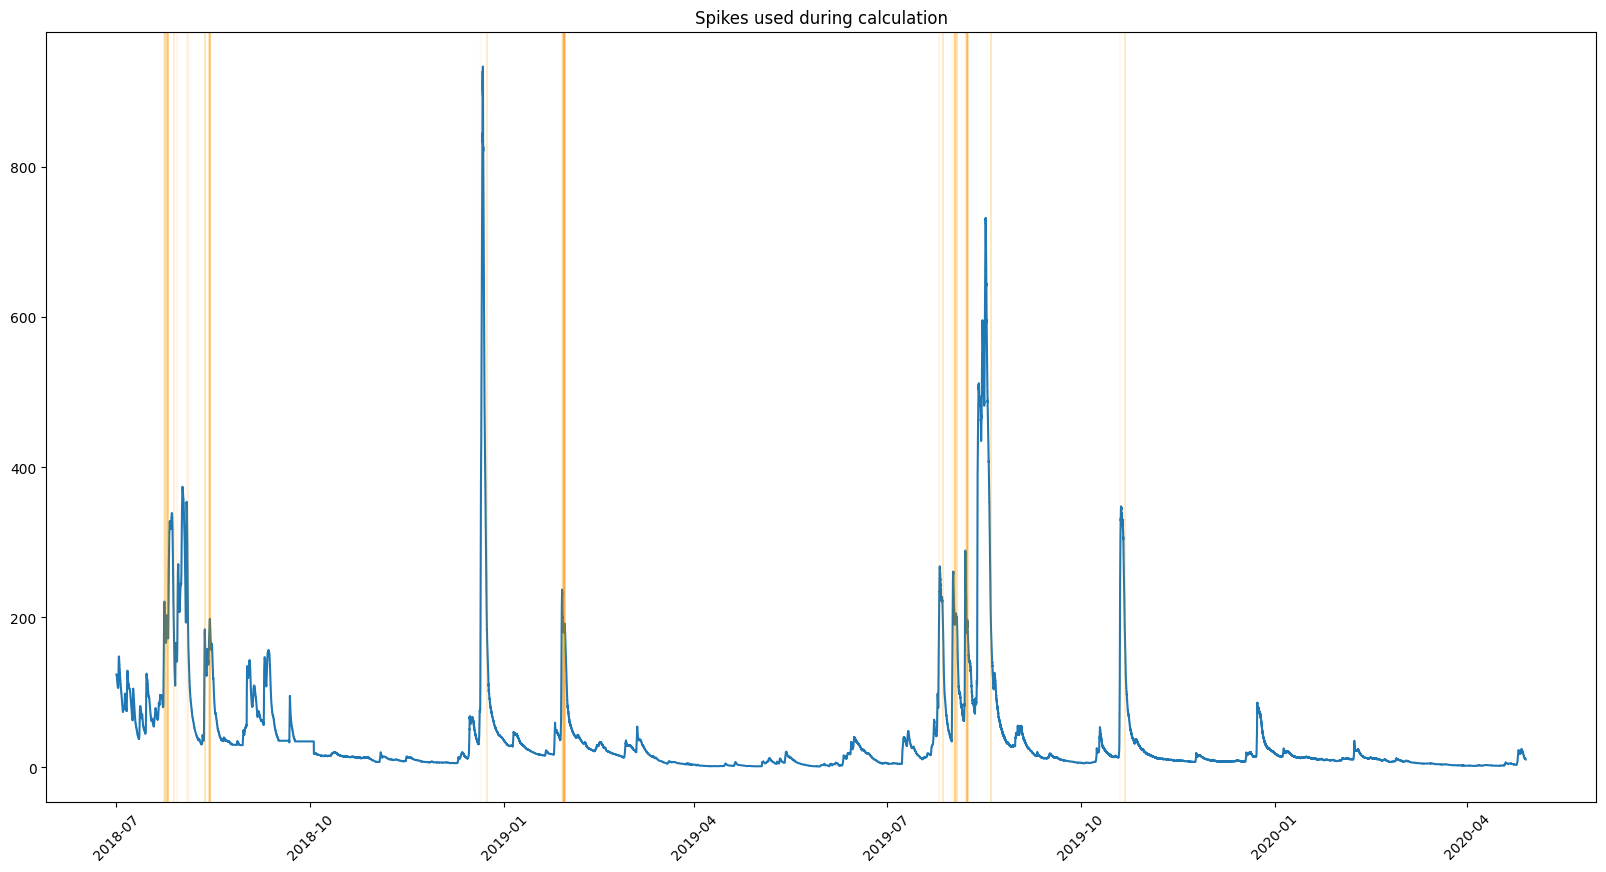

##### Value pair 6 #####


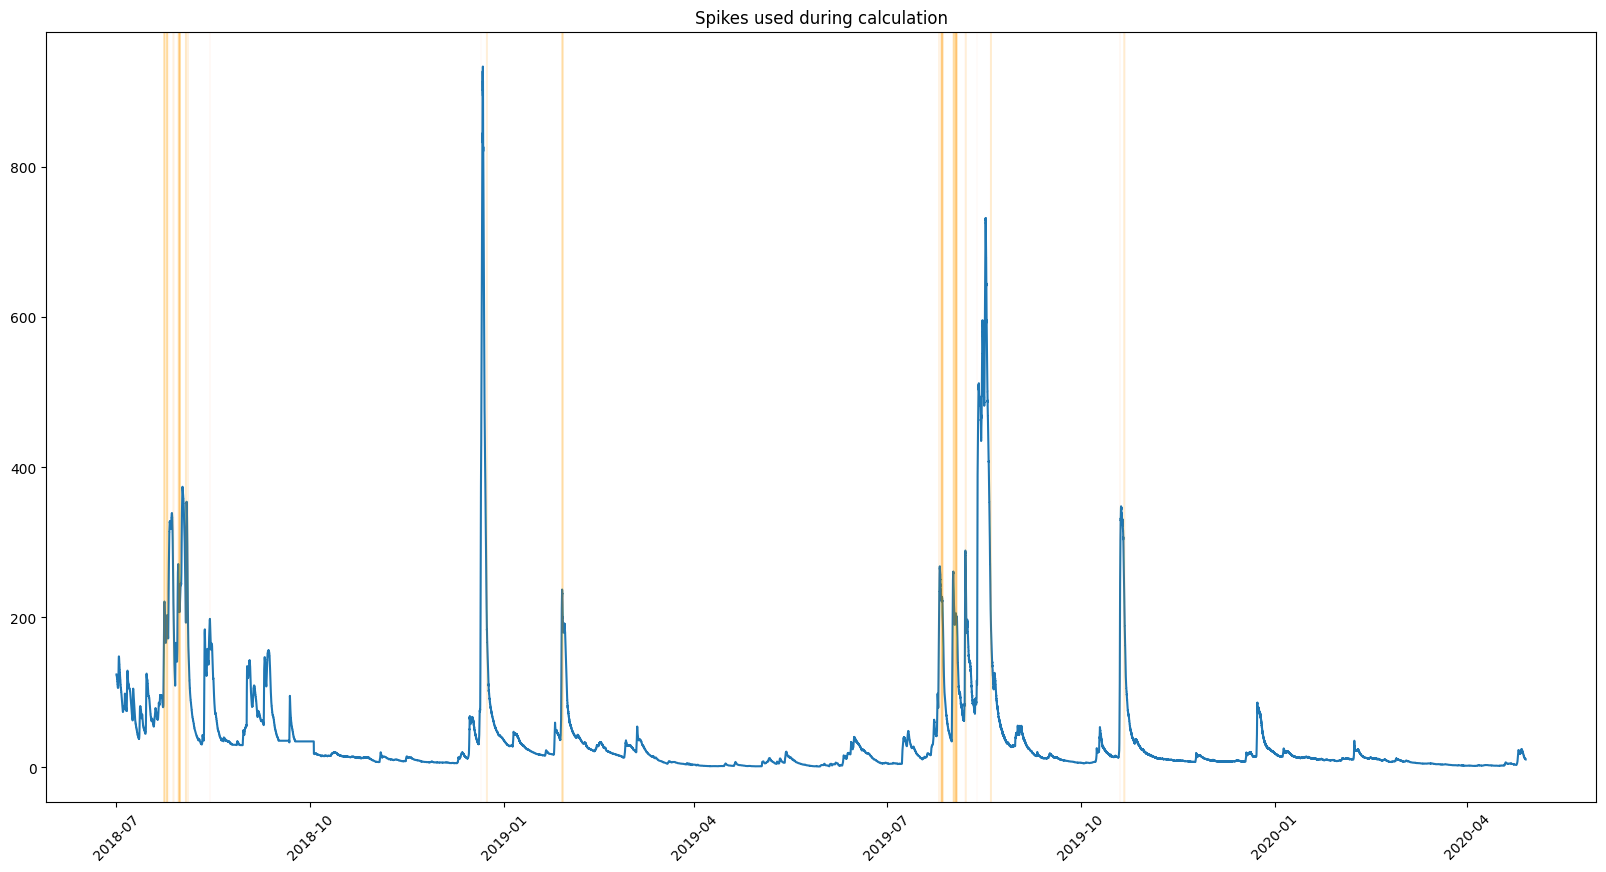

##### Value pair 7 #####


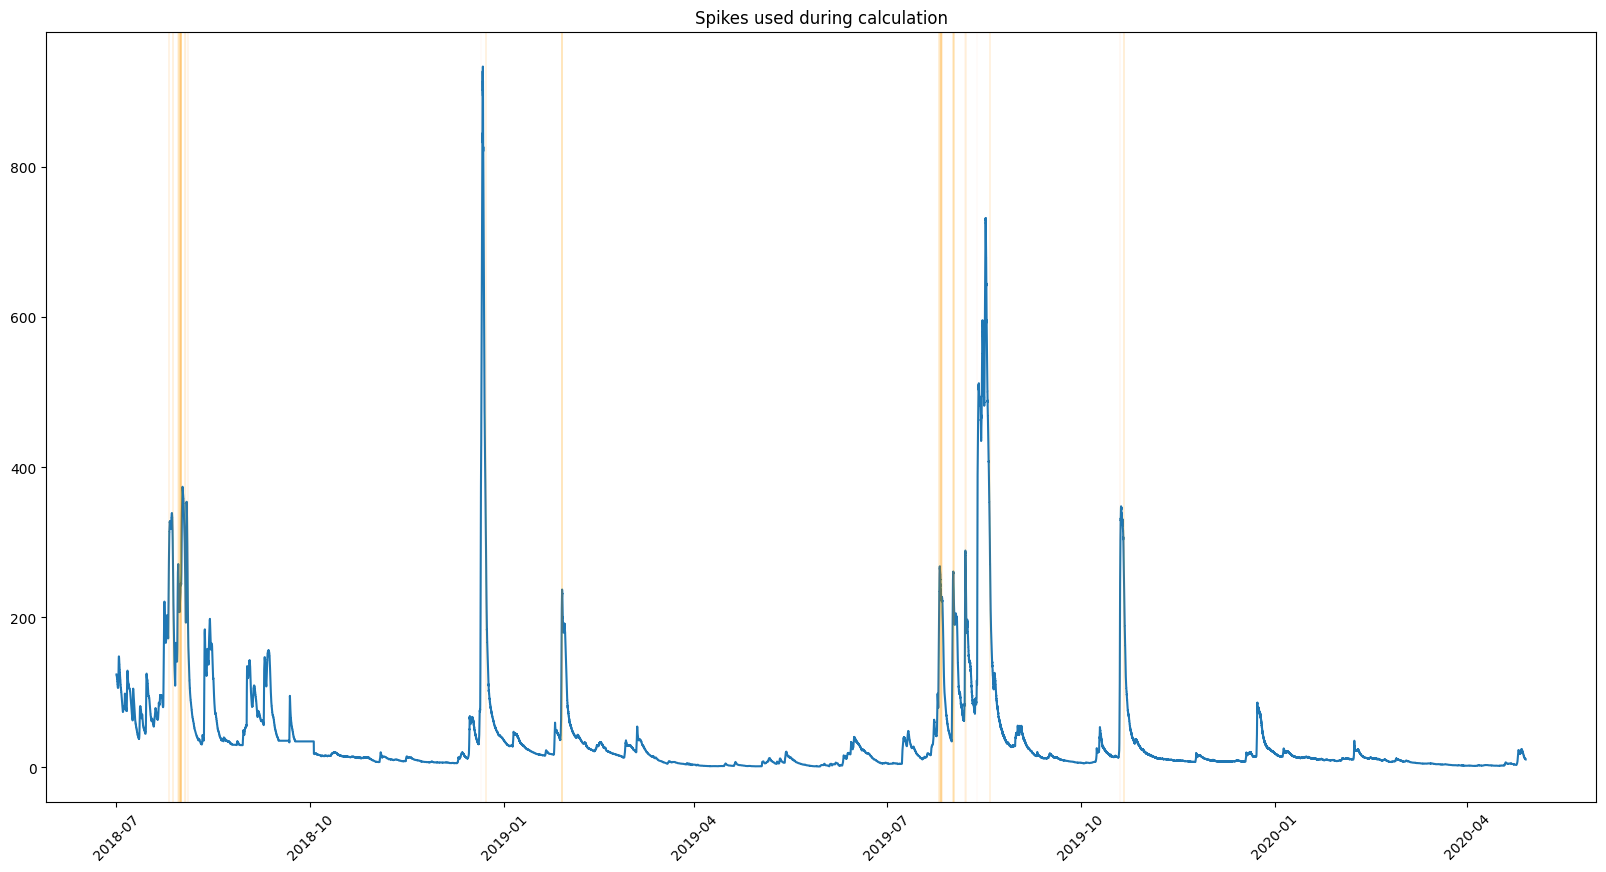

##### Value pair 8 #####


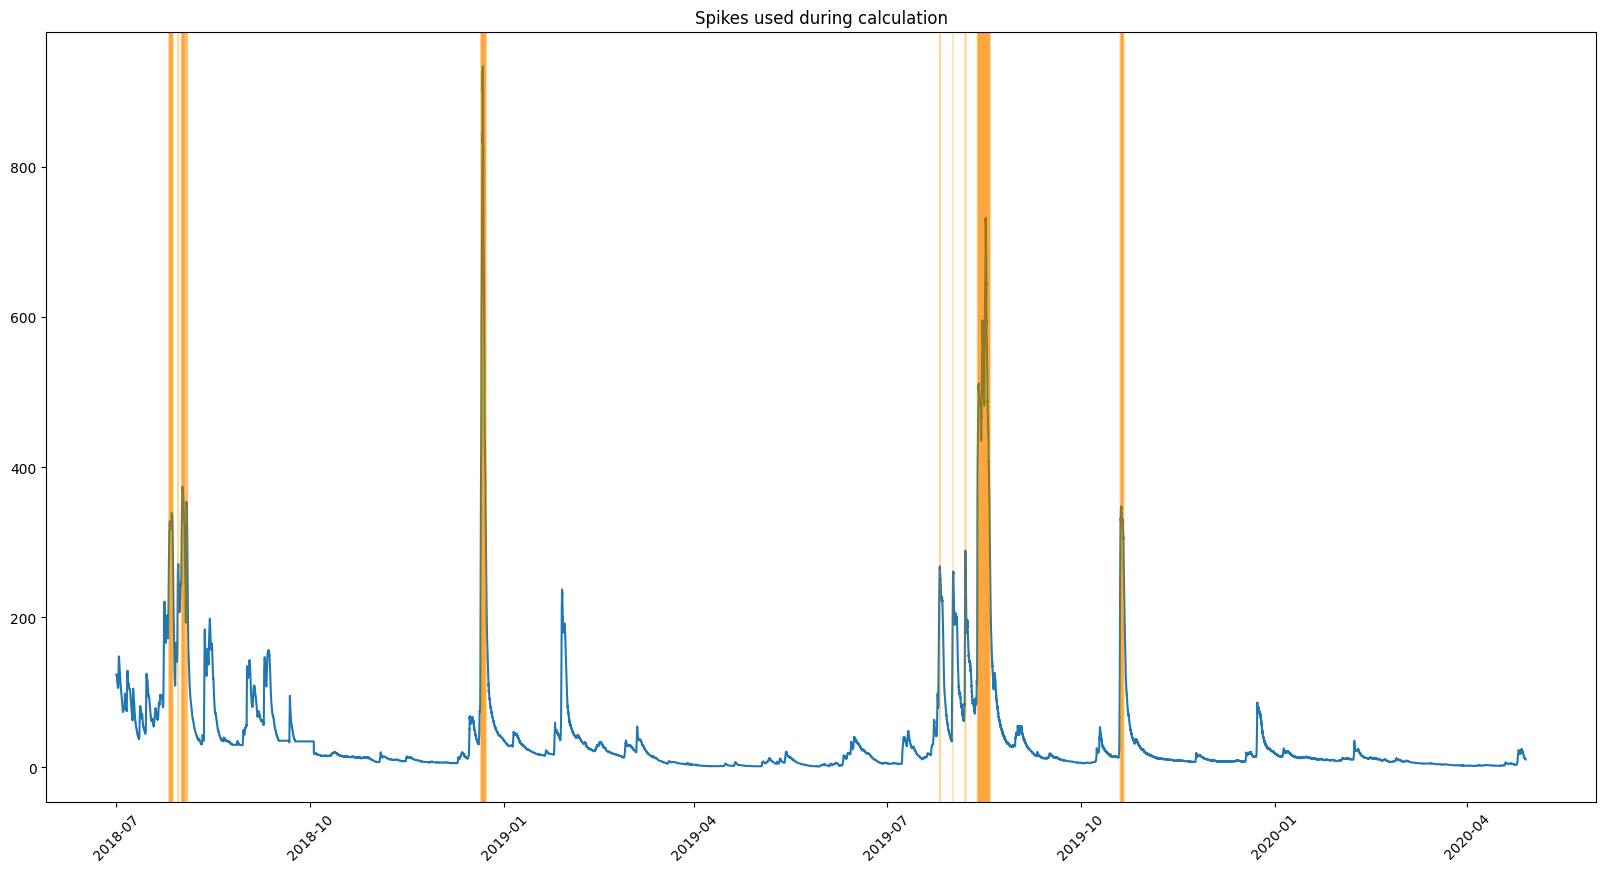

In [ ]:
multiplier_list1 = [1.5, 2, 3, 4, 5, 6, 7, 8]
multiplier_list2 = [2, 3, 4, 5, 6, 7, 8, None]

discharge_spikes_list = []

for i in range(len(multiplier_list1)):

    print(f'##### Value pair {i+1} #####')

    try:

        discharge_spike_mean_value, future_occurance_dates = get_spikes(
            df=train,
            series_name='Discharge (14n)',
            multiplier1=multiplier_list1[i],
            multiplier2=multiplier_list2[i]
        )

        discharge_spikes_list.append(
            (
                discharge_spike_mean_value,
                future_occurance_dates
            )
        )

    except:
        pass

    # print(f"Discharge spikes' average value: {discharge_spike_mean_value}")
    # print(f"Discharge spikes' average duration in seconds: {discharge_spike_mean_freq}")

In [ ]:
print(discharge_spikes_list[0][0], discharge_spikes_list[0][1][:5])

85.13447251114412 [Timestamp('2021-05-09 07:53:00'), Timestamp('2021-05-29 18:43:45'), Timestamp('2021-06-19 05:34:30'), Timestamp('2021-07-09 16:25:15'), Timestamp('2021-07-30 03:16:00')]


##### Value pair 1 #####


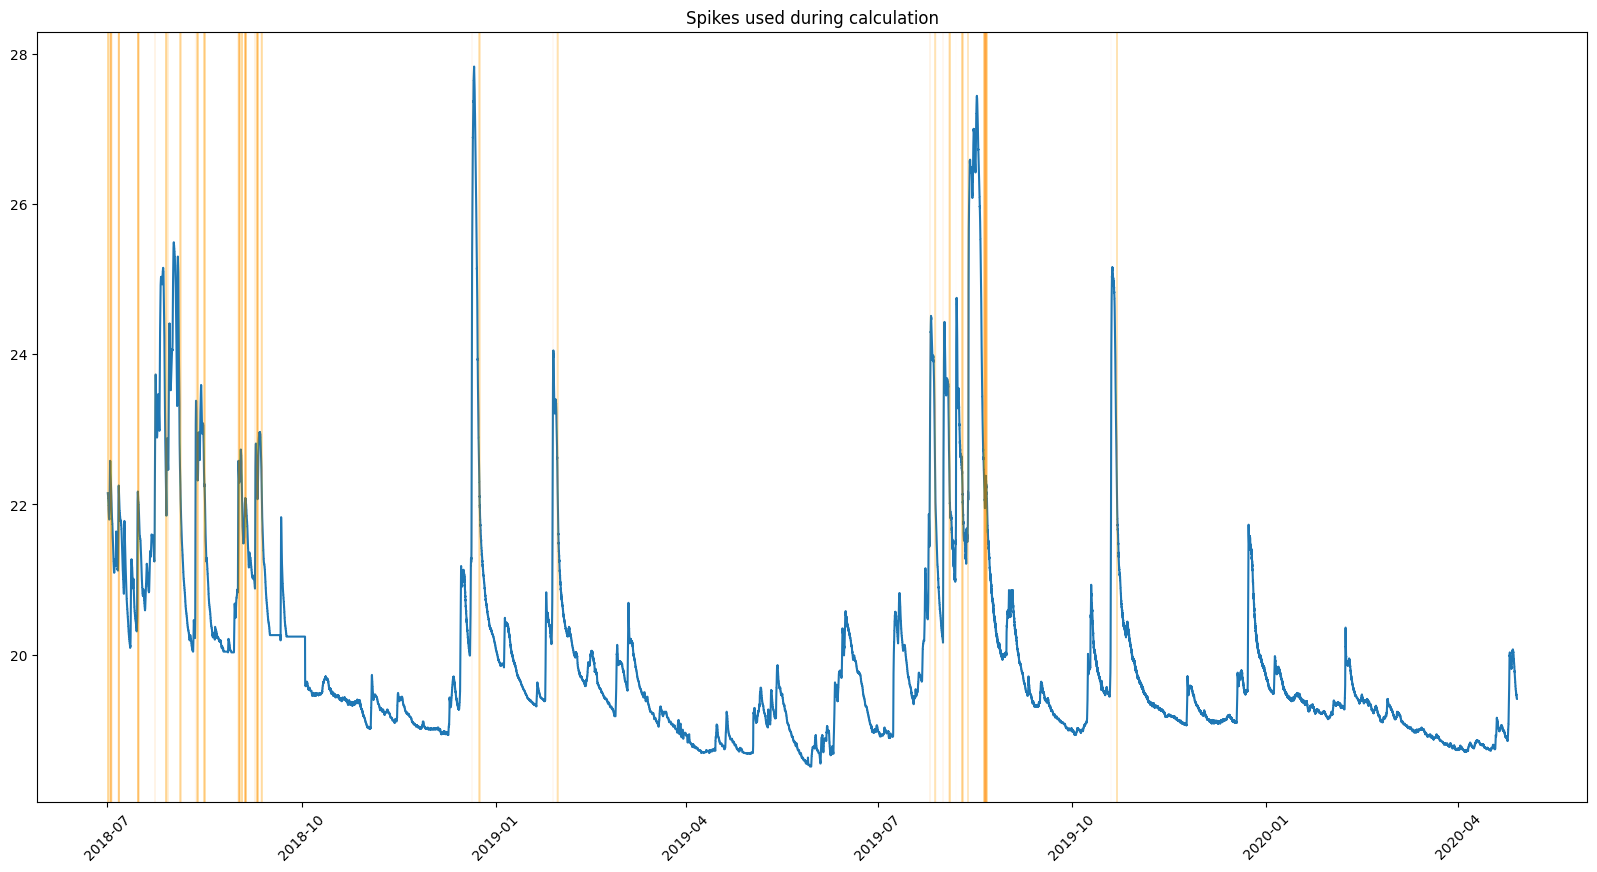

##### Value pair 2 #####


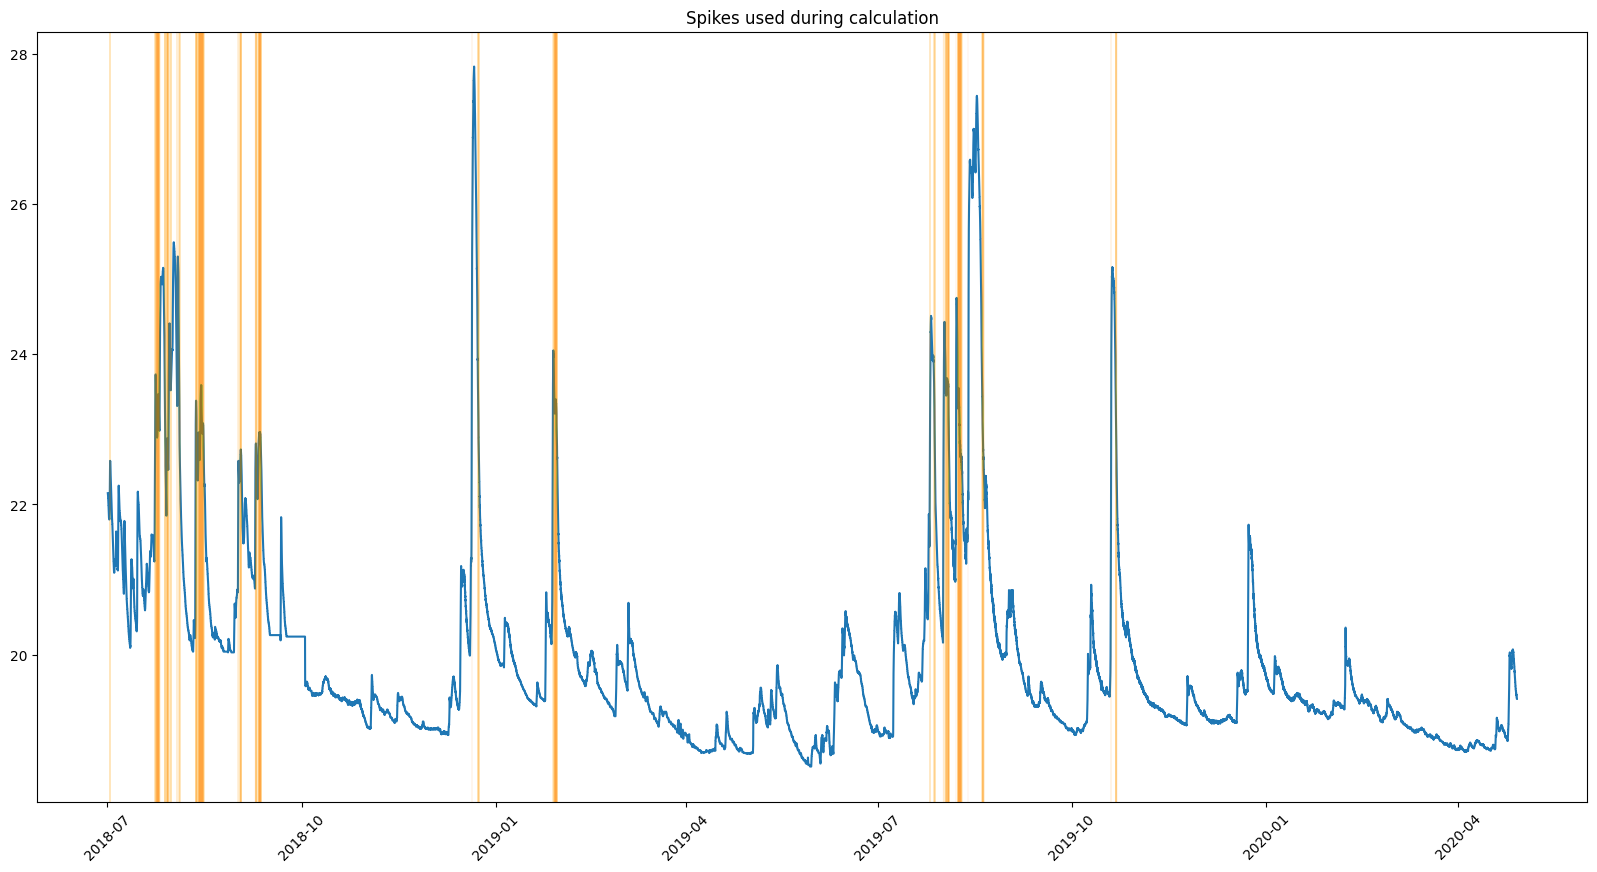

##### Value pair 3 #####


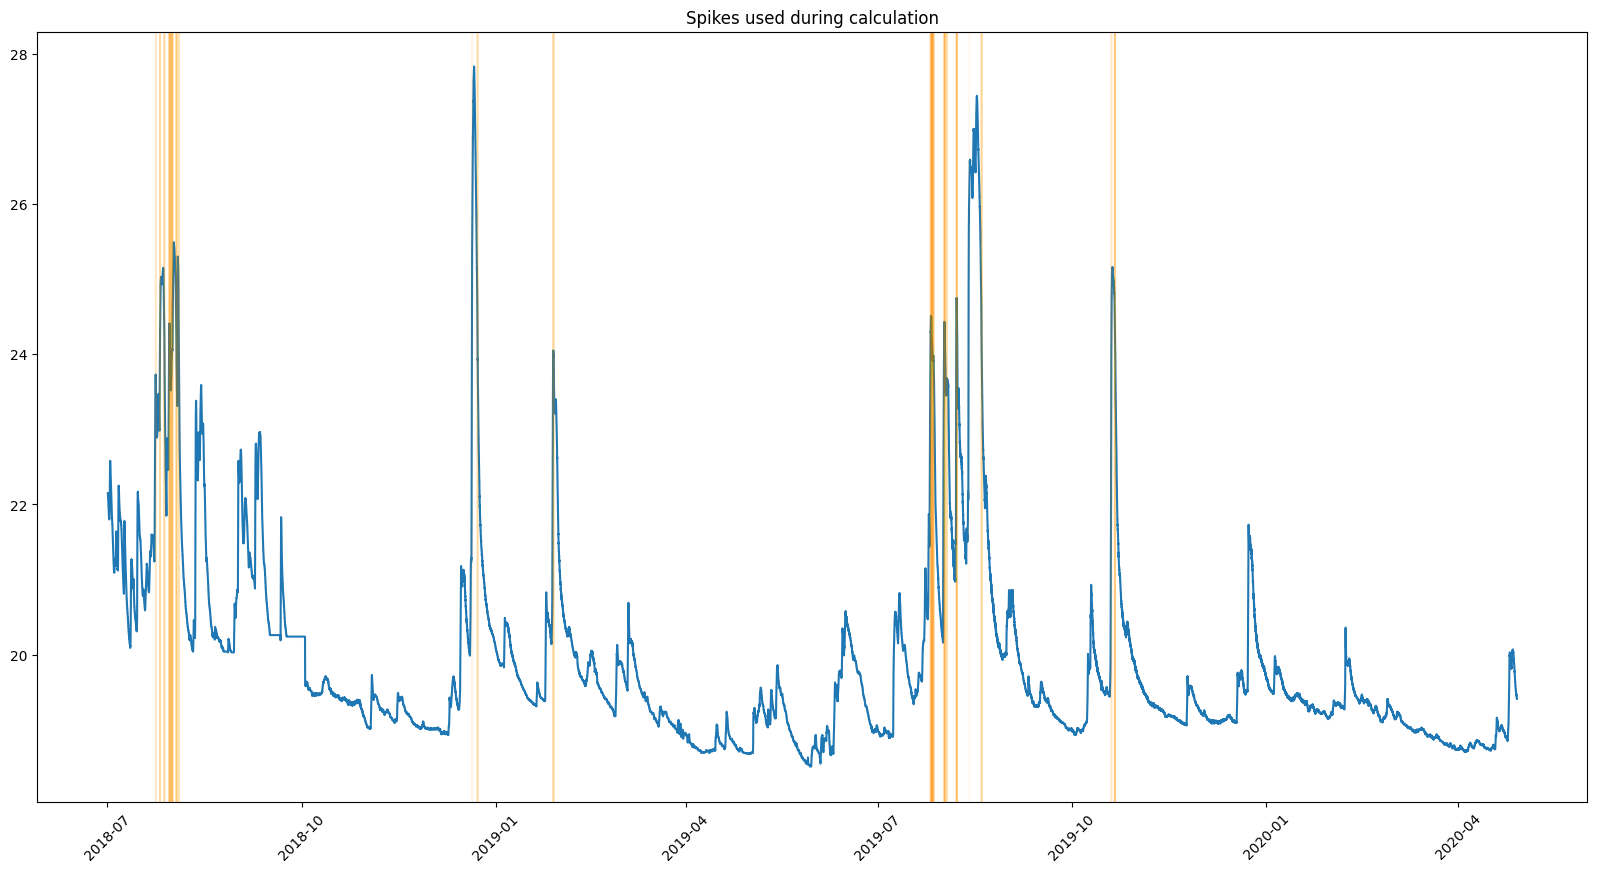

##### Value pair 4 #####


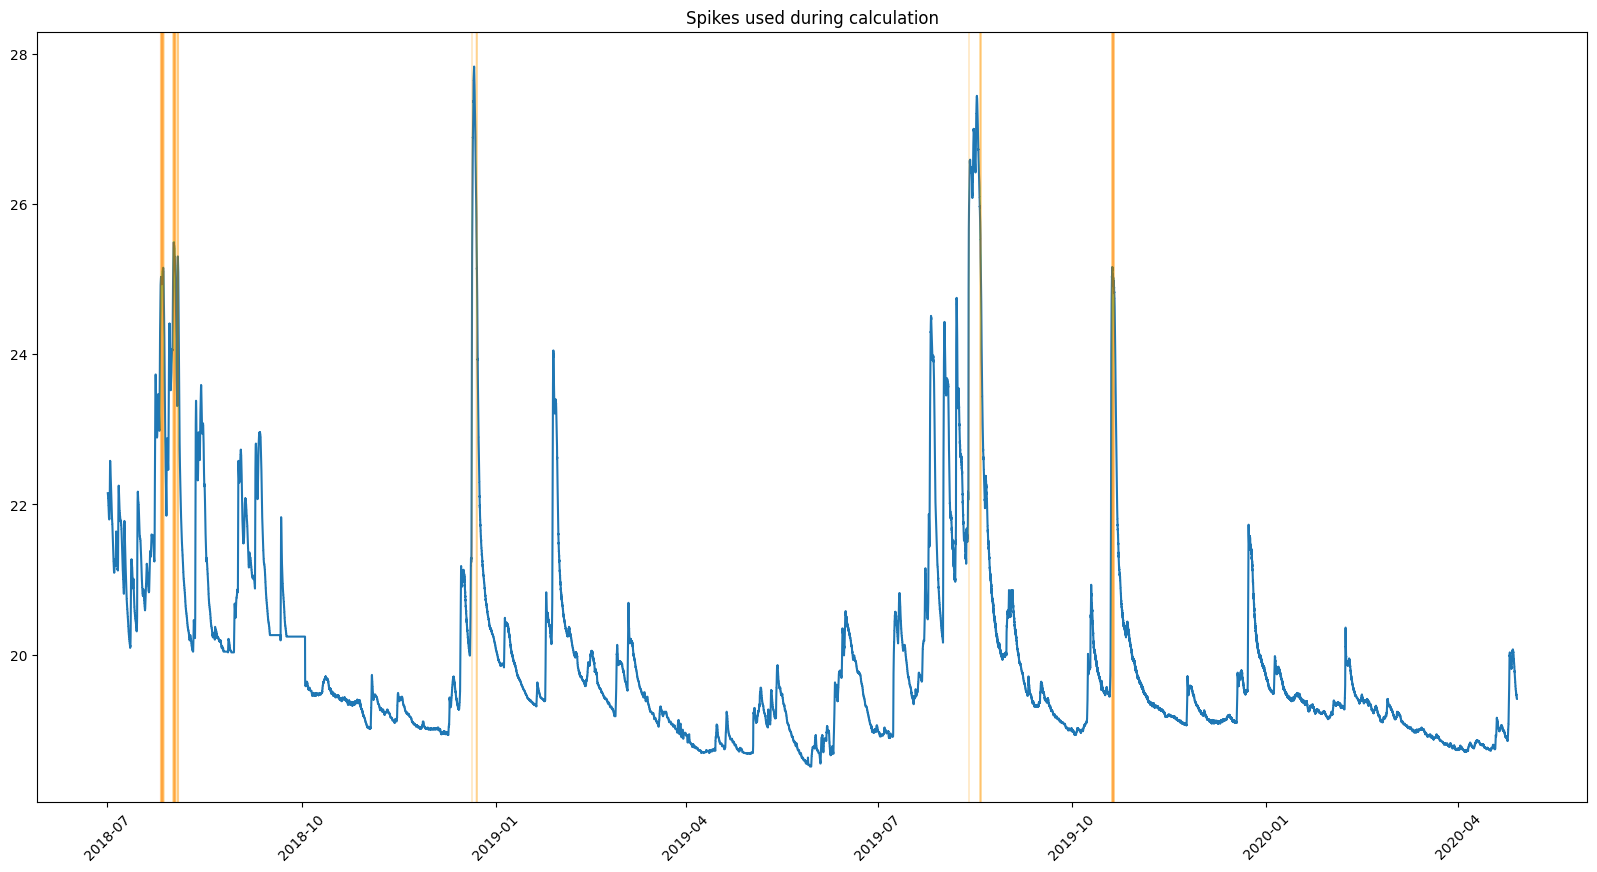

##### Value pair 5 #####


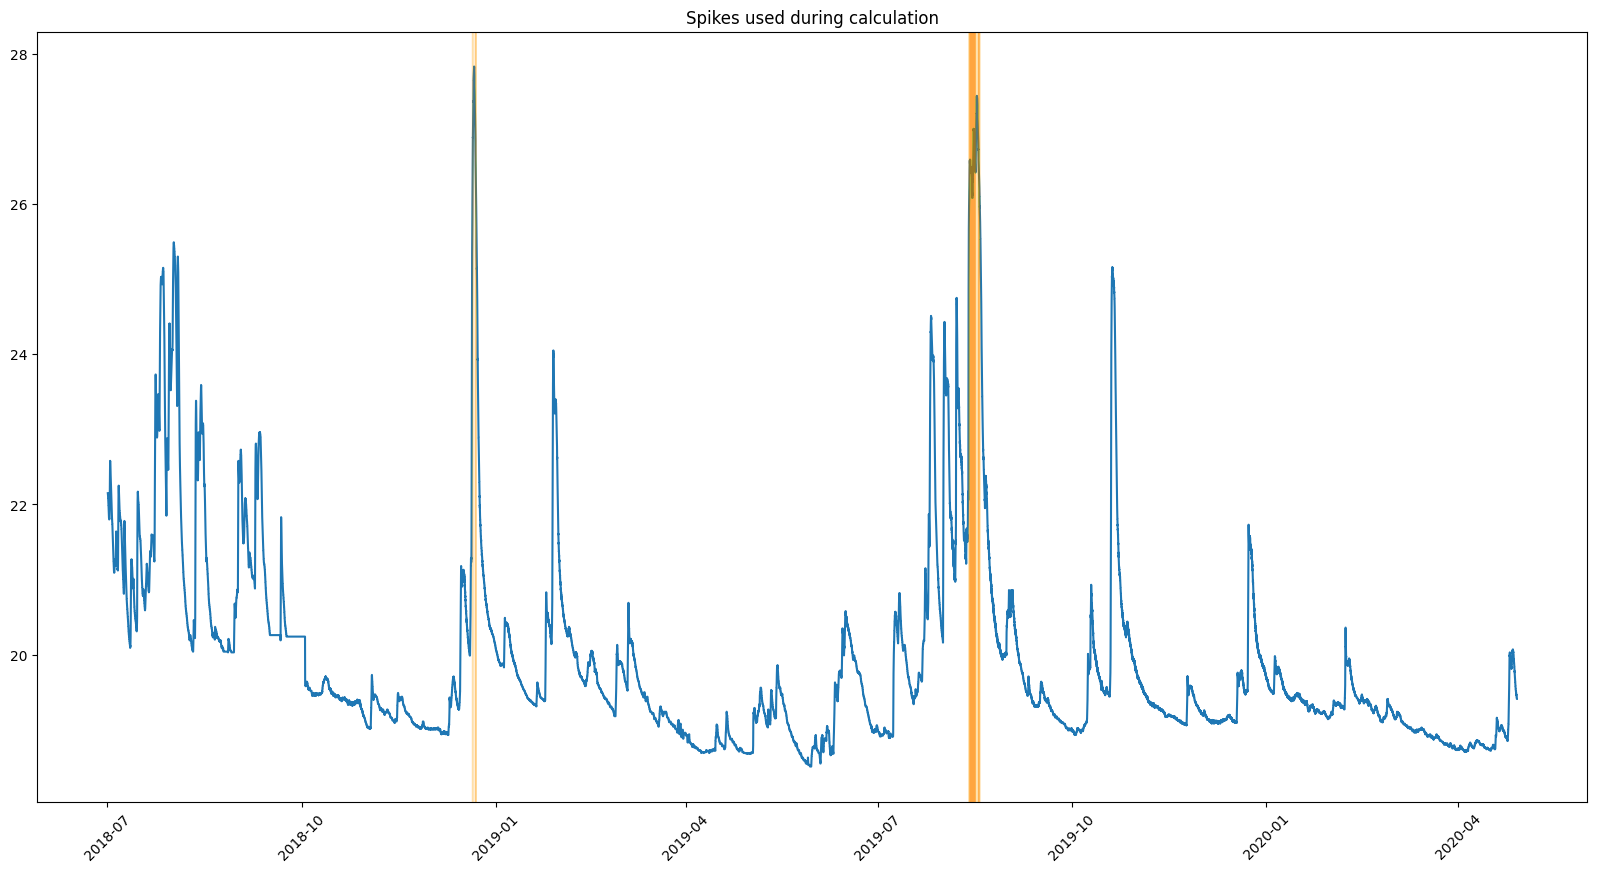

##### Value pair 6 #####
##### Value pair 7 #####
##### Value pair 8 #####


In [ ]:
multiplier_list1 = [1.5, 2, 3, 4, 5, 6, 7, 8]
multiplier_list2 = [2, 3, 4, 5, 6, 7, 8, None]

gage_spikes_list = []

for i in range(len(multiplier_list1)):

    print(f'##### Value pair {i+1} #####')

    try:

        gage_spike_mean_value, future_occurance_dates = get_spikes(
            df=train,
            series_name='Gage_Height (14n)',
            multiplier1=multiplier_list1[i],
            multiplier2=multiplier_list2[i]
        )

        gage_spikes_list.append(
            (
                gage_spike_mean_value,
                future_occurance_dates
            )
        )
    except:
        pass

    # print(f"Discharge spikes' average value: {gage_spike_mean_value}")
    # print(f"Discharge spikes' average duration in seconds: {discharge_spike_mean_freq}")

In [ ]:
print(gage_spikes_list[0][0], gage_spikes_list[0][1][:5])

22.34079086115993 [Timestamp('2021-05-14 21:06:30'), Timestamp('2021-06-04 11:01:00'), Timestamp('2021-06-25 00:55:30'), Timestamp('2021-07-15 14:50:00'), Timestamp('2021-08-05 04:44:30')]


Now we can try to incorporate the spikes into the prediction process and see the results.

In [ ]:
max_discharge = train['Discharge (14n)'].max()

max_gage = train['Gage_Height (14n)'].max()

new_discharge_spikes_list = []

for i in range(len(discharge_spikes_list)):
    new_discharge_spikes_list.append(([], discharge_spikes_list[i][1]))
    for j in range(len(discharge_spikes_list[i][1])):
        temp_diff = max_discharge - discharge_spikes_list[i][0]
        np.random.seed(j)
        temp_diff = temp_diff * np.random.rand()
        temp_spike = temp_diff + discharge_spikes_list[i][0]
        new_discharge_spikes_list[i][0].append(temp_spike)

new_gage_spikes_list = []

for i in range(len(gage_spikes_list)):
    new_gage_spikes_list.append(([], gage_spikes_list[i][1]))
    for j in range(len(gage_spikes_list[i][1])):
        temp_diff = max_gage - gage_spikes_list[i][0]
        np.random.seed(j)
        temp_diff = temp_diff * np.random.rand()
        temp_spike = temp_diff + gage_spikes_list[i][0]
        new_gage_spikes_list[i][0].append(temp_spike)

In [ ]:
# final_5year_prediction = pd.read_csv('predictions.csv')
# final_5year_prediction['DateTime (20d)'] = pd.to_datetime(final_5year_prediction['DateTime (20d)'])

# for i in range(len(discharge_spikes_list)):
#     final_5year_prediction.loc[
#         final_5year_prediction['DateTime (20d)'].isin(discharge_spikes_list[i][1]),
#         'Discharge (14n)'
#     ] = discharge_spikes_list[i][0]

# for i in range(len(gage_spikes_list)):
#     final_5year_prediction.loc[
#         final_5year_prediction['DateTime (20d)'].isin(gage_spikes_list[i][1]),
#         'Gage_Height (14n)'
#     ] = gage_spikes_list[i][0]

In [ ]:
# final_5year_prediction = pd.read_csv('predictions.csv')
# final_5year_prediction['DateTime (20d)'] = pd.to_datetime(final_5year_prediction['DateTime (20d)'])

for i in range(len(new_discharge_spikes_list)):
    for j in range(len(new_discharge_spikes_list[i][1])):
        final_5year_prediction.loc[
            final_5year_prediction.index==new_discharge_spikes_list[i][1][j],
            'Discharge (14n)'
        ] = new_discharge_spikes_list[i][0][j]

for i in range(len(new_gage_spikes_list)):
    for j in range(len(new_gage_spikes_list[i][1])):
        final_5year_prediction.loc[
            final_5year_prediction.index==new_gage_spikes_list[i][1][j],
            'Gage_Height (14n)'
        ] = new_gage_spikes_list[i][0][j]

In [ ]:
# final_5year_prediction.set_index('DateTime (20d)', inplace=True)

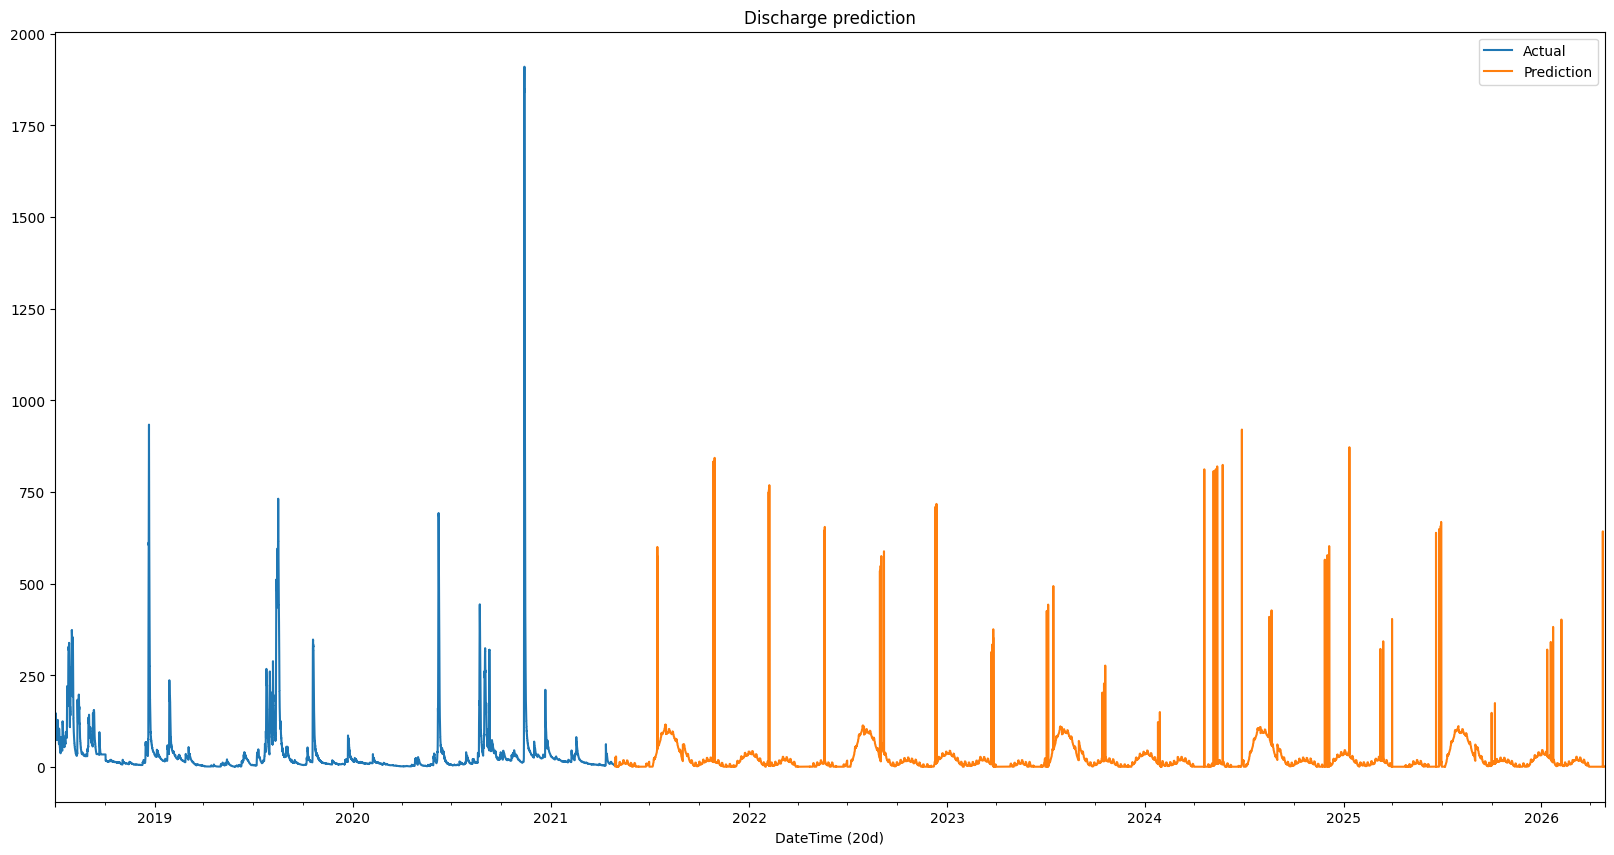

In [ ]:
ax = data.set_index('DateTime (20d)')['Discharge (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_prediction['Discharge (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Discharge prediction',
    legend=True,
    label='Prediction'
);

# final_5year_prediction['Discharge (14n)'].rolling(10).mean().plot(
#     ax=ax,
#     # linewidth=3,
#     title='Discharge prediction',
#     legend=True,
#     label='MA'
# );

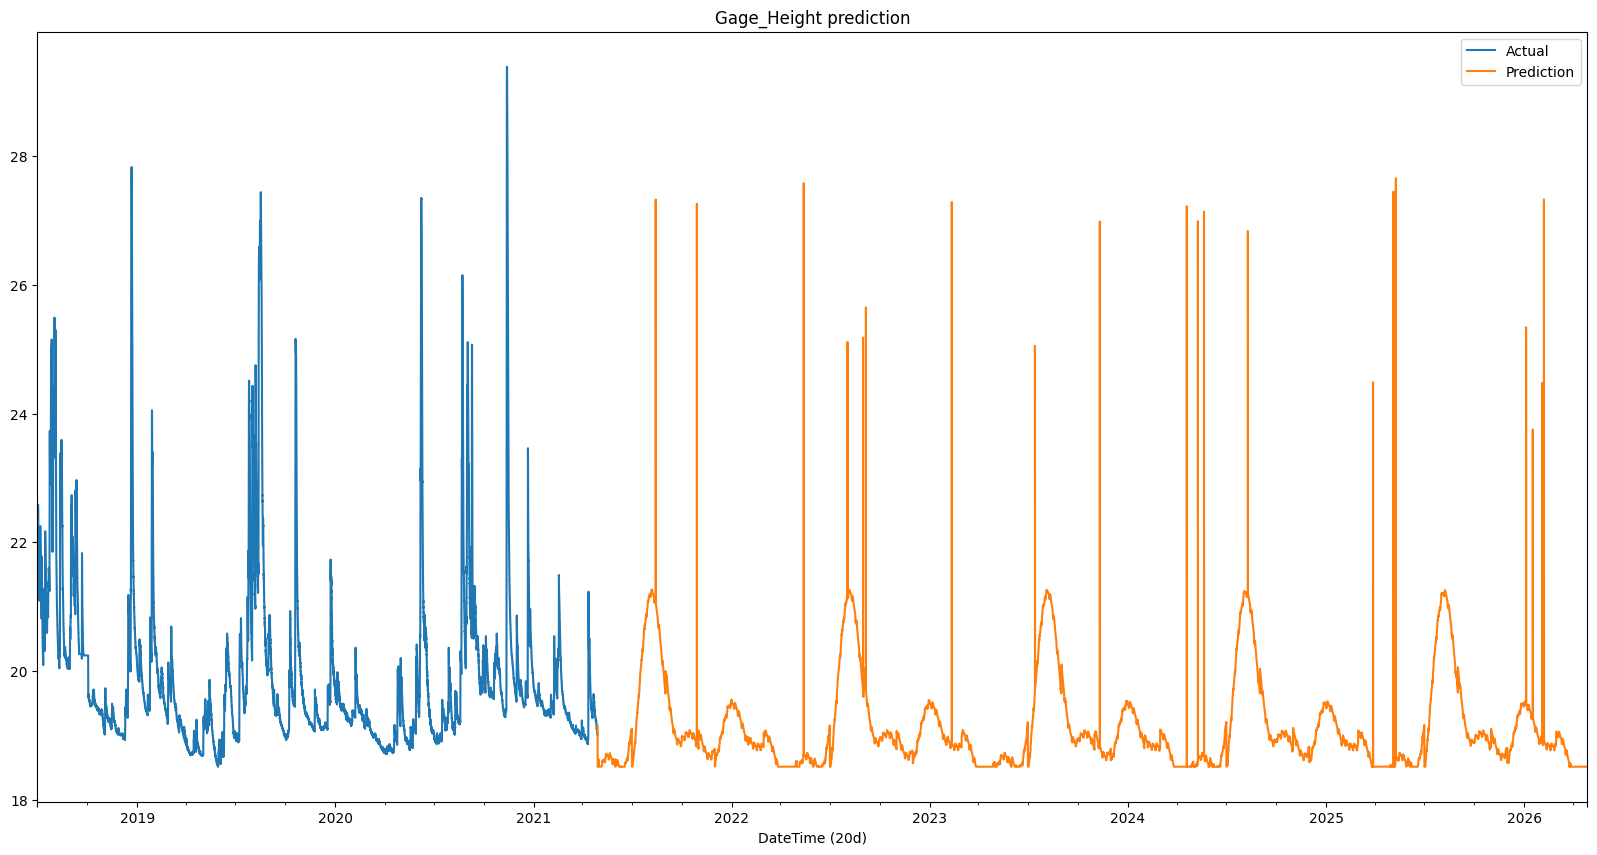

In [ ]:
ax = data.set_index('DateTime (20d)')['Gage_Height (14n)'].plot(
    legend=True, label='Actual'
)

final_5year_prediction['Gage_Height (14n)'].plot(
    ax=ax,
    # linewidth=3,
    title='Gage_Height prediction',
    legend=True,
    label='Prediction'
);

# final_5year_prediction['Gage_Height (14n)'].rolling(10).mean().plot(
#     ax=ax,
#     # linewidth=3,
#     title='Gage_Height prediction',
#     legend=True,
#     label='MA'
# );

Saving the output

In [ ]:
final_5year_prediction.to_csv('predictions_spikes_included.csv')

Converting notebook to doc file

In [ ]:
!jupyter nbconvert --to html Upwork_hydro_data_prediction_v4.ipynb
!pip install pandoc -q
import pandoc
! pandoc /content/Upwork_hydro_data_prediction_v4.html -s -o hydro_analysis.docx

[NbConvertApp] WARNING | pattern 'Upwork_hydro_data_prediction_v4.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes